In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Navigate to the Directory Containing the CSV File
import os
os.chdir('/content/drive/My Drive/DS266 Project')

In [6]:
# Install the most recent version of TensorFlow to use the improved masking support for `tf.keras.layers.MultiHeadAttention`.
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package libcudnn8 is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Version '8.1.0.77-1+cuda11.2' for 'libcudnn8' was not found
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatible.


In [2]:
# Install compatible TensorFlow version
!pip uninstall tensorflow -y
!pip install tensorflow==2.15

# Reinstall tf-keras to resolve any potential dependency conflicts
!pip uninstall tf-keras -y
!pip install tf-keras

!pip uninstall tensorflow-text -y
!pip install tensorflow-text==2.15

!pip install bayesian-optimization
!pip install optuna

Found existing installation: tensorflow 2.15.1
Uninstalling tensorflow-2.15.1:
  Successfully uninstalled tensorflow-2.15.1
  Using cached tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB)
  Using cached ml_dtypes-0.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2


  Using cached tf_keras-2.16.0-py3-none-any.whl (1.7 MB)
  Using cached tensorflow-2.16.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (589.8 MB)
  Using cached ml_dtypes-0.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.2 MB)
  Using cached tensorboard-2.16.2-py3-none-any.whl (5.5 MB)
  Using cached keras-3.2.1-py3-none-any.whl (1.1 MB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successful

  Using cached tensorflow_text-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.2 MB)
  Using cached tensorflow-2.15.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB)
  Using cached tensorboard-2.15.2-py3-none-any.whl (5.5 MB)
  Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
  Using cached tf_keras-2.15.1-py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.1
    Uninstalling tensorflow-2.16.1:
      Successfully uninstalled

In [1]:
import logging
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_text as text

from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from bayes_opt import BayesianOptimization
from tensorflow.keras.callbacks import EarlyStopping

## Prep the Data

In [5]:
# Read the CSV file
tweets_df = pd.read_csv('train.csv')

# Extract sentences and labels
sentences = tweets_df['text']
labels = tweets_df['target']

# Setup the tokenizer and preprocess the sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
MAX_TOKENS = 30
sequences = tokenizer.texts_to_sequences(sentences)
sequences = pad_sequences(sequences, maxlen=MAX_TOKENS, padding='post')
labels = labels.to_numpy()

# Split the data into training and validation sets
sequences_train, sequences_val, labels_train, labels_val = train_test_split(
    sequences, labels, test_size=0.3, random_state=42)

# Convert to TensorFlow Datasets and batching
BUFFER_SIZE = len(sequences_train)
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((sequences_train, labels_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((sequences_val, labels_val))
val_dataset = val_dataset.batch(BATCH_SIZE)

# Inspect the dataset
print("Training batch example:", next(iter(train_dataset)))
print("Validation batch example:", next(iter(val_dataset)))


Training batch example: (<tf.Tensor: shape=(64, 30), dtype=int32, numpy=
array([[ 3501,  2523,   661, ...,     0,     0,     0],
       [   10,   589,     6, ...,     0,     0,     0],
       [  587,  1110,  2305, ...,     0,     0,     0],
       ...,
       [  137,    11, 19680, ...,     0,     0,     0],
       [  142,     7,   662, ...,     0,     0,     0],
       [  272,  6744,     8, ...,     0,     0,     0]], dtype=int32)>, <tf.Tensor: shape=(64,), dtype=int64, numpy=
array([0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0])>)
Validation batch example: (<tf.Tensor: shape=(64, 30), dtype=int32, numpy=
array([[   35,    14,    27, ...,     0,     0,     0],
       [    4,  1184,    29, ...,     0,     0,     0],
       [18421, 18422,   105, ...,     0,     0,     0],
       ...,
       [ 1471,   582,  1972, ...,     0,     0,

# Model 1: Transformer Classifier

In [ ]:
# Define model components
def positional_encoding(length, depth):
  depth = depth/2
  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)
  pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
  return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(tf.keras.layers.Layer):
  """Custom Keras layer that integrates positional encodings with embeddings.

    This layer creates an embedding matrix for the vocabulary and adds positional
    encoding to inject some information about the relative or absolute position
    of the tokens in the sequence. The positional encodings have the same dimension
    as the embeddings, allowing the two to be summed.

    Args:
        vocab_size (int): Size of the vocabulary.
        d_model (int): Dimensionality of the embeddings.

    Attributes:
        d_model (int): Stored dimensionality of the model used in scaling calculations.
        embedding (tf.keras.layers.Embedding): Embedding layer for the tokens.
        pos_encoding (tf.Tensor): Precomputed positional encodings.
    """
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    """Generates a mask for padding tokens. This mask is then used to ignore these tokens."""
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    """Performs the embedding lookup and adds the positional encoding.

        Args:
            x (tf.Tensor): Tensor of token indices.

        Returns:
            tf.Tensor: Embedded and positionally encoded tensor.
        """
    length = tf.shape(x)[1]
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) # Scale embeddings
    x = x + self.pos_encoding[tf.newaxis, :length, :] # Add positional encoding
    return x

class BaseAttention(tf.keras.layers.Layer):
  """Base class for attention mechanisms.

    This class is designed to be extended by specific attention implementations.
    It initializes the components common to various attention mechanisms, such as
    multi-head attention, layer normalization, and addition for residual connections.

    Attributes:
        mha (tf.keras.layers.MultiHeadAttention): Multi-head attention layer.
        layernorm (tf.keras.layers.LayerNormalization): Normalizes the layer outputs.
        add (tf.keras.layers.Add): Implements the residual connection by adding input to the layer output.
    """
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

class GlobalSelfAttention(BaseAttention):
  """Extends BaseAttention to apply self-attention to the inputs.

    This class uses a multi-head attention mechanism to allow the model to jointly
    attend to information from different representation subspaces at different positions.
    After the attention mechanism, the result is added to the original input (residual connection)
    and then passed through a layer normalization.

    Methods:
        call(x): Computes the self-attention and returns the transformed output.
    """
  def call(self, x):
    """Compute self-attention and apply normalization.

        Args:
            x (tf.Tensor): The input tensor.

        Returns:
            tf.Tensor: The output tensor after applying self-attention and layer normalization.
        """
    attn_output, attn_scores = self.mha(
        query=x,
        value=x,
        key=x,
        return_attention_scores=True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    return x

class FeedForward(tf.keras.layers.Layer):
  """Defines a feed-forward network layer which is used in the transformer.

    This class creates a two-layer neural network with a ReLU activation in between,
    followed by dropout for regularization, and a residual connection around the network.

    Args:
        d_model (int): Dimensionality of the input and output.
        dff (int): Dimensionality of the inner layer.
        dropout_rate (float): Dropout rate.

    Attributes:
        seq (tf.keras.Sequential): Sequential model performing the feed-forward operation.
        add (tf.keras.layers.Add): Layer to perform the addition in the residual connection.
        layer_norm (tf.keras.layers.LayerNormalization): Layer to normalize the data.
    """
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # First dense layer with ReLU
      tf.keras.layers.Dense(d_model),                 # Second dense layer
      tf.keras.layers.Dropout(dropout_rate)           # Dropout for regularization
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    """Applies the feed-forward network to x with a residual connection followed by layer normalization.

        Args:
            x (tf.Tensor): Input tensor.

        Returns:
            tf.Tensor: Normalized output tensor.
        """
    x = self.add([x, self.seq(x)])  # Apply residual connection
    x = self.layer_norm(x)          # Normalize the output
    return x

class EncoderLayer(tf.keras.layers.Layer):
  """Single encoder layer consisting of self-attention and feed-forward network.

    This class represents one layer of the transformer's encoder part, which includes
    a self-attention mechanism and a position-wise feed-forward network, both with
    residual connections and layer normalization.

    Args:
        d_model (int): Dimensionality of the input and output.
        num_heads (int): Number of attention heads.
        dff (int): Dimensionality of the feed-forward network's inner layer.
        dropout_rate (float): Dropout rate used in MultiHeadAttention and the feed-forward network.

    Attributes:
        self_attention (GlobalSelfAttention): The self-attention component of the encoder.
        ffn (FeedForward): The feed-forward network component of the encoder.
    """
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()
    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    """Process input through one encoder layer and return the output.

        Args:
            x (tf.Tensor): Input tensor to the encoder layer.

        Returns:
            tf.Tensor: Output tensor of the encoder layer.
        """
    x = self.self_attention(x)  # Apply self-attention
    x = self.ffn(x)             # Apply feed-forward network
    return x

class Encoder(tf.keras.layers.Layer):
  """The Encoder module of the Transformer model.

    This class aggregates multiple encoder layers, applies positional embeddings to the input,
    and processes the sequence through each encoder layer sequentially.

    Args:
        num_layers (int): Number of encoder layers.
        d_model (int): Dimensionality of the input and output of the encoder layers.
        num_heads (int): Number of attention heads in each encoder layer.
        dff (int): Dimensionality of the feed-forward network's inner layer in each encoder layer.
        vocab_size (int): Size of the vocabulary for embedding.
        dropout_rate (float): Dropout rate to be applied in each encoder layer and to the input.

    Attributes:
        d_model (int): Dimensionality of the model used in scaling calculations.
        num_layers (int): Total number of encoder layers.
        pos_embedding (PositionalEmbedding): Layer that adds positional embeddings to token embeddings.
        enc_layers (list): List of encoder layers.
        dropout (tf.keras.layers.Dropout): Dropout layer applied to the output of positional embeddings.
    """
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)
    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    """Processes input sequence through the encoder stack.

        Args:
            x (tf.Tensor): Input tensor to the encoder.

        Returns:
            tf.Tensor: Output tensor from the encoder.
        """
    x = self.pos_embedding(x)
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x

class TransformerClassifier(tf.keras.Model):
  """Transformer model for classification tasks.

    This class encapsulates the entire Transformer model tailored for a binary classification task.
    It includes an encoder and a final dense layer with a sigmoid activation function to produce a probability.

    Args:
        num_layers (int): Number of layers in the encoder.
        d_model (int): Dimensionality of the input and output of the encoder.
        num_heads (int): Number of attention heads in each encoder layer.
        dff (int): Dimensionality of the feed-forward network's inner layer.
        input_vocab_size (int): Size of the input vocabulary.
        dropout_rate (float): Dropout rate used throughout the encoder.

    Attributes:
        encoder (Encoder): The Transformer's encoder.
        final_layer (tf.keras.layers.Dense): Final dense layer used for binary classification.
    """
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(1, activation='sigmoid')

  def call(self, inputs):
    """Processes inputs through the encoder and the final dense layer.

        Args:
            inputs (tf.Tensor): Input tensor to the model.

        Returns:
            tf.Tensor: Output tensor representing the probability of the positive class.
        """
    context = inputs
    context = self.encoder(context)  # (batch_size, context_len, d_model)
    logits = self.final_layer(context[:, -1, :])  # Use the last hidden state
    return logits

# Instantiate the transformer model
model1 = TransformerClassifier(
    num_layers=2,
    d_model=100,
    num_heads=8,
    dff=512,
    input_vocab_size=max(tokenizer.word_index.values()) + 1,
    dropout_rate=0.2)

# Define the learning rate scheduler
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)  # Ensure d_model is a float
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)  # Ensure warmup_steps is a float

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Cast step to float32 to ensure compatibility
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        # Ensure division by sqrt of d_model
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        return {
            "d_model": self.d_model.numpy(),  # Return python float
            "warmup_steps": self.warmup_steps.numpy()  # Return python float
        }

# Instantiate the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=CustomSchedule(d_model=100),
                                     beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Compile model
model1.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
    run_eagerly=False)

# Define callbacks for checkpointing
checkpoint_dir = './model_checkpoints/'
checkpoint_filepath = checkpoint_dir + 'tx_w_embeddings_cl2.{epoch:02d}-{val_accuracy:.2f}'

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )]

## Training

In [ ]:
# Train the model
history_model1 = model1.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks_list)

# Specify the directory to save the model
model_dir = '/content/drive/My Drive/DS266 Project/model1_baseline'

# Save as TensorFlow SavedModel
model1.save(model_dir)  # Save the model using the SavedModel format

# To confirm the save, list the contents of the directory
!ls "{model_dir}"


Epoch 1/10
84/84 [==============================] - 14s 103ms/step - loss: 0.7308 - accuracy: 0.5309 - val_loss: 0.6739 - val_accuracy: 0.5771
Epoch 2/10
84/84 [==============================] - 4s 53ms/step - loss: 0.7046 - accuracy: 0.5433 - val_loss: 0.6730 - val_accuracy: 0.5701
Epoch 3/10
84/84 [==============================] - 3s 33ms/step - loss: 0.6749 - accuracy: 0.5778 - val_loss: 0.6785 - val_accuracy: 0.5722
Epoch 4/10
84/84 [==============================] - 3s 33ms/step - loss: 0.5898 - accuracy: 0.6847 - val_loss: 0.5285 - val_accuracy: 0.7518
Epoch 5/10
84/84 [==============================] - 3s 31ms/step - loss: 0.4544 - accuracy: 0.7925 - val_loss: 0.4724 - val_accuracy: 0.7846
Epoch 6/10
84/84 [==============================] - 2s 25ms/step - loss: 0.3484 - accuracy: 0.8561 - val_loss: 0.8319 - val_accuracy: 0.7093
Epoch 7/10
84/84 [==============================] - 2s 27ms/step - loss: 0.2938 - accuracy: 0.8825 - val_loss: 0.6248 - val_accuracy: 0.7789
Epoch 8/10


In [ ]:
# Print model summary
print(model1.summary())

Model: "transformer_classifier_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_2 (Encoder)         multiple                  3116924   
                                                                 
 dense_14 (Dense)            multiple                  101       
                                                                 
Total params: 3117025 (11.89 MB)
Trainable params: 3117025 (11.89 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## Performance

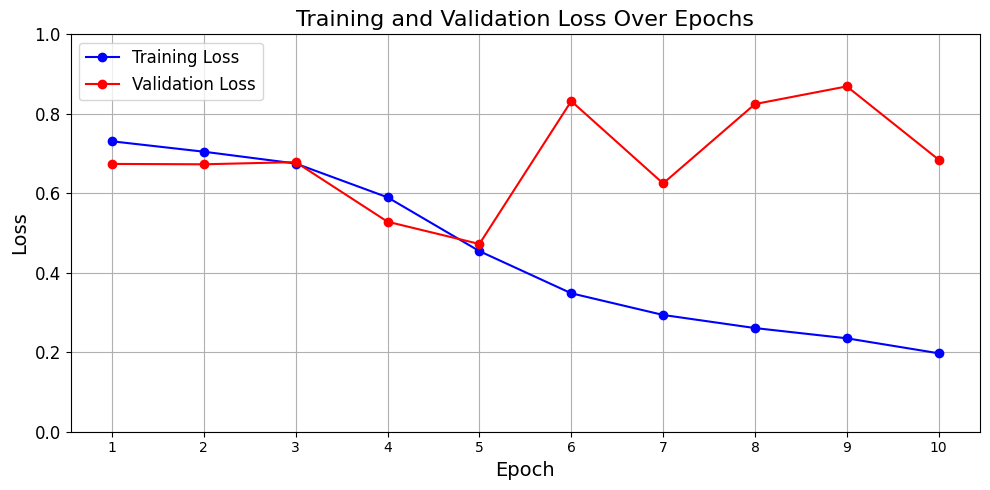

In [ ]:
def plot_loss(history_df, ymin=None, ymax=None):
    # Ensure the history_df is a DataFrame
    if not isinstance(history_df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame.")

    # Plotting training and validation loss
    plt.figure(figsize=(10, 5))  # Set the figure size for better readability
    plt.plot(history_df.index, history_df['loss'], label='Training Loss', marker='o', linestyle='-', color='blue')
    plt.plot(history_df.index, history_df['val_loss'], label='Validation Loss', marker='o', linestyle='-', color='red')

    plt.title('Training and Validation Loss Over Epochs', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.xticks(history_df.index)  # Set x-ticks to be explicit epochs
    plt.yticks(fontsize=12)       # Optional: improve readability of y-ticks
    plt.legend(fontsize=12)
    plt.grid(True)                # Enable grid to improve readability
    plt.tight_layout()            # Adjust subplots to give some padding

    # Set the limits for the y-axis if specified
    if ymin is not None or ymax is not None:
        plt.ylim([ymin, ymax])
    plt.show()

# Training history
history_model1_df = pd.DataFrame(history_model1.history)

# Reset the index to start with 1
history_model1_df.index = range(1, len(history_model1_df) + 1)

# Epochs to CSV
file_path = '/content/drive/My Drive/DS266 Project/model1_baseline.csv'
history_model1_df.to_csv(file_path, index=False)

# Calling the improved plot function
plot_loss(history_model1_df, ymin=0, ymax=1)


## Enhanced dataset

In [ ]:
# Read the CSV file
tweets_enhanced_df = pd.read_csv('train_enhanced.csv')

# Extract sentences and labels
sentences = tweets_enhanced_df['cleaned_text']
labels = tweets_enhanced_df['target']

# Setup the tokenizer and preprocess the sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
MAX_TOKENS = 30
sequences = tokenizer.texts_to_sequences(sentences)
sequences = pad_sequences(sequences, maxlen=MAX_TOKENS, padding='post')
labels = labels.to_numpy()

# Split the data into training and validation sets
sequences_train, sequences_val, labels_train, labels_val = train_test_split(
    sequences, labels, test_size=0.3, random_state=42)

# Convert to TensorFlow Datasets and batching
BUFFER_SIZE = len(sequences_train)
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((sequences_train, labels_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((sequences_val, labels_val))
val_dataset = val_dataset.batch(BATCH_SIZE)

# Inspect the dataset
print("Training batch example:", next(iter(train_dataset)))
print("Validation batch example:", next(iter(val_dataset)))


Training batch example: (<tf.Tensor: shape=(64, 30), dtype=int32, numpy=
array([[   8,    6,    7, ...,    0,    0,    0],
       [  19,  124,   10, ...,    5,    4,   47],
       [5974,   15, 5975, ...,    5,    4,   20],
       ...,
       [ 531, 3341,   38, ...,    0,    0,    0],
       [2502, 1431, 1017, ...,    5,    4,   16],
       [  10, 1334,  234, ...,    0,    0,    0]], dtype=int32)>, <tf.Tensor: shape=(64,), dtype=int64, numpy=
array([1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0])>)
Validation batch example: (<tf.Tensor: shape=(64, 30), dtype=int32, numpy=
array([[   50,    28,    41, ...,     0,     0,     0],
       [   10,  1197,    43, ...,    23,     0,     0],
       [18471, 18472,   119, ...,     0,     0,     0],
       ...,
       [    2,   594,  1984, ...,     0,     0,     0],
       [  163,    35,   612

In [ ]:
# Train the model
history_model1b = model1.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks_list)

# Specify the directory to save the model
model_dir = '/content/drive/My Drive/DS266 Project/model1_baseline_plus'

# Save as TensorFlow SavedModel
model1.save(model_dir)  # Save the model using the SavedModel format

# To confirm the save, list the contents of the directory
!ls "{model_dir}"

Epoch 1/10
84/84 [==============================] - 2s 25ms/step - loss: 0.7121 - accuracy: 0.5633 - val_loss: 0.6890 - val_accuracy: 0.5771
Epoch 2/10
84/84 [==============================] - 2s 19ms/step - loss: 0.6674 - accuracy: 0.5907 - val_loss: 0.6528 - val_accuracy: 0.6112
Epoch 3/10
84/84 [==============================] - 2s 21ms/step - loss: 0.6091 - accuracy: 0.6658 - val_loss: 0.5737 - val_accuracy: 0.7211
Epoch 4/10
84/84 [==============================] - 2s 19ms/step - loss: 0.5352 - accuracy: 0.7506 - val_loss: 0.5657 - val_accuracy: 0.7509
Epoch 5/10
84/84 [==============================] - 2s 21ms/step - loss: 0.5557 - accuracy: 0.7272 - val_loss: 0.5965 - val_accuracy: 0.7001
Epoch 6/10
84/84 [==============================] - 2s 18ms/step - loss: 0.4136 - accuracy: 0.8195 - val_loss: 0.5033 - val_accuracy: 0.7798
Epoch 7/10
84/84 [==============================] - 2s 25ms/step - loss: 0.2603 - accuracy: 0.8945 - val_loss: 0.5830 - val_accuracy: 0.7618
Epoch 8/10
84

In [ ]:
# Print model summary
print(model1.summary())

Model: "transformer_classifier_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_2 (Encoder)         multiple                  3116924   
                                                                 
 dense_14 (Dense)            multiple                  101       
                                                                 
Total params: 3117025 (11.89 MB)
Trainable params: 3117025 (11.89 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


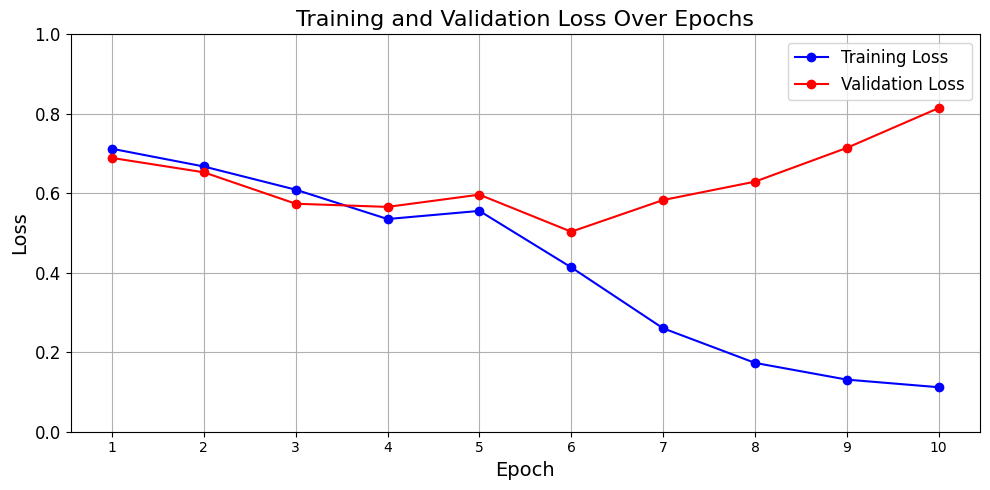

In [ ]:
# Training history
history_model1b_df = pd.DataFrame(history_model1b.history)

# Reset the index to start with 1
history_model1b_df.index = range(1, len(history_model1b_df) + 1)

file_path = '/content/drive/My Drive/DS266 Project/model1_baseline_plus.csv'

history_model1b_df.to_csv(file_path, index=False)

# Calling the improved plot function
plot_loss(history_model1b_df, ymin=0, ymax=1)


## Expanded dataset

In [ ]:
# Initialize tokenizer and constants
tokenizer = Tokenizer()
MAX_TOKENS = 30
BATCH_SIZE = 64

# Function to preprocess text data
def preprocess_data(df, text_column, target_column):
    sentences = df[text_column]
    labels = df[target_column].to_numpy()

    # Tokenize and pad sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    padded_sequences = pad_sequences(sequences, maxlen=MAX_TOKENS, padding='post')

    return padded_sequences, labels

# Function to create TensorFlow dataset
def create_dataset(sequences, labels):
    return tf.data.Dataset.from_tensor_slices((sequences, labels)).shuffle(len(sequences)).batch(BATCH_SIZE)

# Read and split train_enhanced.csv
train_enhanced_df = pd.read_csv('train_enhanced.csv')
tokenizer.fit_on_texts(train_enhanced_df['cleaned_text'])  # Fit tokenizer on initial training data

sequences, labels = preprocess_data(train_enhanced_df, 'cleaned_text', 'target')
sequences_train, sequences_val, labels_train, labels_val = train_test_split(
    sequences, labels, test_size=0.3, random_state=42)

train_dataset1 = create_dataset(sequences_train, labels_train)
val_dataset = create_dataset(sequences_val, labels_val)

# Process train_enhanced_plus.csv
train_enhanced_plus_df = pd.read_csv('train_enhanced_plus.csv')
filtered_df = train_enhanced_plus_df[train_enhanced_plus_df['source'] != 'train']  # Filter out 'train' label

# Balance the dataset by target
target_0_df = filtered_df[filtered_df['target'] == 0]
target_1_df = filtered_df[filtered_df['target'] == 1]
min_size = min(len(target_0_df), len(target_1_df))
balanced_df = pd.concat([
    target_0_df.sample(n=min_size, random_state=42),
    target_1_df.sample(n=min_size, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

sequences_plus, labels_plus = preprocess_data(balanced_df, 'cleaned_text', 'target')
train_dataset2 = create_dataset(sequences_plus, labels_plus)

# Combine train_dataset1 and train_dataset2
train_dataset = train_dataset1.concatenate(train_dataset2)

# Print example from the combined train dataset
for data in train_dataset.take(1):
    print(data)

# Print example from the validation dataset
for data in val_dataset.take(1):
    print(data)

(<tf.Tensor: shape=(64, 30), dtype=int32, numpy=
array([[18587,  2095,   588, ...,     0,     0,     0],
       [ 8778,    19,   160, ...,     0,     0,     0],
       [   10,  4239,    31, ...,     0,     0,     0],
       ...,
       [ 3505,   386,  3448, ...,     0,     0,     0],
       [13393,  2069,  5979, ...,     0,     0,     0],
       [ 1951,  1952,  1953, ...,     0,     0,     0]], dtype=int32)>, <tf.Tensor: shape=(64,), dtype=int64, numpy=
array([1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0])>)
(<tf.Tensor: shape=(64, 30), dtype=int32, numpy=
array([[ 207,  146,  161, ...,    4,   18,    0],
       [ 129,  640,   14, ...,    0,    0,    0],
       [2264, 4986,  122, ...,    5,    4,   20],
       ...,
       [  19,   49,  475, ...,    0,    0,    0],
       [  92,  586, 2652, ...,    0,    0,    0],
       [  29,  

In [ ]:
# Train the model
history_model1c = model1.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks_list)

# Specify the directory to save the model
model_dir = '/content/drive/My Drive/DS266 Project/model1_baseline_plus_plus'

# Save as TensorFlow SavedModel
model1.save(model_dir)  # Save the model using the SavedModel format

# To confirm the save, list the contents of the directory
!ls "{model_dir}"

Epoch 1/10
205/205 [==============================] - 15s 72ms/step - loss: 0.3083 - accuracy: 0.8548 - val_loss: 0.8626 - val_accuracy: 0.7005
Epoch 2/10
205/205 [==============================] - 7s 33ms/step - loss: 0.1415 - accuracy: 0.9515 - val_loss: 1.0869 - val_accuracy: 0.6957
Epoch 3/10
205/205 [==============================] - 6s 30ms/step - loss: 0.1503 - accuracy: 0.9451 - val_loss: 0.8861 - val_accuracy: 0.7246
Epoch 4/10
205/205 [==============================] - 4s 21ms/step - loss: 0.1055 - accuracy: 0.9643 - val_loss: 0.9446 - val_accuracy: 0.7110
Epoch 5/10
205/205 [==============================] - 5s 23ms/step - loss: 0.0834 - accuracy: 0.9730 - val_loss: 0.8295 - val_accuracy: 0.7561
Epoch 6/10
205/205 [==============================] - 4s 22ms/step - loss: 0.0707 - accuracy: 0.9766 - val_loss: 1.0020 - val_accuracy: 0.7491
Epoch 7/10
205/205 [==============================] - 4s 21ms/step - loss: 0.0717 - accuracy: 0.9767 - val_loss: 1.1491 - val_accuracy: 0.719

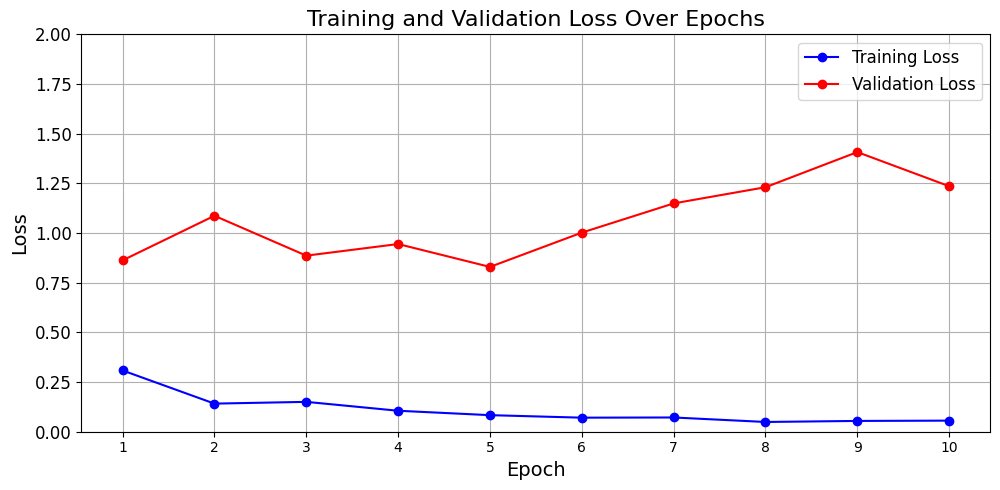

In [ ]:
# Training history
history_model1c_df = pd.DataFrame(history_model1c.history)

# Reset the index to start with 1
history_model1c_df.index = range(1, len(history_model1c_df) + 1)

file_path = '/content/drive/My Drive/DS266 Project/model1_baseline_plus_plus.csv'

history_model1c_df.to_csv(file_path, index=False)

# Calling the improved plot function
plot_loss(history_model1c_df, ymin=0, ymax=2)

# Model 2: Learnable Positional Encodings

In [18]:
# PositionalEmbedding with trainable positional encodings
class PositionalEmbedding(tf.keras.layers.Layer):
    """Custom Keras layer that integrates trainable positional encodings with token embeddings.

      This layer first creates an embedding matrix for the vocabulary and then adds trainable positional
      encodings to the token embeddings. The idea is to allow the model to learn the optimal positional
      encodings along with learning the token embeddings, which could provide more flexibility and
      potentially better performance for certain datasets or problems.

      Args:
          vocab_size (int): Size of the vocabulary. This determines the number of rows in the embedding matrix.
          d_model (int): The dimensionality of the embeddings. Each token is transformed into a vector of this size.
          maxlen (int): The maximum length of input sequences this embedding layer will be used with. This defines
                        the size of the positional encoding matrix, ensuring it can handle sequences up to this length.

      Attributes:
          d_model (int): Stored dimensionality of the embeddings, used for scaling the embeddings.
          embedding (tf.keras.layers.Embedding): The embedding layer that transforms token indices into embeddings.
          pos_encoding (tf.Variable): Trainable positional encodings added to token embeddings. Initialized with
                                      random values and learned during training.
      """
    def __init__(self, vocab_size, d_model, maxlen=2048):
        super(PositionalEmbedding, self).__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        self.pos_encoding = self.add_weight("pos_encoding", shape=[maxlen, d_model], initializer="random_normal", trainable=True)

    def call(self, x):
      """Adds positional encoding to token embeddings.

        This method retrieves embeddings for input tokens and adds learned positional encodings
        to these embeddings. The embeddings are also scaled by the square root of the model's
        dimensionality, a common practice to help stabilize the learning.

        Args:
            x (tf.Tensor): Input tensor containing token indices of shape (batch_size, sequence_length).

        Returns:
            tf.Tensor: Output tensor of the same shape as `x` but with embeddings that now include
                        positional information. The shape is (batch_size, sequence_length, d_model).
        """
      length = tf.shape(x)[1] # Determine the sequence length of the current batch.
      x = self.embedding(x) * tf.math.sqrt(tf.cast(self.d_model, tf.float32)) # Lookup token embeddings.
      x += self.pos_encoding[:length, :] # Add the appropriate positional encodings up to the current sequence length.
      return x


# BaseAttention layer extended for self-attention mechanism
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x):
        attn_output = self.mha(query=x, value=x, key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output, attn_scores = self.mha(
        query=x,
        value=x,
        key=x,
        return_attention_scores=True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    return x


class FeedForward(tf.keras.layers.Layer):
    """Defines a feed-forward network layer which is used in the transformer.

      This class creates a two-layer neural network with a ReLU activation in between,
      followed by dropout for regularization, and a residual connection around the network.

      Args:
          d_model (int): Dimensionality of the input and output.
          dff (int): Dimensionality of the inner layer.
          dropout_rate (float): Dropout rate.

      Attributes:
          seq (tf.keras.Sequential): Sequential model performing the feed-forward operation.
          add (tf.keras.layers.Add): Layer to perform the addition in the residual connection.
          layer_norm (tf.keras.layers.LayerNormalization): Layer to normalize the data.
      """
    def __init__(self, d_model, dff, dropout_rate=0.1):
      super().__init__()
      self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # First dense layer with ReLU
        tf.keras.layers.Dense(d_model),                 # Second dense layer
        tf.keras.layers.Dropout(dropout_rate)           # Dropout for regularization
      ])
      self.add = tf.keras.layers.Add()
      self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
      """Applies the feed-forward network to x with a residual connection followed by layer normalization.

          Args:
              x (tf.Tensor): Input tensor.

          Returns:
              tf.Tensor: Normalized output tensor.
          """
      x = self.add([x, self.seq(x)])  # Apply residual connection
      x = self.layer_norm(x)          # Normalize the output
      return x

# EncoderLayer combining self-attention and FeedForward
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.self_attention = GlobalSelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

# Encoder comprising multiple EncoderLayers
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super().__init__()
        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.enc_layers = [EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        x = self.pos_embedding(x)
        x = self.dropout(x)
        for layer in self.enc_layers:
            x = layer(x)
        return x

# Transformer classifier model
class TransformerClassifier(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff, input_vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, vocab_size=input_vocab_size, dropout_rate=dropout_rate)
        self.final_layer = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        context = self.encoder(inputs)
        logits = self.final_layer(context[:, -1, :])  # Take last hidden state
        return logits

# Define the learning rate scheduler
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)  # Ensure d_model is a float
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)  # Ensure warmup_steps is a float

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Cast step to float32 to ensure compatibility
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        # Ensure division by sqrt of d_model
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        return {
            "d_model": self.d_model.numpy(),  # Return python float
            "warmup_steps": self.warmup_steps.numpy()  # Return python float
        }

# Instantiate the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=CustomSchedule(d_model=100),
                                     beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Instantiate the transformer model
model2 = TransformerClassifier(
    num_layers=2,
    d_model=100,
    num_heads=8,
    dff=512,
    input_vocab_size=max(tokenizer.word_index.values()) + 1,
    dropout_rate=0.2)

# Compile model
model2.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
    run_eagerly=False)

# Define checkpointing
checkpoint_dir = './model_checkpoints/'
checkpoint_filepath = checkpoint_dir + 'tx_w_embeddings_cl2.{epoch:02d}-{val_accuracy:.2f}'

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )]


## Training

In [19]:
# Train the model
history_model2 = model2.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks_list)

# Specify the directory to save the model
model_dir = '/content/drive/My Drive/DS266 Project/model2_learnable_encodings'

# Save as TensorFlow SavedModel
model2.save(model_dir)  # Save the model using the SavedModel format

# To confirm the save, list the contents of the directory
!ls "{model_dir}"

Epoch 1/10
84/84 [==============================] - 20s 145ms/step - loss: 0.7525 - accuracy: 0.5241 - val_loss: 0.6698 - val_accuracy: 0.5622
Epoch 2/10
84/84 [==============================] - 7s 81ms/step - loss: 0.6915 - accuracy: 0.5735 - val_loss: 0.6387 - val_accuracy: 0.6243
Epoch 3/10
84/84 [==============================] - 4s 47ms/step - loss: 0.6141 - accuracy: 0.6658 - val_loss: 0.5536 - val_accuracy: 0.7207
Epoch 4/10
84/84 [==============================] - 4s 49ms/step - loss: 0.4681 - accuracy: 0.7865 - val_loss: 0.4920 - val_accuracy: 0.7802
Epoch 5/10
84/84 [==============================] - 2s 27ms/step - loss: 0.3413 - accuracy: 0.8536 - val_loss: 0.5522 - val_accuracy: 0.7399
Epoch 6/10
84/84 [==============================] - 3s 35ms/step - loss: 0.2572 - accuracy: 0.8979 - val_loss: 0.5829 - val_accuracy: 0.7675
Epoch 7/10
84/84 [==============================] - 2s 23ms/step - loss: 0.1888 - accuracy: 0.9259 - val_loss: 0.6189 - val_accuracy: 0.7859
Epoch 8/10


In [ ]:
# Print model summary
print(model2.summary())

Model: "transformer_classifier_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_3 (Encoder)         multiple                  3321724   
                                                                 
 dense_19 (Dense)            multiple                  101       
                                                                 
Total params: 3321825 (12.67 MB)
Trainable params: 3321825 (12.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## Performance

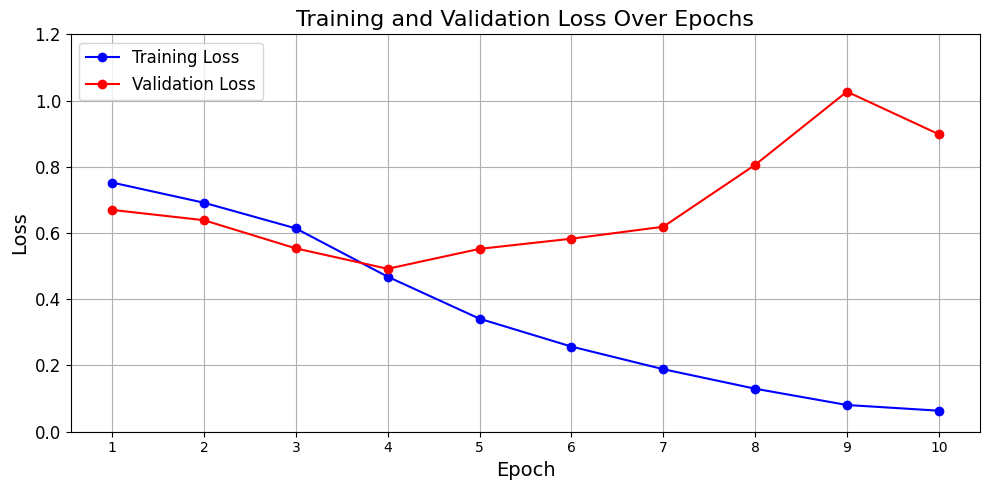

In [21]:
# Training history
history_model2_df = pd.DataFrame(history_model2.history)

# Reset the index to start with 1
history_model2_df.index = range(1, len(history_model2_df) + 1)

file_path = '/content/drive/My Drive/DS266 Project/model2_learnable_encodings.csv'

history_model2_df.to_csv(file_path, index=False)

# Calling the improved plot function
plot_loss(history_model2_df, ymin=0, ymax=1.2)

# Model 3: Local Attention

In [ ]:
# Define model components
def positional_encoding(length, depth):
  depth = depth/2
  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)
  pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
  return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(tf.keras.layers.Layer):
  """Custom Keras layer that integrates positional encodings with embeddings.

    This layer creates an embedding matrix for the vocabulary and adds positional
    encoding to inject some information about the relative or absolute position
    of the tokens in the sequence. The positional encodings have the same dimension
    as the embeddings, allowing the two to be summed.

    Args:
        vocab_size (int): Size of the vocabulary.
        d_model (int): Dimensionality of the embeddings.

    Attributes:
        d_model (int): Stored dimensionality of the model used in scaling calculations.
        embedding (tf.keras.layers.Embedding): Embedding layer for the tokens.
        pos_encoding (tf.Tensor): Precomputed positional encodings.
    """
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    """Generates a mask for padding tokens. This mask is then used to ignore these tokens."""
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    """Performs the embedding lookup and adds the positional encoding.

        Args:
            x (tf.Tensor): Tensor of token indices.

        Returns:
            tf.Tensor: Embedded and positionally encoded tensor.
        """
    length = tf.shape(x)[1]
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) # Scale embeddings
    x = x + self.pos_encoding[tf.newaxis, :length, :] # Add positional encoding
    return x

class LocalAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, window_size, **kwargs):
        super(LocalAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        self.window_size = window_size

        self.Wq = tf.keras.layers.Dense(d_model)
        self.Wk = tf.keras.layers.Dense(d_model)
        self.Wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        # Split the last dimension into (num_heads, depth)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        # Transpose the result such that the shape is (batch_size, num_heads, seq_length, depth)
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q):
        batch_size = tf.shape(q)[0]
        q = self.split_heads(self.Wq(q), batch_size)
        k = self.split_heads(self.Wk(k), batch_size)
        v = self.split_heads(self.Wv(v), batch_size)

        # Ensure the windowing and transpose operations are compatible with the expected tensor ranks
        # Example simple attention score calculation without padding or windowing for simplicity
        scores = tf.matmul(q, k, transpose_b=True)
        scores /= tf.math.sqrt(tf.cast(self.depth, tf.float32))
        weights = tf.nn.softmax(scores, axis=-1)

        attention_output = tf.matmul(weights, v)
        attention_output = tf.transpose(attention_output, perm=[0, 2, 1, 3])
        attention_output = tf.reshape(attention_output, (batch_size, -1, self.num_heads * self.depth))

        return self.dense(attention_output)

class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x):
        attn_output = self.mha(query=x, value=x, key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output, attn_scores = self.mha(
        query=x,
        value=x,
        key=x,
        return_attention_scores=True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    return x

# FeedForward network
class FeedForward(tf.keras.layers.Layer):
  """Defines a feed-forward network layer which is used in the transformer.

    This class creates a two-layer neural network with a ReLU activation in between,
    followed by dropout for regularization, and a residual connection around the network.

    Args:
        d_model (int): Dimensionality of the input and output.
        dff (int): Dimensionality of the inner layer.
        dropout_rate (float): Dropout rate.

    Attributes:
        seq (tf.keras.Sequential): Sequential model performing the feed-forward operation.
        add (tf.keras.layers.Add): Layer to perform the addition in the residual connection.
        layer_norm (tf.keras.layers.LayerNormalization): Layer to normalize the data.
    """
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # First dense layer with ReLU
      tf.keras.layers.Dense(d_model),                 # Second dense layer
      tf.keras.layers.Dropout(dropout_rate)           # Dropout for regularization
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    """Applies the feed-forward network to x with a residual connection followed by layer normalization.

        Args:
            x (tf.Tensor): Input tensor.

        Returns:
            tf.Tensor: Normalized output tensor.
        """
    x = self.add([x, self.seq(x)])  # Apply residual connection
    x = self.layer_norm(x)          # Normalize the output
    return x

# EncoderLayer combining self-attention and FeedForward
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1, use_local_attention=False):
        super().__init__()
        self.use_local_attention = use_local_attention
        if self.use_local_attention:
            self.local_attention = LocalAttention(d_model=d_model, num_heads=num_heads, window_size=5)  # Adjust window_size as needed
        else:
            self.self_attention = GlobalSelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
        self.ffn = FeedForward(d_model, dff, dropout_rate=dropout_rate)

    def call(self, x):
        if self.use_local_attention:
            x = self.local_attention(x, x, x)  # Assuming Q, K, V are all x
        else:
            x = self.self_attention(x)
        x = self.ffn(x)
        return x

# Encoder comprising multiple EncoderLayers
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1, use_local_attention=True):
        super().__init__()
        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.enc_layers = [EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, use_local_attention=use_local_attention) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        x = self.pos_embedding(x)
        x = self.dropout(x)
        for layer in self.enc_layers:
            x = layer(x)
        return x

# Transformer classifier model
class TransformerClassifier(tf.keras.Model):
  """Transformer model for classification tasks.

    This class encapsulates the entire Transformer model tailored for a binary classification task.
    It includes an encoder and a final dense layer with a sigmoid activation function to produce a probability.

    Args:
        num_layers (int): Number of layers in the encoder.
        d_model (int): Dimensionality of the input and output of the encoder.
        num_heads (int): Number of attention heads in each encoder layer.
        dff (int): Dimensionality of the feed-forward network's inner layer.
        input_vocab_size (int): Size of the input vocabulary.
        dropout_rate (float): Dropout rate used throughout the encoder.

    Attributes:
        encoder (Encoder): The Transformer's encoder.
        final_layer (tf.keras.layers.Dense): Final dense layer used for binary classification.
    """
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, dropout_rate=0.1, use_local_attention=False):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate,
                           use_local_attention=use_local_attention)

    self.final_layer = tf.keras.layers.Dense(1, activation='sigmoid')

  def call(self, inputs):
    """Processes inputs through the encoder and the final dense layer.

        Args:
            inputs (tf.Tensor): Input tensor to the model.

        Returns:
            tf.Tensor: Output tensor representing the probability of the positive class.
        """
    context = inputs
    context = self.encoder(context)  # (batch_size, context_len, d_model)
    logits = self.final_layer(context[:, -1, :])  # Use the last hidden state
    return logits

# Create the model instance
model3 = TransformerClassifier(
    num_layers=2,
    d_model=128,
    num_heads=8,
    dff=512,
    input_vocab_size=max(tokenizer.word_index.values()) + 1,
    dropout_rate=0.1,
    use_local_attention=True)

# Define the learning rate scheduler
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)  # Ensure d_model is a float
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)  # Ensure warmup_steps is a float

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Cast step to float32 to ensure compatibility
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        # Ensure division by sqrt of d_model
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        return {
            "d_model": self.d_model.numpy(),  # Return python float
            "warmup_steps": self.warmup_steps.numpy()  # Return python float
        }

# Instantiate the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=CustomSchedule(d_model=128),
                                     beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Compile model
model3.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
    run_eagerly=False)

# Define checkpointing
checkpoint_dir = './model_checkpoints/'
checkpoint_filepath = checkpoint_dir + 'tx_w_embeddings_cl2.{epoch:02d}-{val_accuracy:.2f}'

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )]


## Training

In [ ]:
# Start training
history_model3 = model3.fit(train_dataset, epochs=10, validation_data=val_dataset)

# Specify the directory to save the model
model_dir = '/content/drive/My Drive/DS266 Project/model3_local_attention'

# Save as TensorFlow SavedModel
model3.save(model_dir)  # Save the model using the SavedModel format

# To confirm the save, list the contents of the directory
!ls "{model_dir}"

Epoch 1/10
84/84 [==============================] - 13s 86ms/step - loss: 0.7968 - accuracy: 0.5038 - val_loss: 0.6751 - val_accuracy: 0.5609
Epoch 2/10
84/84 [==============================] - 4s 44ms/step - loss: 0.6677 - accuracy: 0.5797 - val_loss: 0.6483 - val_accuracy: 0.6200
Epoch 3/10
84/84 [==============================] - 3s 39ms/step - loss: 0.6043 - accuracy: 0.6701 - val_loss: 0.5594 - val_accuracy: 0.7176
Epoch 4/10
84/84 [==============================] - 2s 23ms/step - loss: 0.4735 - accuracy: 0.7797 - val_loss: 0.5119 - val_accuracy: 0.7728
Epoch 5/10
84/84 [==============================] - 2s 22ms/step - loss: 0.3811 - accuracy: 0.8334 - val_loss: 0.4973 - val_accuracy: 0.7877
Epoch 6/10
84/84 [==============================] - 1s 16ms/step - loss: 0.2846 - accuracy: 0.8837 - val_loss: 0.5691 - val_accuracy: 0.7325
Epoch 7/10
84/84 [==============================] - 1s 17ms/step - loss: 0.2257 - accuracy: 0.9082 - val_loss: 0.5597 - val_accuracy: 0.7920
Epoch 8/10
8

In [ ]:
# Print model summary
print(model3.summary())

Model: "transformer_classifier_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_5 (Encoder)         multiple                  3295360   
                                                                 
 dense_45 (Dense)            multiple                  129       
                                                                 
Total params: 3295489 (12.57 MB)
Trainable params: 3295489 (12.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## Performance

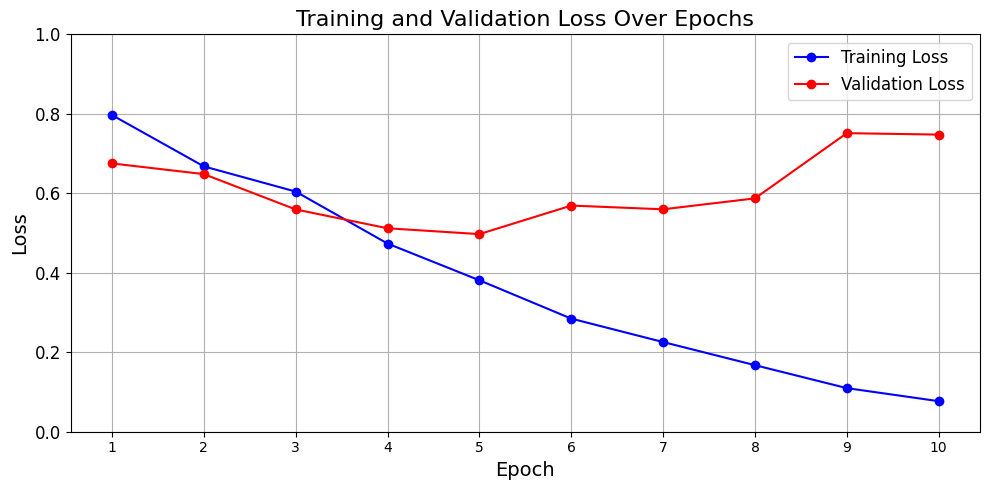

In [ ]:
# Training history
history_model3_df = pd.DataFrame(history_model3.history)

# Reset the index to start with 1
history_model3_df.index = range(1, len(history_model3_df) + 1)

# Save DataFrame as CSV
file_path = '/content/drive/My Drive/DS266 Project/model3_local_attention.csv'

history_model3_df.to_csv(file_path, index=False)

# Calling the improved plot function
plot_loss(history_model3_df, ymin=0, ymax=1)


# Model 4: Adaptive Attention Span

In [ ]:
def positional_encoding(length, d_model):
    # Generate positional encodings with proper depth handling
    angle_rads = np.arange(length)[:, np.newaxis] * (1 / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / d_model))
    # Apply sine to even indices in the array; 2i
    sines = np.sin(angle_rads[:, 0::2])
    # Apply cosine to odd indices in the array; 2i+1
    cosines = np.cos(angle_rads[:, 1::2])
    pos_encoding = np.concatenate([sines, cosines], axis=-1)
    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(2048, d_model)  # Precomputed for max length

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))  # Scale embeddings
        # Add positional encoding up to the actual sequence length
        x += self.pos_encoding[:length, :]
        return x

class MinMaxValueConstraint(tf.keras.constraints.Constraint):
    """Ensures weights are within [min_value, max_value]."""
    def __init__(self, min_value, max_value):
        self.min_value = min_value
        self.max_value = max_value

    def __call__(self, w):
        return tf.clip_by_value(w, self.min_value, self.max_value)

class AdaptiveAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, max_tokens):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        if d_model % num_heads != 0:
            raise ValueError("d_model must be divisible by num_heads")
        self.max_tokens = max_tokens

        self.WQ = tf.keras.layers.Dense(d_model)
        self.WK = tf.keras.layers.Dense(d_model)
        self.WV = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        # Calculate the new shape to split the heads
        new_shape = (batch_size, -1, self.num_heads, self.depth)
        x = tf.reshape(x, new_shape)
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v, mask=None):
        batch_size = tf.shape(q)[0]
        q = self.WQ(q)
        k = self.WK(k)
        v = self.WV(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        output = tf.reshape(output, (batch_size, -1, self.d_model))
        return output

# BaseAttention layer extended for self-attention mechanism
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x):
        attn_output = self.mha(query=x, value=x, key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output, attn_scores = self.mha(
        query=x,
        value=x,
        key=x,
        return_attention_scores=True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    return x

# FeedForward network with residual connection
class FeedForward(tf.keras.layers.Layer):
  """Defines a feed-forward network layer which is used in the transformer.

    This class creates a two-layer neural network with a ReLU activation in between,
    followed by dropout for regularization, and a residual connection around the network.

    Args:
        d_model (int): Dimensionality of the input and output.
        dff (int): Dimensionality of the inner layer.
        dropout_rate (float): Dropout rate.

    Attributes:
        seq (tf.keras.Sequential): Sequential model performing the feed-forward operation.
        add (tf.keras.layers.Add): Layer to perform the addition in the residual connection.
        layer_norm (tf.keras.layers.LayerNormalization): Layer to normalize the data.
    """
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # First dense layer with ReLU
      tf.keras.layers.Dense(d_model),                 # Second dense layer
      tf.keras.layers.Dropout(dropout_rate)           # Dropout for regularization
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    """Applies the feed-forward network to x with a residual connection followed by layer normalization.

        Args:
            x (tf.Tensor): Input tensor.

        Returns:
            tf.Tensor: Normalized output tensor.
        """
    x = self.add([x, self.seq(x)])  # Apply residual connection
    x = self.layer_norm(x)          # Normalize the output
    return x

# EncoderLayer combining self-attention and FeedForward
class EncoderLayer(tf.keras.layers.Layer):
    """Single encoder layer consisting of attention and feed-forward network.

    Args:
        d_model (int): Dimensionality of the input and output.
        num_heads (int): Number of attention heads.
        dff (int): Dimensionality of the feed-forward network's inner layer.
        dropout_rate (float): Dropout rate used in the attention layer.
        max_tokens (int): Maximum length of input sequences for adaptive attention.
        use_adaptive_attention (bool): Flag to use adaptive attention instead of global self-attention.
    """
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1, max_tokens=2048, use_adaptive_attention=False):
        super().__init__()
        if use_adaptive_attention:
            self.attention = AdaptiveAttentionLayer(d_model=d_model, num_heads=num_heads, max_tokens=max_tokens)
        else:
            self.attention = GlobalSelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
        self.ffn = FeedForward(d_model, dff, dropout_rate=dropout_rate)

    def call(self, x):
        x = self.attention(x, x, x)  # Assuming Q, K, V are all x for simplicity
        x = self.ffn(x)
        return x

# Encoder comprising multiple EncoderLayers
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1, use_adaptive_attention=False):
        super().__init__()
        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.enc_layers = [
            EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate,
                         use_adaptive_attention=use_adaptive_attention) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        x = self.pos_embedding(x)
        x = self.dropout(x)
        for layer in self.enc_layers:
            x = layer(x)
        return x

# Transformer classifier model
class TransformerClassifier(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff, input_vocab_size, dropout_rate=0.1, use_adaptive_attention=False):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff,
                               vocab_size=input_vocab_size, dropout_rate=dropout_rate,
                               use_adaptive_attention=use_adaptive_attention)
        self.final_layer = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        context = self.encoder(inputs)
        logits = self.final_layer(context[:, -1, :])
        return logits

# Create the model instance
model4 = TransformerClassifier(
    num_layers=2,
    d_model=100,
    num_heads=5,
    dff=512,
    input_vocab_size=max(tokenizer.word_index.values()) + 1,
    dropout_rate=0.1,
    use_adaptive_attention=True)

# Define the learning rate scheduler
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)  # Ensure d_model is a float
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)  # Ensure warmup_steps is a float

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Cast step to float32 to ensure compatibility
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        # Ensure division by sqrt of d_model
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        return {
            "d_model": self.d_model.numpy(),  # Return python float
            "warmup_steps": self.warmup_steps.numpy()  # Return python float
        }

# Instantiate the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=CustomSchedule(d_model=100),
                                     beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Compile the model
model4.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
    run_eagerly=False)

# Define callbacks for checkpointing
checkpoint_dir = './model_checkpoints/'
checkpoint_filepath = checkpoint_dir + 'tx_w_embeddings_cl2.{epoch:02d}-{val_accuracy:.2f}'

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )]


## Training

In [ ]:
# Start training
history_model4 = model4.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks_list)

# Specify the directory to save the model
model_dir = '/content/drive/My Drive/DS266 Project/model4_adaptive_attention_span'

# Save as TensorFlow SavedModel
model4.save(model_dir)  # Save the model using the SavedModel format

# To confirm the save, list the contents of the directory
!ls "{model_dir}"

Epoch 1/10
84/84 [==============================] - 13s 89ms/step - loss: 0.7943 - accuracy: 0.4871 - val_loss: 0.6722 - val_accuracy: 0.5771
Epoch 2/10
84/84 [==============================] - 4s 49ms/step - loss: 0.6658 - accuracy: 0.5855 - val_loss: 0.6392 - val_accuracy: 0.6388
Epoch 3/10
84/84 [==============================] - 2s 29ms/step - loss: 0.6188 - accuracy: 0.6673 - val_loss: 0.5738 - val_accuracy: 0.7075
Epoch 4/10
84/84 [==============================] - 2s 28ms/step - loss: 0.4947 - accuracy: 0.7647 - val_loss: 0.5077 - val_accuracy: 0.7469
Epoch 5/10
84/84 [==============================] - 2s 27ms/step - loss: 0.3839 - accuracy: 0.8304 - val_loss: 0.4817 - val_accuracy: 0.7973
Epoch 6/10
84/84 [==============================] - 2s 19ms/step - loss: 0.2993 - accuracy: 0.8761 - val_loss: 0.5237 - val_accuracy: 0.7947
Epoch 7/10
84/84 [==============================] - 2s 22ms/step - loss: 0.2176 - accuracy: 0.9141 - val_loss: 0.5316 - val_accuracy: 0.8004
Epoch 8/10
8

NameError: name 'model14' is not defined

In [ ]:
# Print model summary
print(model4.summary())

Model: "transformer_classifier_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_6 (Encoder)         multiple                  2532124   
                                                                 
 dense_56 (Dense)            multiple                  101       
                                                                 
Total params: 2532225 (9.66 MB)
Trainable params: 2532225 (9.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## Performance

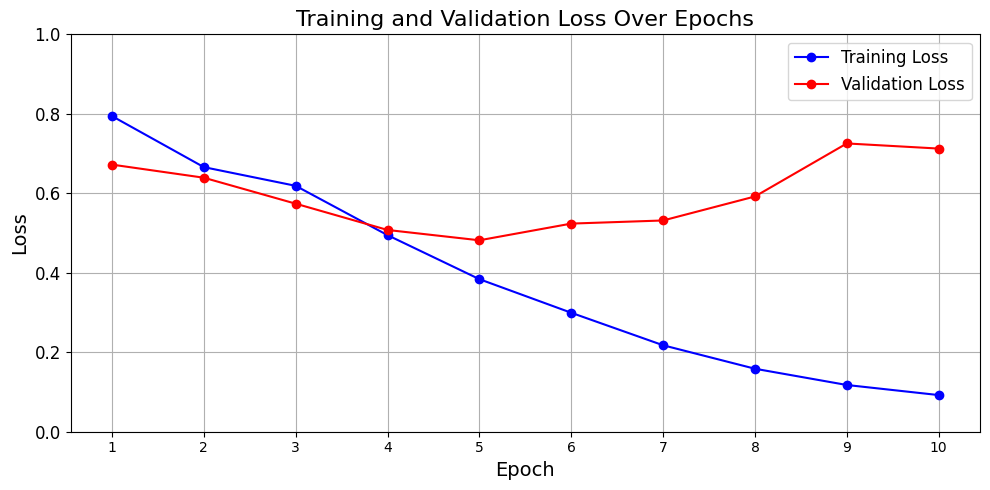

In [ ]:
# Training history
history_model4_df = pd.DataFrame(history_model4.history)

# Reset the index to start with 1
history_model4_df.index = range(1, len(history_model4_df) + 1)

# Save DataFrame as CSV
file_path = '/content/drive/My Drive/DS266 Project/model4_adaptive_attention.csv'

history_model4_df.to_csv(file_path, index=False)

# Calling the improved plot function
plot_loss(history_model4_df, ymin=0, ymax=1)

# Model 5: Implementing Custom Regularization

In [ ]:
# PositionalEmbedding layer
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model, maxlen=30):
        super(PositionalEmbedding, self).__init__()
        self.d_model = d_model
        regularizer = tf.keras.regularizers.l1_l2(l1=10**-3.093, l2=10**-3.56)
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, embeddings_regularizer=regularizer)
        self.pos_encoding = self.add_weight("pos_encoding", shape=[maxlen, d_model], initializer="random_normal", trainable=True)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x) * tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:length, :]
        return x

class AdaptiveAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, max_tokens):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // self.num_heads
        self.max_tokens = max_tokens

        # Define L1 and L2 regularization
        regularizer = tf.keras.regularizers.l1_l2(l1=10**-3.093, l2=10**-3.56)

        # Initialize layers for projecting inputs to queries, keys, and values with regularization
        self.WQ = tf.keras.layers.Dense(d_model, kernel_regularizer=regularizer)
        self.WK = tf.keras.layers.Dense(d_model, kernel_regularizer=regularizer)
        self.WV = tf.keras.layers.Dense(d_model, kernel_regularizer=regularizer)

    def split_heads(self, x, batch_size):
        # Split the last dimension into (num_heads, depth)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v):
        batch_size = tf.shape(q)[0]
        q = self.WQ(q)
        k = self.WK(k)
        v = self.WV(v)

        # Split the heads
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # Scaled dot-product attention
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        output = tf.reshape(output, (batch_size, -1, self.d_model))
        return output

# BaseAttention layer
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim):
        super().__init__()
        regularizer = tf.keras.regularizers.l1_l2(l1=10**-3.093, l2=10**-3.56)
        # Explicitly pass num_heads and key_dim to MultiHeadAttention
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()
        self.dense = tf.keras.layers.Dense(key_dim, kernel_regularizer=regularizer)

    def call(self, x):
        attn_output = self.mha(query=x, value=x, key=x)
        attn_output = self.dense(attn_output)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class GlobalSelfAttention(BaseAttention):
  def __init__(self, num_heads, key_dim):
        super().__init__(num_heads=num_heads, key_dim=key_dim)

  def call(self, x):
    attn_output, attn_scores = self.mha(
        query=x,
        value=x,
        key=x,
        return_attention_scores=True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    return x

# FeedForward network
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        regularizer = tf.keras.regularizers.l1_l2(l1=10**-3.093, l2=10**-3.56)
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu', kernel_regularizer=regularizer),
            tf.keras.layers.Dense(d_model, kernel_regularizer=regularizer),
            tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()
    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

# EncoderLayer
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate):
        super().__init__()
        self.self_attention = GlobalSelfAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = FeedForward(d_model, dff, dropout_rate=dropout_rate)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

# Encoder
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate, regularizer=None):
        super().__init__()
        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model, maxlen=30)
        self.enc_layers = [EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        x = self.pos_embedding(x)
        x = self.dropout(x)
        for layer in self.enc_layers:
            x = layer(x)
        return x

# Define the Transformer model using AdaptiveAttentionLayer
class TransformerModel(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, max_tokens, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, vocab_size=input_vocab_size, dropout_rate=dropout_rate)
        self.adaptive_attention = AdaptiveAttentionLayer(d_model=d_model, num_heads=num_heads, max_tokens=max_tokens)
        self.final_layer = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.encoder(inputs)
        x = self.adaptive_attention(x, x, x)  # Self-attention mechanism
        x = self.final_layer(x[:, -1, :])  # Take last hidden state
        return x

# Create and compile the model instance
model5 = TransformerModel(
    num_layers=2,
    d_model=100,
    num_heads=5,
    dff=512,
    input_vocab_size=max(tokenizer.word_index.values()) + 1,
    max_tokens=30,
    dropout_rate=0.1
)

# Define the learning rate scheduler
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)  # Ensure d_model is a float
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)  # Ensure warmup_steps is a float

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Cast step to float32 to ensure compatibility
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        # Ensure division by sqrt of d_model
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        return {
            "d_model": self.d_model.numpy(),  # Return python float
            "warmup_steps": self.warmup_steps.numpy()  # Return python float
        }

optimizer = tf.keras.optimizers.Adam(learning_rate=CustomSchedule(d_model=100),
                                     beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Compile the model
model5.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
    run_eagerly=False)

# Define callbacks for checkpointing
checkpoint_dir = './model_checkpoints/'
checkpoint_filepath = checkpoint_dir + 'tx_w_embeddings_cl2.{epoch:02d}-{val_accuracy:.2f}'

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )]


## Training

In [ ]:
# Train the model
history_model5 = model5.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks_list)

# Specify the directory to save the model
model_dir = '/content/drive/My Drive/DS266 Project/model5_implementing_custom_regularization'

# Save as TensorFlow SavedModel
model5.save(model_dir)  # Save the model using the SavedModel format

# To confirm the save, list the contents of the directory
!ls "{model_dir}"

Epoch 1/10
84/84 [==============================] - 10s 29ms/step - loss: 56.6240 - accuracy: 0.5478 - val_loss: 54.8763 - val_accuracy: 0.6033
Epoch 2/10
84/84 [==============================] - 2s 20ms/step - loss: 51.6831 - accuracy: 0.6134 - val_loss: 47.6064 - val_accuracy: 0.6743
Epoch 3/10
84/84 [==============================] - 2s 20ms/step - loss: 42.6192 - accuracy: 0.6889 - val_loss: 37.0021 - val_accuracy: 0.7434
Epoch 4/10
84/84 [==============================] - 2s 20ms/step - loss: 31.2923 - accuracy: 0.7634 - val_loss: 25.4748 - val_accuracy: 0.7758
Epoch 5/10
84/84 [==============================] - 2s 20ms/step - loss: 20.3057 - accuracy: 0.8150 - val_loss: 15.6107 - val_accuracy: 0.7916
Epoch 6/10
84/84 [==============================] - 2s 19ms/step - loss: 12.1056 - accuracy: 0.8763 - val_loss: 9.7993 - val_accuracy: 0.7680
Epoch 7/10
84/84 [==============================] - 2s 20ms/step - loss: 8.2590 - accuracy: 0.9112 - val_loss: 7.6758 - val_accuracy: 0.7802
E

assets	fingerprint.pb	keras_metadata.pb  saved_model.pb  variables


In [ ]:
# Print model summary
print(model5.summary())

Model: "transformer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_7 (Encoder)         multiple                  2878124   
                                                                 
 adaptive_attention_layer_2  multiple                  30300     
  (AdaptiveAttentionLayer)                                       
                                                                 
 dense_66 (Dense)            multiple                  101       
                                                                 
Total params: 2908525 (11.10 MB)
Trainable params: 2908525 (11.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## Performance

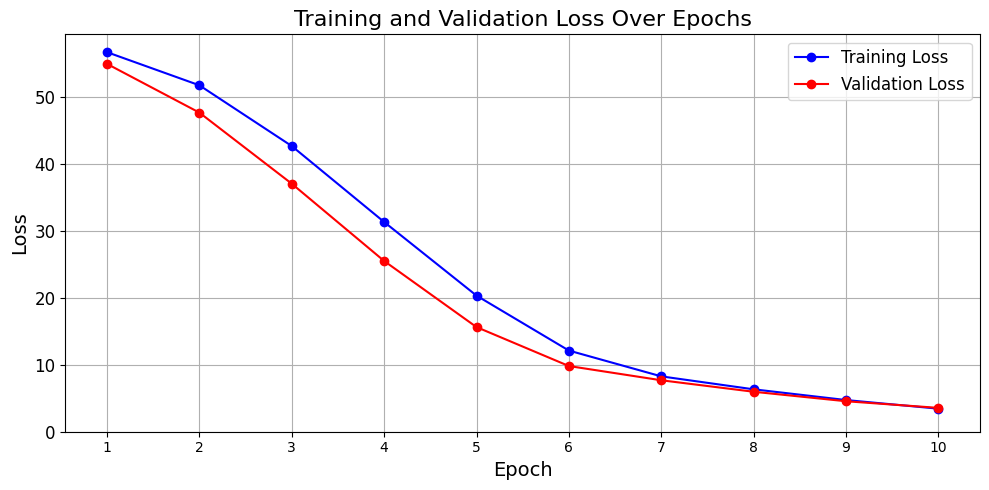

In [ ]:
# Training history
history_model5_df = pd.DataFrame(history_model5.history)

# Reset the index to start with 1
history_model5_df.index = range(1, len(history_model5_df) + 1)

# Save DataFrame as CSV
file_path = '/content/drive/My Drive/DS266 Project/model5_custom_regularization.csv'

history_model5_df.to_csv(file_path, index=False)

# Calling the improved plot function
plot_loss(history_model5_df, ymin=0, ymax=None)

# Model 6: LPE + AAS

In [9]:
# PositionalEmbedding with trainable positional encodings
class PositionalEmbedding(tf.keras.layers.Layer):
    """Custom Keras layer that integrates trainable positional encodings with token embeddings.

      This layer first creates an embedding matrix for the vocabulary and then adds trainable positional
      encodings to the token embeddings. The idea is to allow the model to learn the optimal positional
      encodings along with learning the token embeddings, which could provide more flexibility and
      potentially better performance for certain datasets or problems.

      Args:
          vocab_size (int): Size of the vocabulary. This determines the number of rows in the embedding matrix.
          d_model (int): The dimensionality of the embeddings. Each token is transformed into a vector of this size.
          maxlen (int): The maximum length of input sequences this embedding layer will be used with. This defines
                        the size of the positional encoding matrix, ensuring it can handle sequences up to this length.

      Attributes:
          d_model (int): Stored dimensionality of the embeddings, used for scaling the embeddings.
          embedding (tf.keras.layers.Embedding): The embedding layer that transforms token indices into embeddings.
          pos_encoding (tf.Variable): Trainable positional encodings added to token embeddings. Initialized with
                                      random values and learned during training.
      """
    def __init__(self, vocab_size, d_model, maxlen=2048):
        super(PositionalEmbedding, self).__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        self.pos_encoding = self.add_weight("pos_encoding", shape=[maxlen, d_model], initializer="random_normal", trainable=True)

    def call(self, x):
      """Adds positional encoding to token embeddings.

        This method retrieves embeddings for input tokens and adds learned positional encodings
        to these embeddings. The embeddings are also scaled by the square root of the model's
        dimensionality, a common practice to help stabilize the learning.

        Args:
            x (tf.Tensor): Input tensor containing token indices of shape (batch_size, sequence_length).

        Returns:
            tf.Tensor: Output tensor of the same shape as `x` but with embeddings that now include
                        positional information. The shape is (batch_size, sequence_length, d_model).
        """
      length = tf.shape(x)[1] # Determine the sequence length of the current batch.
      x = self.embedding(x) * tf.math.sqrt(tf.cast(self.d_model, tf.float32)) # Lookup token embeddings.
      x += self.pos_encoding[:length, :] # Add the appropriate positional encodings up to the current sequence length.
      return x

class MinMaxValueConstraint(tf.keras.constraints.Constraint):
    """Ensures weights are within [min_value, max_value]."""
    def __init__(self, min_value, max_value):
        self.min_value = min_value
        self.max_value = max_value

    def __call__(self, w):
        return tf.clip_by_value(w, self.min_value, self.max_value)

class AdaptiveAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, max_tokens):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        if d_model % num_heads != 0:
            raise ValueError("d_model must be divisible by num_heads")
        self.max_tokens = max_tokens

        self.WQ = tf.keras.layers.Dense(d_model)
        self.WK = tf.keras.layers.Dense(d_model)
        self.WV = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        # Calculate the new shape to split the heads
        new_shape = (batch_size, -1, self.num_heads, self.depth)
        x = tf.reshape(x, new_shape)
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v, mask=None):
        batch_size = tf.shape(q)[0]
        q = self.WQ(q)
        k = self.WK(k)
        v = self.WV(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        output = tf.reshape(output, (batch_size, -1, self.d_model))
        return output

# BaseAttention layer extended for self-attention mechanism
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x):
        attn_output = self.mha(query=x, value=x, key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output, attn_scores = self.mha(
        query=x,
        value=x,
        key=x,
        return_attention_scores=True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    return x

# FeedForward network with residual connection
class FeedForward(tf.keras.layers.Layer):
  """Defines a feed-forward network layer which is used in the transformer.

    This class creates a two-layer neural network with a ReLU activation in between,
    followed by dropout for regularization, and a residual connection around the network.

    Args:
        d_model (int): Dimensionality of the input and output.
        dff (int): Dimensionality of the inner layer.
        dropout_rate (float): Dropout rate.

    Attributes:
        seq (tf.keras.Sequential): Sequential model performing the feed-forward operation.
        add (tf.keras.layers.Add): Layer to perform the addition in the residual connection.
        layer_norm (tf.keras.layers.LayerNormalization): Layer to normalize the data.
    """
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # First dense layer with ReLU
      tf.keras.layers.Dense(d_model),                 # Second dense layer
      tf.keras.layers.Dropout(dropout_rate)           # Dropout for regularization
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    """Applies the feed-forward network to x with a residual connection followed by layer normalization.

        Args:
            x (tf.Tensor): Input tensor.

        Returns:
            tf.Tensor: Normalized output tensor.
        """
    x = self.add([x, self.seq(x)])  # Apply residual connection
    x = self.layer_norm(x)          # Normalize the output
    return x

# EncoderLayer combining self-attention and FeedForward
class EncoderLayer(tf.keras.layers.Layer):
    """Single encoder layer consisting of attention and feed-forward network.

    Args:
        d_model (int): Dimensionality of the input and output.
        num_heads (int): Number of attention heads.
        dff (int): Dimensionality of the feed-forward network's inner layer.
        dropout_rate (float): Dropout rate used in the attention layer.
        max_tokens (int): Maximum length of input sequences for adaptive attention.
        use_adaptive_attention (bool): Flag to use adaptive attention instead of global self-attention.
    """
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1, max_tokens=2048, use_adaptive_attention=False):
        super().__init__()
        if use_adaptive_attention:
            self.attention = AdaptiveAttentionLayer(d_model=d_model, num_heads=num_heads, max_tokens=max_tokens)
        else:
            self.attention = GlobalSelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
        self.ffn = FeedForward(d_model, dff, dropout_rate=dropout_rate)

    def call(self, x):
        x = self.attention(x, x, x)  # Assuming Q, K, V are all x for simplicity
        x = self.ffn(x)
        return x

# Encoder comprising multiple EncoderLayers
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1, use_adaptive_attention=False):
        super().__init__()
        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.enc_layers = [
            EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate,
                         use_adaptive_attention=use_adaptive_attention) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        x = self.pos_embedding(x)
        x = self.dropout(x)
        for layer in self.enc_layers:
            x = layer(x)
        return x

# Transformer classifier model
class TransformerClassifier(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff, input_vocab_size, dropout_rate=0.1, use_adaptive_attention=False):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff,
                               vocab_size=input_vocab_size, dropout_rate=dropout_rate,
                               use_adaptive_attention=use_adaptive_attention)
        self.final_layer = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        context = self.encoder(inputs)
        logits = self.final_layer(context[:, -1, :])
        return logits

# Create the model instance
model6 = TransformerClassifier(
    num_layers=2,
    d_model=100,
    num_heads=5,
    dff=512,
    input_vocab_size=max(tokenizer.word_index.values()) + 1,
    dropout_rate=0.1,
    use_adaptive_attention=True)

# Define the learning rate scheduler
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)  # Ensure d_model is a float
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)  # Ensure warmup_steps is a float

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Cast step to float32 to ensure compatibility
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        # Ensure division by sqrt of d_model
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        return {
            "d_model": self.d_model.numpy(),  # Return python float
            "warmup_steps": self.warmup_steps.numpy()  # Return python float
        }

# Instantiate the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=CustomSchedule(d_model=100),
                                     beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Compile the model
model6.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
    run_eagerly=False)

# Define callbacks for checkpointing
checkpoint_dir = './model_checkpoints/'
checkpoint_filepath = checkpoint_dir + 'tx_w_embeddings_cl2.{epoch:02d}-{val_accuracy:.2f}'

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )]


##Training

In [10]:
# Start training
history_model6 = model6.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks_list)

# Specify the directory to save the model
model_dir = '/content/drive/My Drive/DS266 Project/model6_LPE_AAS'

# Save as TensorFlow SavedModel
model6.save(model_dir)  # Save the model using the SavedModel format

# To confirm the save, list the contents of the directory
!ls "{model_dir}"

Epoch 1/10
84/84 [==============================] - 20s 146ms/step - loss: 0.7201 - accuracy: 0.5568 - val_loss: 0.6784 - val_accuracy: 0.5972
Epoch 2/10
84/84 [==============================] - 5s 57ms/step - loss: 0.6387 - accuracy: 0.6341 - val_loss: 0.6090 - val_accuracy: 0.6786
Epoch 3/10
84/84 [==============================] - 4s 52ms/step - loss: 0.5323 - accuracy: 0.7348 - val_loss: 0.5451 - val_accuracy: 0.7347
Epoch 4/10
84/84 [==============================] - 4s 45ms/step - loss: 0.3920 - accuracy: 0.8272 - val_loss: 0.5178 - val_accuracy: 0.7736
Epoch 5/10
84/84 [==============================] - 3s 35ms/step - loss: 0.2762 - accuracy: 0.8906 - val_loss: 0.5440 - val_accuracy: 0.7820
Epoch 6/10
84/84 [==============================] - 3s 31ms/step - loss: 0.1899 - accuracy: 0.9251 - val_loss: 0.6915 - val_accuracy: 0.7386
Epoch 7/10
84/84 [==============================] - 2s 20ms/step - loss: 0.1302 - accuracy: 0.9514 - val_loss: 0.6905 - val_accuracy: 0.7452
Epoch 8/10


##Performance

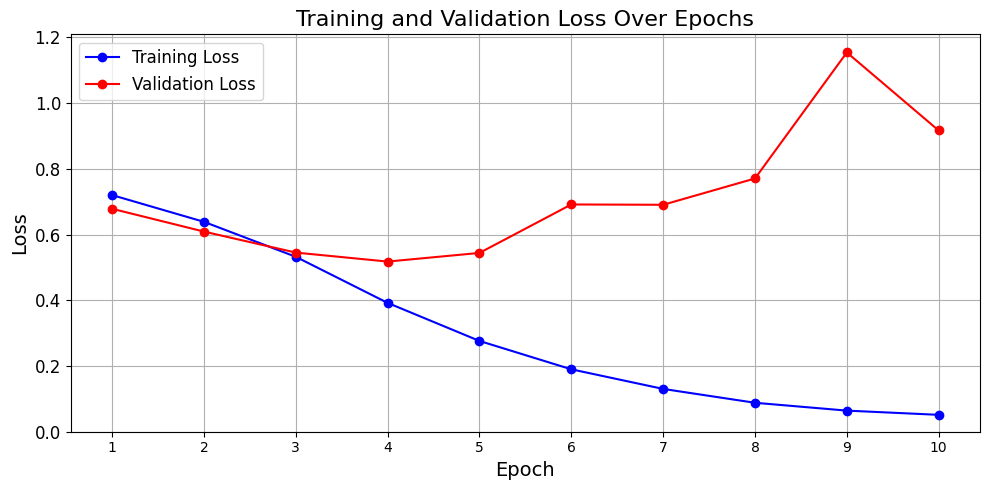

In [13]:
# Training history
history_model6_df = pd.DataFrame(history_model6.history)

# Reset the index to start with 1
history_model6_df.index = range(1, len(history_model6_df) + 1)

# Save DataFrame as CSV
file_path = '/content/drive/My Drive/DS266 Project/model6_LPE_AAS.csv'

history_model6_df.to_csv(file_path, index=False)

# Calling the improved plot function
plot_loss(history_model6_df, ymin=0, ymax=None)

#Hyperparameter Optimization via Optuna

In [10]:
# PositionalEmbedding with trainable positional encodings
class PositionalEmbedding(tf.keras.layers.Layer):
    """Custom Keras layer that integrates trainable positional encodings with token embeddings.

      This layer first creates an embedding matrix for the vocabulary and then adds trainable positional
      encodings to the token embeddings. The idea is to allow the model to learn the optimal positional
      encodings along with learning the token embeddings, which could provide more flexibility and
      potentially better performance for certain datasets or problems.

      Args:
          vocab_size (int): Size of the vocabulary. This determines the number of rows in the embedding matrix.
          d_model (int): The dimensionality of the embeddings. Each token is transformed into a vector of this size.
          maxlen (int): The maximum length of input sequences this embedding layer will be used with. This defines
                        the size of the positional encoding matrix, ensuring it can handle sequences up to this length.

      Attributes:
          d_model (int): Stored dimensionality of the embeddings, used for scaling the embeddings.
          embedding (tf.keras.layers.Embedding): The embedding layer that transforms token indices into embeddings.
          pos_encoding (tf.Variable): Trainable positional encodings added to token embeddings. Initialized with
                                      random values and learned during training.
      """
    def __init__(self, vocab_size, d_model, maxlen=2048):
        super(PositionalEmbedding, self).__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        self.pos_encoding = self.add_weight("pos_encoding", shape=[maxlen, d_model], initializer="random_normal", trainable=True)

    def call(self, x):
      """Adds positional encoding to token embeddings.

        This method retrieves embeddings for input tokens and adds learned positional encodings
        to these embeddings. The embeddings are also scaled by the square root of the model's
        dimensionality, a common practice to help stabilize the learning.

        Args:
            x (tf.Tensor): Input tensor containing token indices of shape (batch_size, sequence_length).

        Returns:
            tf.Tensor: Output tensor of the same shape as `x` but with embeddings that now include
                        positional information. The shape is (batch_size, sequence_length, d_model).
        """
      length = tf.shape(x)[1] # Determine the sequence length of the current batch.
      x = self.embedding(x) * tf.math.sqrt(tf.cast(self.d_model, tf.float32)) # Lookup token embeddings.
      x += self.pos_encoding[:length, :] # Add the appropriate positional encodings up to the current sequence length.
      return x


# BaseAttention layer extended for self-attention mechanism
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x):
        attn_output = self.mha(query=x, value=x, key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class GlobalSelfAttention(BaseAttention):
    def call(self, x):
      attn_output = self.mha(
          query=x,
          value=x,
          key=x)
      x = self.add([x, attn_output])
      x = self.layernorm(x)
      return x

class FeedForward(tf.keras.layers.Layer):
    """Defines a feed-forward network layer which is used in the transformer.

      This class creates a two-layer neural network with a ReLU activation in between,
      followed by dropout for regularization, and a residual connection around the network.

      Args:
          d_model (int): Dimensionality of the input and output.
          dff (int): Dimensionality of the inner layer.
          dropout_rate (float): Dropout rate.

      Attributes:
          seq (tf.keras.Sequential): Sequential model performing the feed-forward operation.
          add (tf.keras.layers.Add): Layer to perform the addition in the residual connection.
          layer_norm (tf.keras.layers.LayerNormalization): Layer to normalize the data.
      """
    def __init__(self, d_model, dff, dropout_rate=0.1):
      super().__init__()
      self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # First dense layer with ReLU
        tf.keras.layers.Dense(d_model),                 # Second dense layer
        tf.keras.layers.Dropout(dropout_rate)           # Dropout for regularization
      ])
      self.add = tf.keras.layers.Add()
      self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
      """Applies the feed-forward network to x with a residual connection followed by layer normalization.

          Args:
              x (tf.Tensor): Input tensor.

          Returns:
              tf.Tensor: Normalized output tensor.
          """
      x = self.add([x, self.seq(x)])  # Apply residual connection
      x = self.layer_norm(x)          # Normalize the output
      return x

# EncoderLayer combining self-attention and FeedForward
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.self_attention = GlobalSelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

# Encoder comprising multiple EncoderLayers
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super().__init__()
        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.enc_layers = [EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        x = self.pos_embedding(x)
        x = self.dropout(x)
        for layer in self.enc_layers:
            x = layer(x)
        return x

# Transformer classifier model
class TransformerClassifier(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff, input_vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, vocab_size=input_vocab_size, dropout_rate=dropout_rate)
        self.final_layer = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        context = self.encoder(inputs)
        logits = self.final_layer(context[:, -1, :])  # Take last hidden state
        return logits

# Define the learning rate scheduler
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)  # Ensure d_model is a float
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)  # Ensure warmup_steps is a float

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Cast step to float32 to ensure compatibility
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        # Ensure division by sqrt of d_model
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        return {
            "d_model": self.d_model.numpy(),  # Return python float
            "warmup_steps": self.warmup_steps.numpy()  # Return python float
        }

# Instantiate the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=CustomSchedule(d_model=100),
                                     beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Instantiate the transformer model using hyperparameters from best trial
model2b = TransformerClassifier(
    num_layers=1,
    d_model=256,
    num_heads=2,
    dff=512,
    input_vocab_size=max(tokenizer.word_index.values()) + 1,
    dropout_rate=0.5)

# Compile model
model2b.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
    run_eagerly=False)

# Define checkpointing
checkpoint_dir = './model_checkpoints/'
checkpoint_filepath = checkpoint_dir + 'tx_w_embeddings_cl2.{epoch:02d}-{val_accuracy:.2f}'

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )]


In [12]:
import optuna
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from keras.callbacks import ModelCheckpoint

# Function to define and compile the Transformer model
def create_model(trial):
    # Suggest values for the hyperparameters
    num_layers = trial.suggest_int('num_layers', 1, 4)
    d_model = trial.suggest_categorical('d_model', [128, 256, 512])
    num_heads = trial.suggest_int('num_heads', 1, 8)
    dff = trial.suggest_categorical('dff', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # Create the Transformer model using suggested hyperparameters
    model = TransformerClassifier(
        num_layers=num_layers,
        d_model=d_model,
        num_heads=num_heads,
        dff=dff,
        input_vocab_size=max(tokenizer.word_index.values()) + 1,
        dropout_rate=dropout_rate
    )

    # Define the learning rate schedule and optimizer
    learning_rate = CustomSchedule(d_model)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,
                                         beta_1=0.9, beta_2=0.98, epsilon=1e-9)

    # Compile the model
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model

# Define the objective function to be optimized
def objective(trial):
    # Create and compile the model
    model = create_model(trial)

    # Define callbacks
    checkpoint_filepath = './model_checkpoints/transformer_{epoch:02d}_{val_accuracy:.4f}.ckpt'
    callbacks_list = [
        ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', save_best_only=True)
    ]

    # Train the model
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=10,  callbacks=callbacks_list)

    # Retrieve the best validation accuracy in the training history
    best_val_accuracy = max(history.history['val_accuracy'])

    # Clear session to free memory after each trial
    tf.keras.backend.clear_session()

    return best_val_accuracy

# Create an Optuna study and optimize the objective
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the details of the best trial
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

# Save the study results
study.trials_dataframe().to_csv("study_results.csv")

[I 2024-04-18 19:19:56,122] A new study created in memory with name: no-name-95179ef3-b201-4540-a3c3-c4ac830c8fb8


Epoch 1/10
84/84 [==============================] - 24s 187ms/step - loss: 0.7701 - accuracy: 0.5344 - val_loss: 0.6583 - val_accuracy: 0.5871
Epoch 2/10
84/84 [==============================] - 13s 155ms/step - loss: 0.7152 - accuracy: 0.5710 - val_loss: 0.6224 - val_accuracy: 0.6699
Epoch 3/10
84/84 [==============================] - 13s 155ms/step - loss: 0.6122 - accuracy: 0.6675 - val_loss: 0.5468 - val_accuracy: 0.7395
Epoch 4/10
84/84 [==============================] - 12s 144ms/step - loss: 0.5300 - accuracy: 0.7425 - val_loss: 0.5179 - val_accuracy: 0.7745
Epoch 5/10
84/84 [==============================] - 8s 90ms/step - loss: 0.4425 - accuracy: 0.7966 - val_loss: 0.5210 - val_accuracy: 0.7566
Epoch 6/10
84/84 [==============================] - 7s 86ms/step - loss: 0.3773 - accuracy: 0.8300 - val_loss: 0.5285 - val_accuracy: 0.7916
Epoch 7/10
84/84 [==============================] - 7s 87ms/step - loss: 0.3258 - accuracy: 0.8660 - val_loss: 0.5970 - val_accuracy: 0.7631
Epoch

[I 2024-04-18 19:21:42,027] Trial 0 finished with value: 0.7915936708450317 and parameters: {'num_layers': 2, 'd_model': 512, 'num_heads': 7, 'dff': 512, 'dropout_rate': 0.4826461302686621}. Best is trial 0 with value: 0.7915936708450317.


Epoch 1/10
84/84 [==============================] - 16s 135ms/step - loss: 0.8384 - accuracy: 0.5052 - val_loss: 0.6802 - val_accuracy: 0.5490
Epoch 2/10
84/84 [==============================] - 8s 96ms/step - loss: 0.6892 - accuracy: 0.5673 - val_loss: 0.6713 - val_accuracy: 0.6011
Epoch 3/10
84/84 [==============================] - 7s 81ms/step - loss: 0.6028 - accuracy: 0.6682 - val_loss: 0.5145 - val_accuracy: 0.7710
Epoch 4/10
84/84 [==============================] - 7s 81ms/step - loss: 0.4233 - accuracy: 0.8039 - val_loss: 0.4941 - val_accuracy: 0.7855
Epoch 5/10
84/84 [==============================] - 4s 43ms/step - loss: 0.3126 - accuracy: 0.8670 - val_loss: 0.5335 - val_accuracy: 0.7732
Epoch 6/10
84/84 [==============================] - 3s 37ms/step - loss: 0.2256 - accuracy: 0.9114 - val_loss: 0.6003 - val_accuracy: 0.7850
Epoch 7/10
84/84 [==============================] - 3s 40ms/step - loss: 0.1594 - accuracy: 0.9386 - val_loss: 0.7211 - val_accuracy: 0.7614
Epoch 8/10


[I 2024-04-18 19:22:38,904] Trial 1 finished with value: 0.7854641079902649 and parameters: {'num_layers': 1, 'd_model': 512, 'num_heads': 5, 'dff': 256, 'dropout_rate': 0.13267409405863786}. Best is trial 0 with value: 0.7915936708450317.


Epoch 1/10
84/84 [==============================] - 21s 172ms/step - loss: 0.7837 - accuracy: 0.5506 - val_loss: 0.6654 - val_accuracy: 0.5792
Epoch 2/10
84/84 [==============================] - 13s 153ms/step - loss: 0.6932 - accuracy: 0.5791 - val_loss: 0.6109 - val_accuracy: 0.6747
Epoch 3/10
84/84 [==============================] - 12s 141ms/step - loss: 0.5863 - accuracy: 0.6891 - val_loss: 0.5834 - val_accuracy: 0.7443
Epoch 4/10
84/84 [==============================] - 12s 138ms/step - loss: 0.4628 - accuracy: 0.7834 - val_loss: 0.5466 - val_accuracy: 0.7820
Epoch 5/10
84/84 [==============================] - 7s 84ms/step - loss: 0.3744 - accuracy: 0.8345 - val_loss: 0.5883 - val_accuracy: 0.7509
Epoch 6/10
84/84 [==============================] - 11s 136ms/step - loss: 0.3000 - accuracy: 0.8758 - val_loss: 0.5350 - val_accuracy: 0.7710
Epoch 7/10
84/84 [==============================] - 7s 82ms/step - loss: 0.2410 - accuracy: 0.9073 - val_loss: 0.6676 - val_accuracy: 0.7903
Epo

[I 2024-04-18 19:24:21,301] Trial 2 finished with value: 0.7902802228927612 and parameters: {'num_layers': 2, 'd_model': 512, 'num_heads': 6, 'dff': 1024, 'dropout_rate': 0.3085104648040117}. Best is trial 0 with value: 0.7915936708450317.


Epoch 1/10
84/84 [==============================] - 12s 102ms/step - loss: 1.0204 - accuracy: 0.5500 - val_loss: 0.7377 - val_accuracy: 0.4746
Epoch 2/10
84/84 [==============================] - 7s 82ms/step - loss: 0.7843 - accuracy: 0.5108 - val_loss: 0.6794 - val_accuracy: 0.6068
Epoch 3/10
84/84 [==============================] - 5s 54ms/step - loss: 0.7135 - accuracy: 0.5585 - val_loss: 0.6426 - val_accuracy: 0.6191
Epoch 4/10
84/84 [==============================] - 4s 50ms/step - loss: 0.6555 - accuracy: 0.6202 - val_loss: 0.5966 - val_accuracy: 0.6843
Epoch 5/10
84/84 [==============================] - 4s 49ms/step - loss: 0.5501 - accuracy: 0.7240 - val_loss: 0.5052 - val_accuracy: 0.7631
Epoch 6/10
84/84 [==============================] - 3s 40ms/step - loss: 0.4235 - accuracy: 0.8088 - val_loss: 0.4838 - val_accuracy: 0.7863
Epoch 7/10
84/84 [==============================] - 1s 14ms/step - loss: 0.3559 - accuracy: 0.8474 - val_loss: 0.4966 - val_accuracy: 0.8060
Epoch 8/10


[I 2024-04-18 19:25:00,718] Trial 3 finished with value: 0.8082311749458313 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 5, 'dff': 256, 'dropout_rate': 0.4859953112557115}. Best is trial 3 with value: 0.8082311749458313.


Epoch 1/10
84/84 [==============================] - 27s 200ms/step - loss: 0.7608 - accuracy: 0.5245 - val_loss: 0.6732 - val_accuracy: 0.5740
Epoch 2/10
84/84 [==============================] - 14s 167ms/step - loss: 0.7103 - accuracy: 0.5481 - val_loss: 0.6421 - val_accuracy: 0.6309
Epoch 3/10
84/84 [==============================] - 13s 150ms/step - loss: 0.6555 - accuracy: 0.6187 - val_loss: 0.5859 - val_accuracy: 0.6957
Epoch 4/10
84/84 [==============================] - 12s 140ms/step - loss: 0.5544 - accuracy: 0.7262 - val_loss: 0.5180 - val_accuracy: 0.7609
Epoch 5/10
84/84 [==============================] - 12s 142ms/step - loss: 0.4596 - accuracy: 0.7943 - val_loss: 0.5030 - val_accuracy: 0.7872
Epoch 6/10
84/84 [==============================] - 4s 51ms/step - loss: 0.3985 - accuracy: 0.8193 - val_loss: 0.5343 - val_accuracy: 0.7986
Epoch 7/10
84/84 [==============================] - 4s 51ms/step - loss: 0.3428 - accuracy: 0.8548 - val_loss: 0.5649 - val_accuracy: 0.7531
Epo

[I 2024-04-18 19:26:39,276] Trial 4 finished with value: 0.8016637563705444 and parameters: {'num_layers': 4, 'd_model': 256, 'num_heads': 4, 'dff': 512, 'dropout_rate': 0.48089288301070765}. Best is trial 3 with value: 0.8082311749458313.


Epoch 1/10
84/84 [==============================] - 13s 117ms/step - loss: 0.7347 - accuracy: 0.5179 - val_loss: 0.6705 - val_accuracy: 0.5736
Epoch 2/10
84/84 [==============================] - 6s 73ms/step - loss: 0.6966 - accuracy: 0.5585 - val_loss: 0.6514 - val_accuracy: 0.6108
Epoch 3/10
84/84 [==============================] - 5s 60ms/step - loss: 0.6443 - accuracy: 0.6266 - val_loss: 0.5803 - val_accuracy: 0.6970
Epoch 4/10
84/84 [==============================] - 4s 51ms/step - loss: 0.5202 - accuracy: 0.7401 - val_loss: 0.5035 - val_accuracy: 0.7693
Epoch 5/10
84/84 [==============================] - 4s 54ms/step - loss: 0.3870 - accuracy: 0.8332 - val_loss: 0.4894 - val_accuracy: 0.7920
Epoch 6/10
84/84 [==============================] - 5s 58ms/step - loss: 0.3029 - accuracy: 0.8745 - val_loss: 0.4830 - val_accuracy: 0.8030
Epoch 7/10
84/84 [==============================] - 2s 20ms/step - loss: 0.2284 - accuracy: 0.9077 - val_loss: 0.5373 - val_accuracy: 0.8025
Epoch 8/10


[I 2024-04-18 19:27:23,847] Trial 5 finished with value: 0.8029772043228149 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 8, 'dff': 1024, 'dropout_rate': 0.28897906744092183}. Best is trial 3 with value: 0.8082311749458313.


Epoch 1/10
84/84 [==============================] - 28s 204ms/step - loss: 0.7501 - accuracy: 0.5312 - val_loss: 0.6764 - val_accuracy: 0.5600
Epoch 2/10
84/84 [==============================] - 13s 161ms/step - loss: 0.6875 - accuracy: 0.5806 - val_loss: 0.6264 - val_accuracy: 0.6716
Epoch 3/10
84/84 [==============================] - 13s 153ms/step - loss: 0.6327 - accuracy: 0.6420 - val_loss: 0.5503 - val_accuracy: 0.7351
Epoch 4/10
84/84 [==============================] - 12s 144ms/step - loss: 0.4882 - accuracy: 0.7656 - val_loss: 0.4926 - val_accuracy: 0.7706
Epoch 5/10
84/84 [==============================] - 4s 50ms/step - loss: 0.3906 - accuracy: 0.8277 - val_loss: 0.5186 - val_accuracy: 0.7631
Epoch 6/10
84/84 [==============================] - 4s 49ms/step - loss: 0.3132 - accuracy: 0.8711 - val_loss: 0.6827 - val_accuracy: 0.7404
Epoch 7/10
84/84 [==============================] - 4s 43ms/step - loss: 0.2416 - accuracy: 0.8990 - val_loss: 0.5343 - val_accuracy: 0.7916
Epoch

[I 2024-04-18 19:28:53,447] Trial 6 finished with value: 0.7915936708450317 and parameters: {'num_layers': 4, 'd_model': 256, 'num_heads': 4, 'dff': 256, 'dropout_rate': 0.3001900928046116}. Best is trial 3 with value: 0.8082311749458313.


Epoch 1/10
84/84 [==============================] - 17s 135ms/step - loss: 0.7234 - accuracy: 0.5365 - val_loss: 0.6736 - val_accuracy: 0.5771
Epoch 2/10
84/84 [==============================] - 9s 112ms/step - loss: 0.7055 - accuracy: 0.5553 - val_loss: 0.6574 - val_accuracy: 0.5779
Epoch 3/10
84/84 [==============================] - 6s 76ms/step - loss: 0.6527 - accuracy: 0.6194 - val_loss: 0.5893 - val_accuracy: 0.6935
Epoch 4/10
84/84 [==============================] - 7s 89ms/step - loss: 0.5200 - accuracy: 0.7420 - val_loss: 0.4966 - val_accuracy: 0.7723
Epoch 5/10
84/84 [==============================] - 6s 68ms/step - loss: 0.3656 - accuracy: 0.8441 - val_loss: 0.4850 - val_accuracy: 0.8004
Epoch 6/10
84/84 [==============================] - 2s 23ms/step - loss: 0.2814 - accuracy: 0.8859 - val_loss: 0.5114 - val_accuracy: 0.7986
Epoch 7/10
84/84 [==============================] - 1s 18ms/step - loss: 0.1938 - accuracy: 0.9236 - val_loss: 0.6041 - val_accuracy: 0.7855
Epoch 8/10

[I 2024-04-18 19:29:47,198] Trial 7 finished with value: 0.8003502488136292 and parameters: {'num_layers': 2, 'd_model': 128, 'num_heads': 1, 'dff': 256, 'dropout_rate': 0.14861209329988317}. Best is trial 3 with value: 0.8082311749458313.


Epoch 1/10
84/84 [==============================] - 31s 226ms/step - loss: 0.7178 - accuracy: 0.5449 - val_loss: 0.6748 - val_accuracy: 0.5963
Epoch 2/10
84/84 [==============================] - 16s 186ms/step - loss: 0.6689 - accuracy: 0.6061 - val_loss: 0.5891 - val_accuracy: 0.6948
Epoch 3/10
84/84 [==============================] - 15s 185ms/step - loss: 0.5524 - accuracy: 0.7257 - val_loss: 0.5695 - val_accuracy: 0.7018
Epoch 4/10
84/84 [==============================] - 15s 180ms/step - loss: 0.4314 - accuracy: 0.8039 - val_loss: 0.4900 - val_accuracy: 0.7833
Epoch 5/10
84/84 [==============================] - 15s 174ms/step - loss: 0.3331 - accuracy: 0.8593 - val_loss: 0.4854 - val_accuracy: 0.7815
Epoch 6/10
84/84 [==============================] - 7s 82ms/step - loss: 0.2372 - accuracy: 0.9101 - val_loss: 0.7116 - val_accuracy: 0.7067
Epoch 7/10
84/84 [==============================] - 7s 81ms/step - loss: 0.1980 - accuracy: 0.9255 - val_loss: 0.7130 - val_accuracy: 0.7391
Epo

[I 2024-04-18 19:31:52,917] Trial 8 finished with value: 0.7832749485969543 and parameters: {'num_layers': 4, 'd_model': 256, 'num_heads': 8, 'dff': 1024, 'dropout_rate': 0.1478498456443462}. Best is trial 3 with value: 0.8082311749458313.


Epoch 1/10
84/84 [==============================] - 29s 219ms/step - loss: 0.7407 - accuracy: 0.5290 - val_loss: 0.6727 - val_accuracy: 0.5788
Epoch 2/10
84/84 [==============================] - 15s 176ms/step - loss: 0.6879 - accuracy: 0.5806 - val_loss: 0.6295 - val_accuracy: 0.6616
Epoch 3/10
84/84 [==============================] - 14s 165ms/step - loss: 0.6091 - accuracy: 0.6750 - val_loss: 0.5488 - val_accuracy: 0.7364
Epoch 4/10
84/84 [==============================] - 13s 161ms/step - loss: 0.4973 - accuracy: 0.7591 - val_loss: 0.4926 - val_accuracy: 0.7741
Epoch 5/10
84/84 [==============================] - 5s 56ms/step - loss: 0.3846 - accuracy: 0.8253 - val_loss: 0.5271 - val_accuracy: 0.7557
Epoch 6/10
84/84 [==============================] - 5s 60ms/step - loss: 0.3215 - accuracy: 0.8655 - val_loss: 0.4956 - val_accuracy: 0.7982
Epoch 7/10
84/84 [==============================] - 5s 60ms/step - loss: 0.2541 - accuracy: 0.8983 - val_loss: 0.5886 - val_accuracy: 0.7824
Epoch

[I 2024-04-18 19:33:33,942] Trial 9 finished with value: 0.7981611490249634 and parameters: {'num_layers': 4, 'd_model': 256, 'num_heads': 6, 'dff': 256, 'dropout_rate': 0.3344634184199756}. Best is trial 3 with value: 0.8082311749458313.


Epoch 1/10
84/84 [==============================] - 22s 159ms/step - loss: 0.7764 - accuracy: 0.5273 - val_loss: 0.7003 - val_accuracy: 0.5775
Epoch 2/10
84/84 [==============================] - 11s 133ms/step - loss: 0.7161 - accuracy: 0.5461 - val_loss: 0.6644 - val_accuracy: 0.5788
Epoch 3/10
84/84 [==============================] - 9s 114ms/step - loss: 0.6653 - accuracy: 0.6022 - val_loss: 0.6363 - val_accuracy: 0.6379
Epoch 4/10
84/84 [==============================] - 8s 96ms/step - loss: 0.5820 - accuracy: 0.6883 - val_loss: 0.5350 - val_accuracy: 0.7509
Epoch 5/10
84/84 [==============================] - 9s 106ms/step - loss: 0.4604 - accuracy: 0.7865 - val_loss: 0.5202 - val_accuracy: 0.7601
Epoch 6/10
84/84 [==============================] - 8s 99ms/step - loss: 0.3809 - accuracy: 0.8364 - val_loss: 0.4808 - val_accuracy: 0.8021
Epoch 7/10
84/84 [==============================] - 2s 24ms/step - loss: 0.2996 - accuracy: 0.8793 - val_loss: 0.5378 - val_accuracy: 0.8034
Epoch 8

[I 2024-04-18 19:34:49,920] Trial 10 finished with value: 0.803415060043335 and parameters: {'num_layers': 3, 'd_model': 128, 'num_heads': 2, 'dff': 256, 'dropout_rate': 0.40309668564931334}. Best is trial 3 with value: 0.8082311749458313.


Epoch 1/10
84/84 [==============================] - 23s 177ms/step - loss: 0.7494 - accuracy: 0.5320 - val_loss: 0.6747 - val_accuracy: 0.5771
Epoch 2/10
84/84 [==============================] - 10s 121ms/step - loss: 0.7112 - accuracy: 0.5493 - val_loss: 0.6620 - val_accuracy: 0.5867
Epoch 3/10
84/84 [==============================] - 10s 118ms/step - loss: 0.6719 - accuracy: 0.5830 - val_loss: 0.6196 - val_accuracy: 0.6620
Epoch 4/10
84/84 [==============================] - 9s 103ms/step - loss: 0.5890 - accuracy: 0.6855 - val_loss: 0.5485 - val_accuracy: 0.7264
Epoch 5/10
84/84 [==============================] - 8s 99ms/step - loss: 0.4745 - accuracy: 0.7737 - val_loss: 0.4837 - val_accuracy: 0.7942
Epoch 6/10
84/84 [==============================] - 2s 26ms/step - loss: 0.3585 - accuracy: 0.8416 - val_loss: 0.5971 - val_accuracy: 0.7347
Epoch 7/10
84/84 [==============================] - 2s 29ms/step - loss: 0.3016 - accuracy: 0.8730 - val_loss: 0.4871 - val_accuracy: 0.7986
Epoch 

[I 2024-04-18 19:35:59,893] Trial 11 finished with value: 0.7985989451408386 and parameters: {'num_layers': 3, 'd_model': 128, 'num_heads': 2, 'dff': 256, 'dropout_rate': 0.40541468069301073}. Best is trial 3 with value: 0.8082311749458313.


Epoch 1/10
84/84 [==============================] - 22s 171ms/step - loss: 0.7674 - accuracy: 0.5196 - val_loss: 0.6946 - val_accuracy: 0.5779
Epoch 2/10
84/84 [==============================] - 11s 133ms/step - loss: 0.7142 - accuracy: 0.5410 - val_loss: 0.6588 - val_accuracy: 0.5876
Epoch 3/10
84/84 [==============================] - 10s 114ms/step - loss: 0.6670 - accuracy: 0.5958 - val_loss: 0.6231 - val_accuracy: 0.6607
Epoch 4/10
84/84 [==============================] - 8s 99ms/step - loss: 0.5573 - accuracy: 0.7120 - val_loss: 0.5269 - val_accuracy: 0.7351
Epoch 5/10
84/84 [==============================] - 9s 104ms/step - loss: 0.4315 - accuracy: 0.8075 - val_loss: 0.4957 - val_accuracy: 0.7846
Epoch 6/10
84/84 [==============================] - 2s 28ms/step - loss: 0.3462 - accuracy: 0.8486 - val_loss: 0.6233 - val_accuracy: 0.7211
Epoch 7/10
84/84 [==============================] - 2s 26ms/step - loss: 0.2766 - accuracy: 0.8842 - val_loss: 0.5671 - val_accuracy: 0.8012
Epoch 

[I 2024-04-18 19:37:10,826] Trial 12 finished with value: 0.8012259006500244 and parameters: {'num_layers': 3, 'd_model': 128, 'num_heads': 3, 'dff': 256, 'dropout_rate': 0.40430931872655884}. Best is trial 3 with value: 0.8082311749458313.


Epoch 1/10
84/84 [==============================] - 22s 168ms/step - loss: 0.7814 - accuracy: 0.5260 - val_loss: 0.6795 - val_accuracy: 0.5771
Epoch 2/10
84/84 [==============================] - 9s 110ms/step - loss: 0.7136 - accuracy: 0.5534 - val_loss: 0.6663 - val_accuracy: 0.5784
Epoch 3/10
84/84 [==============================] - 10s 117ms/step - loss: 0.6898 - accuracy: 0.5650 - val_loss: 0.6319 - val_accuracy: 0.6423
Epoch 4/10
84/84 [==============================] - 9s 108ms/step - loss: 0.6201 - accuracy: 0.6538 - val_loss: 0.5569 - val_accuracy: 0.7119
Epoch 5/10
84/84 [==============================] - 8s 93ms/step - loss: 0.4876 - accuracy: 0.7739 - val_loss: 0.5116 - val_accuracy: 0.7776
Epoch 6/10
84/84 [==============================] - 3s 31ms/step - loss: 0.3877 - accuracy: 0.8296 - val_loss: 0.5242 - val_accuracy: 0.7894
Epoch 7/10
84/84 [==============================] - 8s 97ms/step - loss: 0.3210 - accuracy: 0.8611 - val_loss: 0.5038 - val_accuracy: 0.7955
Epoch 8

[I 2024-04-18 19:38:26,437] Trial 13 finished with value: 0.7955341339111328 and parameters: {'num_layers': 3, 'd_model': 128, 'num_heads': 1, 'dff': 256, 'dropout_rate': 0.4067412234501696}. Best is trial 3 with value: 0.8082311749458313.


Epoch 1/10
84/84 [==============================] - 12s 103ms/step - loss: 0.8865 - accuracy: 0.4719 - val_loss: 0.7008 - val_accuracy: 0.5771
Epoch 2/10
84/84 [==============================] - 6s 71ms/step - loss: 0.7485 - accuracy: 0.5464 - val_loss: 0.6787 - val_accuracy: 0.5771
Epoch 3/10
84/84 [==============================] - 6s 70ms/step - loss: 0.7091 - accuracy: 0.5628 - val_loss: 0.6360 - val_accuracy: 0.6318
Epoch 4/10
84/84 [==============================] - 4s 52ms/step - loss: 0.6389 - accuracy: 0.6403 - val_loss: 0.5650 - val_accuracy: 0.7233
Epoch 5/10
84/84 [==============================] - 4s 45ms/step - loss: 0.5220 - accuracy: 0.7472 - val_loss: 0.4976 - val_accuracy: 0.7793
Epoch 6/10
84/84 [==============================] - 1s 17ms/step - loss: 0.4131 - accuracy: 0.8127 - val_loss: 0.5022 - val_accuracy: 0.8052
Epoch 7/10
84/84 [==============================] - 2s 18ms/step - loss: 0.3565 - accuracy: 0.8510 - val_loss: 0.5128 - val_accuracy: 0.8034
Epoch 8/10


[I 2024-04-18 19:39:05,449] Trial 14 finished with value: 0.8082311749458313 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 3, 'dff': 256, 'dropout_rate': 0.44094169912524905}. Best is trial 3 with value: 0.8082311749458313.


Epoch 1/10
84/84 [==============================] - 14s 121ms/step - loss: 0.7804 - accuracy: 0.5239 - val_loss: 0.6863 - val_accuracy: 0.5766
Epoch 2/10
84/84 [==============================] - 6s 71ms/step - loss: 0.7413 - accuracy: 0.5367 - val_loss: 0.6739 - val_accuracy: 0.5784
Epoch 3/10
84/84 [==============================] - 5s 63ms/step - loss: 0.6915 - accuracy: 0.5691 - val_loss: 0.6333 - val_accuracy: 0.6252
Epoch 4/10
84/84 [==============================] - 5s 57ms/step - loss: 0.6374 - accuracy: 0.6414 - val_loss: 0.5576 - val_accuracy: 0.7303
Epoch 5/10
84/84 [==============================] - 5s 58ms/step - loss: 0.5149 - accuracy: 0.7469 - val_loss: 0.4969 - val_accuracy: 0.7863
Epoch 6/10
84/84 [==============================] - 4s 44ms/step - loss: 0.3999 - accuracy: 0.8225 - val_loss: 0.4917 - val_accuracy: 0.8060
Epoch 7/10
84/84 [==============================] - 4s 49ms/step - loss: 0.3425 - accuracy: 0.8542 - val_loss: 0.4872 - val_accuracy: 0.8030
Epoch 8/10


[I 2024-04-18 19:39:51,698] Trial 15 finished with value: 0.807355523109436 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 5, 'dff': 512, 'dropout_rate': 0.48641758271202107}. Best is trial 3 with value: 0.8082311749458313.


Epoch 1/10
84/84 [==============================] - 13s 115ms/step - loss: 0.7697 - accuracy: 0.4969 - val_loss: 0.6745 - val_accuracy: 0.5622
Epoch 2/10
84/84 [==============================] - 4s 44ms/step - loss: 0.7272 - accuracy: 0.5414 - val_loss: 0.6867 - val_accuracy: 0.5639
Epoch 3/10
84/84 [==============================] - 5s 60ms/step - loss: 0.6696 - accuracy: 0.5990 - val_loss: 0.6063 - val_accuracy: 0.6764
Epoch 4/10
84/84 [==============================] - 5s 56ms/step - loss: 0.5603 - accuracy: 0.7103 - val_loss: 0.5150 - val_accuracy: 0.7653
Epoch 5/10
84/84 [==============================] - 3s 40ms/step - loss: 0.4011 - accuracy: 0.8176 - val_loss: 0.4911 - val_accuracy: 0.8021
Epoch 6/10
84/84 [==============================] - 1s 16ms/step - loss: 0.3111 - accuracy: 0.8731 - val_loss: 0.5187 - val_accuracy: 0.7815
Epoch 7/10
84/84 [==============================] - 1s 15ms/step - loss: 0.2331 - accuracy: 0.9101 - val_loss: 0.5735 - val_accuracy: 0.8078
Epoch 8/10


[I 2024-04-18 19:40:27,393] Trial 16 finished with value: 0.8077933192253113 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 3, 'dff': 256, 'dropout_rate': 0.24108969981892328}. Best is trial 3 with value: 0.8082311749458313.


Epoch 1/10
84/84 [==============================] - 18s 136ms/step - loss: 0.7766 - accuracy: 0.5252 - val_loss: 0.6770 - val_accuracy: 0.5775
Epoch 2/10
84/84 [==============================] - 9s 107ms/step - loss: 0.7196 - accuracy: 0.5436 - val_loss: 0.6652 - val_accuracy: 0.5827
Epoch 3/10
84/84 [==============================] - 7s 79ms/step - loss: 0.6806 - accuracy: 0.5843 - val_loss: 0.6260 - val_accuracy: 0.6366
Epoch 4/10
84/84 [==============================] - 6s 67ms/step - loss: 0.5928 - accuracy: 0.6832 - val_loss: 0.5338 - val_accuracy: 0.7426
Epoch 5/10
84/84 [==============================] - 7s 81ms/step - loss: 0.4760 - accuracy: 0.7756 - val_loss: 0.5090 - val_accuracy: 0.7623
Epoch 6/10
84/84 [==============================] - 6s 75ms/step - loss: 0.3823 - accuracy: 0.8347 - val_loss: 0.5067 - val_accuracy: 0.7750
Epoch 7/10
84/84 [==============================] - 2s 23ms/step - loss: 0.3149 - accuracy: 0.8649 - val_loss: 0.5153 - val_accuracy: 0.7798
Epoch 8/10

[I 2024-04-18 19:41:27,418] Trial 17 finished with value: 0.7797723412513733 and parameters: {'num_layers': 2, 'd_model': 128, 'num_heads': 3, 'dff': 256, 'dropout_rate': 0.4455279451868589}. Best is trial 3 with value: 0.8082311749458313.


Epoch 1/10
84/84 [==============================] - 14s 122ms/step - loss: 0.8014 - accuracy: 0.5055 - val_loss: 0.6775 - val_accuracy: 0.5771
Epoch 2/10
84/84 [==============================] - 7s 81ms/step - loss: 0.7388 - accuracy: 0.5369 - val_loss: 0.6628 - val_accuracy: 0.5893
Epoch 3/10
84/84 [==============================] - 5s 64ms/step - loss: 0.6946 - accuracy: 0.5663 - val_loss: 0.6268 - val_accuracy: 0.6436
Epoch 4/10
84/84 [==============================] - 5s 58ms/step - loss: 0.6114 - accuracy: 0.6724 - val_loss: 0.5361 - val_accuracy: 0.7474
Epoch 5/10
84/84 [==============================] - 4s 49ms/step - loss: 0.4769 - accuracy: 0.7735 - val_loss: 0.5233 - val_accuracy: 0.7890
Epoch 6/10
84/84 [==============================] - 4s 46ms/step - loss: 0.3824 - accuracy: 0.8298 - val_loss: 0.4547 - val_accuracy: 0.8109
Epoch 7/10
84/84 [==============================] - 2s 19ms/step - loss: 0.3174 - accuracy: 0.8653 - val_loss: 0.4624 - val_accuracy: 0.8148
Epoch 8/10


[I 2024-04-18 19:42:11,838] Trial 18 finished with value: 0.8147985935211182 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 6, 'dff': 512, 'dropout_rate': 0.4540920844083347}. Best is trial 18 with value: 0.8147985935211182.


Epoch 1/10
84/84 [==============================] - 15s 131ms/step - loss: 0.9062 - accuracy: 0.4992 - val_loss: 0.6860 - val_accuracy: 0.5525
Epoch 2/10
84/84 [==============================] - 9s 109ms/step - loss: 0.7170 - accuracy: 0.5470 - val_loss: 0.6658 - val_accuracy: 0.5919
Epoch 3/10
84/84 [==============================] - 7s 86ms/step - loss: 0.6247 - accuracy: 0.6577 - val_loss: 0.5333 - val_accuracy: 0.7447
Epoch 4/10
84/84 [==============================] - 7s 83ms/step - loss: 0.4589 - accuracy: 0.7913 - val_loss: 0.5006 - val_accuracy: 0.7868
Epoch 5/10
84/84 [==============================] - 4s 47ms/step - loss: 0.3552 - accuracy: 0.8454 - val_loss: 0.5033 - val_accuracy: 0.7982
Epoch 6/10
84/84 [==============================] - 4s 42ms/step - loss: 0.2657 - accuracy: 0.8915 - val_loss: 0.6036 - val_accuracy: 0.7785
Epoch 7/10
84/84 [==============================] - 4s 44ms/step - loss: 0.2080 - accuracy: 0.9172 - val_loss: 0.5948 - val_accuracy: 0.7570
Epoch 8/10

[I 2024-04-18 19:43:11,905] Trial 19 finished with value: 0.7981611490249634 and parameters: {'num_layers': 1, 'd_model': 512, 'num_heads': 6, 'dff': 512, 'dropout_rate': 0.23315370665746135}. Best is trial 18 with value: 0.8147985935211182.


Epoch 1/10
84/84 [==============================] - 19s 157ms/step - loss: 0.7852 - accuracy: 0.4928 - val_loss: 0.6702 - val_accuracy: 0.5709
Epoch 2/10
84/84 [==============================] - 9s 111ms/step - loss: 0.7104 - accuracy: 0.5506 - val_loss: 0.6499 - val_accuracy: 0.6068
Epoch 3/10
84/84 [==============================] - 8s 92ms/step - loss: 0.6417 - accuracy: 0.6324 - val_loss: 0.5950 - val_accuracy: 0.6694
Epoch 4/10
84/84 [==============================] - 6s 78ms/step - loss: 0.5234 - accuracy: 0.7392 - val_loss: 0.5326 - val_accuracy: 0.7347
Epoch 5/10
84/84 [==============================] - 3s 32ms/step - loss: 0.4063 - accuracy: 0.8140 - val_loss: 0.5383 - val_accuracy: 0.7719
Epoch 6/10
84/84 [==============================] - 2s 27ms/step - loss: 0.3142 - accuracy: 0.8645 - val_loss: 0.5881 - val_accuracy: 0.7833
Epoch 7/10
84/84 [==============================] - 2s 25ms/step - loss: 0.2560 - accuracy: 0.8959 - val_loss: 0.5981 - val_accuracy: 0.7715
Epoch 8/10

[I 2024-04-18 19:44:07,457] Trial 20 finished with value: 0.7832749485969543 and parameters: {'num_layers': 2, 'd_model': 128, 'num_heads': 7, 'dff': 512, 'dropout_rate': 0.3574956922304294}. Best is trial 18 with value: 0.8147985935211182.


Epoch 1/10
84/84 [==============================] - 14s 123ms/step - loss: 0.7669 - accuracy: 0.5189 - val_loss: 0.6784 - val_accuracy: 0.5539
Epoch 2/10
84/84 [==============================] - 6s 76ms/step - loss: 0.7342 - accuracy: 0.5386 - val_loss: 0.6647 - val_accuracy: 0.5806
Epoch 3/10
84/84 [==============================] - 5s 63ms/step - loss: 0.6898 - accuracy: 0.5725 - val_loss: 0.6333 - val_accuracy: 0.6331
Epoch 4/10
84/84 [==============================] - 4s 50ms/step - loss: 0.6136 - accuracy: 0.6611 - val_loss: 0.5457 - val_accuracy: 0.7373
Epoch 5/10
84/84 [==============================] - 5s 60ms/step - loss: 0.4846 - accuracy: 0.7696 - val_loss: 0.4775 - val_accuracy: 0.7920
Epoch 6/10
84/84 [==============================] - 2s 22ms/step - loss: 0.3755 - accuracy: 0.8358 - val_loss: 0.4976 - val_accuracy: 0.8074
Epoch 7/10
84/84 [==============================] - 2s 21ms/step - loss: 0.3159 - accuracy: 0.8700 - val_loss: 0.4803 - val_accuracy: 0.8043
Epoch 8/10


[I 2024-04-18 19:44:50,108] Trial 21 finished with value: 0.8112959861755371 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 5, 'dff': 512, 'dropout_rate': 0.4410725310333877}. Best is trial 18 with value: 0.8147985935211182.


Epoch 1/10
84/84 [==============================] - 13s 113ms/step - loss: 0.7954 - accuracy: 0.5365 - val_loss: 0.6895 - val_accuracy: 0.5779
Epoch 2/10
84/84 [==============================] - 7s 85ms/step - loss: 0.7405 - accuracy: 0.5361 - val_loss: 0.6597 - val_accuracy: 0.5827
Epoch 3/10
84/84 [==============================] - 6s 67ms/step - loss: 0.6865 - accuracy: 0.5791 - val_loss: 0.6208 - val_accuracy: 0.6480
Epoch 4/10
84/84 [==============================] - 4s 51ms/step - loss: 0.6070 - accuracy: 0.6750 - val_loss: 0.5443 - val_accuracy: 0.7421
Epoch 5/10
84/84 [==============================] - 4s 43ms/step - loss: 0.4793 - accuracy: 0.7748 - val_loss: 0.5154 - val_accuracy: 0.7771
Epoch 6/10
84/84 [==============================] - 1s 17ms/step - loss: 0.3874 - accuracy: 0.8352 - val_loss: 0.5515 - val_accuracy: 0.7837
Epoch 7/10
84/84 [==============================] - 4s 43ms/step - loss: 0.3277 - accuracy: 0.8613 - val_loss: 0.4963 - val_accuracy: 0.8078
Epoch 8/10


[I 2024-04-18 19:45:33,582] Trial 22 finished with value: 0.8077933192253113 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 5, 'dff': 512, 'dropout_rate': 0.45142342660911894}. Best is trial 18 with value: 0.8147985935211182.


Epoch 1/10
84/84 [==============================] - 15s 136ms/step - loss: 0.7674 - accuracy: 0.5074 - val_loss: 0.6806 - val_accuracy: 0.5779
Epoch 2/10
84/84 [==============================] - 6s 74ms/step - loss: 0.7180 - accuracy: 0.5474 - val_loss: 0.6719 - val_accuracy: 0.5792
Epoch 3/10
84/84 [==============================] - 5s 55ms/step - loss: 0.6614 - accuracy: 0.6136 - val_loss: 0.6010 - val_accuracy: 0.6773
Epoch 4/10
84/84 [==============================] - 5s 59ms/step - loss: 0.5515 - accuracy: 0.7223 - val_loss: 0.5143 - val_accuracy: 0.7684
Epoch 5/10
84/84 [==============================] - 4s 53ms/step - loss: 0.4239 - accuracy: 0.8103 - val_loss: 0.4960 - val_accuracy: 0.7964
Epoch 6/10
84/84 [==============================] - 2s 19ms/step - loss: 0.3321 - accuracy: 0.8568 - val_loss: 0.5215 - val_accuracy: 0.8034
Epoch 7/10
84/84 [==============================] - 1s 16ms/step - loss: 0.2561 - accuracy: 0.8959 - val_loss: 0.5644 - val_accuracy: 0.7890
Epoch 8/10


[I 2024-04-18 19:46:15,382] Trial 23 finished with value: 0.803415060043335 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 7, 'dff': 512, 'dropout_rate': 0.3635124051701473}. Best is trial 18 with value: 0.8147985935211182.


Epoch 1/10
84/84 [==============================] - 19s 154ms/step - loss: 0.8028 - accuracy: 0.5100 - val_loss: 0.6763 - val_accuracy: 0.5455
Epoch 2/10
84/84 [==============================] - 9s 101ms/step - loss: 0.7173 - accuracy: 0.5418 - val_loss: 0.6716 - val_accuracy: 0.5744
Epoch 3/10
84/84 [==============================] - 7s 89ms/step - loss: 0.6753 - accuracy: 0.5860 - val_loss: 0.6114 - val_accuracy: 0.6703
Epoch 4/10
84/84 [==============================] - 6s 77ms/step - loss: 0.5878 - accuracy: 0.6953 - val_loss: 0.5596 - val_accuracy: 0.7233
Epoch 5/10
84/84 [==============================] - 6s 72ms/step - loss: 0.4731 - accuracy: 0.7786 - val_loss: 0.5183 - val_accuracy: 0.7741
Epoch 6/10
84/84 [==============================] - 7s 79ms/step - loss: 0.3855 - accuracy: 0.8272 - val_loss: 0.5177 - val_accuracy: 0.7859
Epoch 7/10
84/84 [==============================] - 2s 24ms/step - loss: 0.3274 - accuracy: 0.8585 - val_loss: 0.5332 - val_accuracy: 0.7938
Epoch 8/10

[I 2024-04-18 19:47:17,723] Trial 24 finished with value: 0.7964097857475281 and parameters: {'num_layers': 2, 'd_model': 128, 'num_heads': 6, 'dff': 512, 'dropout_rate': 0.4990496264103597}. Best is trial 18 with value: 0.8147985935211182.


Epoch 1/10
84/84 [==============================] - 14s 119ms/step - loss: 0.7822 - accuracy: 0.5205 - val_loss: 0.6752 - val_accuracy: 0.5714
Epoch 2/10
84/84 [==============================] - 6s 77ms/step - loss: 0.7346 - accuracy: 0.5305 - val_loss: 0.6586 - val_accuracy: 0.5989
Epoch 3/10
84/84 [==============================] - 6s 69ms/step - loss: 0.6826 - accuracy: 0.5755 - val_loss: 0.6221 - val_accuracy: 0.6506
Epoch 4/10
84/84 [==============================] - 5s 58ms/step - loss: 0.6149 - accuracy: 0.6622 - val_loss: 0.5540 - val_accuracy: 0.7141
Epoch 5/10
84/84 [==============================] - 5s 54ms/step - loss: 0.4867 - accuracy: 0.7750 - val_loss: 0.4929 - val_accuracy: 0.7815
Epoch 6/10
84/84 [==============================] - 4s 51ms/step - loss: 0.3874 - accuracy: 0.8255 - val_loss: 0.4928 - val_accuracy: 0.7916
Epoch 7/10
84/84 [==============================] - 1s 16ms/step - loss: 0.3256 - accuracy: 0.8617 - val_loss: 0.4953 - val_accuracy: 0.7933
Epoch 8/10


[I 2024-04-18 19:48:02,281] Trial 25 finished with value: 0.793345034122467 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 4, 'dff': 512, 'dropout_rate': 0.44709492204175194}. Best is trial 18 with value: 0.8147985935211182.


Epoch 1/10
84/84 [==============================] - 13s 108ms/step - loss: 0.7642 - accuracy: 0.5249 - val_loss: 0.6754 - val_accuracy: 0.5771
Epoch 2/10
84/84 [==============================] - 7s 78ms/step - loss: 0.7299 - accuracy: 0.5363 - val_loss: 0.6619 - val_accuracy: 0.5959
Epoch 3/10
84/84 [==============================] - 5s 59ms/step - loss: 0.6802 - accuracy: 0.5868 - val_loss: 0.6111 - val_accuracy: 0.6778
Epoch 4/10
84/84 [==============================] - 5s 64ms/step - loss: 0.5748 - accuracy: 0.7031 - val_loss: 0.5212 - val_accuracy: 0.7452
Epoch 5/10
84/84 [==============================] - 4s 52ms/step - loss: 0.4394 - accuracy: 0.7998 - val_loss: 0.4884 - val_accuracy: 0.7872
Epoch 6/10
84/84 [==============================] - 4s 51ms/step - loss: 0.3411 - accuracy: 0.8527 - val_loss: 0.4766 - val_accuracy: 0.8074
Epoch 7/10
84/84 [==============================] - 1s 15ms/step - loss: 0.2791 - accuracy: 0.8876 - val_loss: 0.5003 - val_accuracy: 0.8078
Epoch 8/10


[I 2024-04-18 19:48:45,349] Trial 26 finished with value: 0.8077933192253113 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 5, 'dff': 512, 'dropout_rate': 0.38259753367570826}. Best is trial 18 with value: 0.8147985935211182.


Epoch 1/10
84/84 [==============================] - 18s 144ms/step - loss: 0.7732 - accuracy: 0.5252 - val_loss: 0.6899 - val_accuracy: 0.5460
Epoch 2/10
84/84 [==============================] - 9s 104ms/step - loss: 0.7205 - accuracy: 0.5363 - val_loss: 0.6533 - val_accuracy: 0.5963
Epoch 3/10
84/84 [==============================] - 3s 39ms/step - loss: 0.6562 - accuracy: 0.6168 - val_loss: 0.6631 - val_accuracy: 0.6384
Epoch 4/10
84/84 [==============================] - 7s 83ms/step - loss: 0.5632 - accuracy: 0.7129 - val_loss: 0.5771 - val_accuracy: 0.6983
Epoch 5/10
84/84 [==============================] - 6s 74ms/step - loss: 0.4306 - accuracy: 0.8054 - val_loss: 0.4899 - val_accuracy: 0.7750
Epoch 6/10
84/84 [==============================] - 7s 85ms/step - loss: 0.3436 - accuracy: 0.8523 - val_loss: 0.4891 - val_accuracy: 0.8060
Epoch 7/10
84/84 [==============================] - 2s 28ms/step - loss: 0.2959 - accuracy: 0.8788 - val_loss: 0.5181 - val_accuracy: 0.8012
Epoch 8/10

[I 2024-04-18 19:49:44,384] Trial 27 finished with value: 0.8060420155525208 and parameters: {'num_layers': 2, 'd_model': 128, 'num_heads': 6, 'dff': 1024, 'dropout_rate': 0.42845442298982245}. Best is trial 18 with value: 0.8147985935211182.


Epoch 1/10
84/84 [==============================] - 14s 129ms/step - loss: 0.7905 - accuracy: 0.5414 - val_loss: 0.6638 - val_accuracy: 0.5792
Epoch 2/10
84/84 [==============================] - 10s 122ms/step - loss: 0.7409 - accuracy: 0.5571 - val_loss: 0.6236 - val_accuracy: 0.6629
Epoch 3/10
84/84 [==============================] - 8s 96ms/step - loss: 0.6421 - accuracy: 0.6433 - val_loss: 0.5547 - val_accuracy: 0.7404
Epoch 4/10
84/84 [==============================] - 7s 83ms/step - loss: 0.5330 - accuracy: 0.7405 - val_loss: 0.4920 - val_accuracy: 0.7815
Epoch 5/10
84/84 [==============================] - 5s 57ms/step - loss: 0.4348 - accuracy: 0.8028 - val_loss: 0.4932 - val_accuracy: 0.7885
Epoch 6/10
84/84 [==============================] - 4s 47ms/step - loss: 0.3602 - accuracy: 0.8422 - val_loss: 0.5263 - val_accuracy: 0.7964
Epoch 7/10
84/84 [==============================] - 4s 46ms/step - loss: 0.3120 - accuracy: 0.8673 - val_loss: 0.5556 - val_accuracy: 0.8021
Epoch 8/1

[I 2024-04-18 19:50:48,265] Trial 28 finished with value: 0.8021015524864197 and parameters: {'num_layers': 1, 'd_model': 512, 'num_heads': 7, 'dff': 512, 'dropout_rate': 0.4565181084954686}. Best is trial 18 with value: 0.8147985935211182.


Epoch 1/10
84/84 [==============================] - 19s 152ms/step - loss: 0.7728 - accuracy: 0.5365 - val_loss: 0.6710 - val_accuracy: 0.5644
Epoch 2/10
84/84 [==============================] - 10s 116ms/step - loss: 0.7300 - accuracy: 0.5524 - val_loss: 0.6601 - val_accuracy: 0.6182
Epoch 3/10
84/84 [==============================] - 9s 108ms/step - loss: 0.6593 - accuracy: 0.6226 - val_loss: 0.6062 - val_accuracy: 0.6690
Epoch 4/10
84/84 [==============================] - 8s 93ms/step - loss: 0.5720 - accuracy: 0.7035 - val_loss: 0.5984 - val_accuracy: 0.6839
Epoch 5/10
84/84 [==============================] - 3s 40ms/step - loss: 0.4524 - accuracy: 0.7925 - val_loss: 0.6647 - val_accuracy: 0.6664
Epoch 6/10
84/84 [==============================] - 8s 91ms/step - loss: 0.3746 - accuracy: 0.8367 - val_loss: 0.5314 - val_accuracy: 0.7859
Epoch 7/10
84/84 [==============================] - 7s 84ms/step - loss: 0.3202 - accuracy: 0.8666 - val_loss: 0.4894 - val_accuracy: 0.8052
Epoch 8/

[I 2024-04-18 19:51:59,089] Trial 29 finished with value: 0.8051663637161255 and parameters: {'num_layers': 2, 'd_model': 256, 'num_heads': 5, 'dff': 512, 'dropout_rate': 0.47094088480745805}. Best is trial 18 with value: 0.8147985935211182.


Epoch 1/10
84/84 [==============================] - 14s 128ms/step - loss: 0.7793 - accuracy: 0.5168 - val_loss: 0.6778 - val_accuracy: 0.5779
Epoch 2/10
84/84 [==============================] - 9s 104ms/step - loss: 0.7220 - accuracy: 0.5648 - val_loss: 0.6384 - val_accuracy: 0.6156
Epoch 3/10
84/84 [==============================] - 7s 85ms/step - loss: 0.6412 - accuracy: 0.6401 - val_loss: 0.5518 - val_accuracy: 0.7356
Epoch 4/10
84/84 [==============================] - 3s 41ms/step - loss: 0.5328 - accuracy: 0.7409 - val_loss: 0.5607 - val_accuracy: 0.7631
Epoch 5/10
84/84 [==============================] - 6s 73ms/step - loss: 0.4366 - accuracy: 0.8002 - val_loss: 0.4960 - val_accuracy: 0.7929
Epoch 6/10
84/84 [==============================] - 3s 39ms/step - loss: 0.3642 - accuracy: 0.8433 - val_loss: 0.4980 - val_accuracy: 0.8074
Epoch 7/10
84/84 [==============================] - 3s 33ms/step - loss: 0.3104 - accuracy: 0.8715 - val_loss: 0.5184 - val_accuracy: 0.8008
Epoch 8/10

[I 2024-04-18 19:52:53,923] Trial 30 finished with value: 0.807355523109436 and parameters: {'num_layers': 1, 'd_model': 512, 'num_heads': 4, 'dff': 512, 'dropout_rate': 0.42612253185500915}. Best is trial 18 with value: 0.8147985935211182.


Epoch 1/10
84/84 [==============================] - 13s 113ms/step - loss: 0.8052 - accuracy: 0.5023 - val_loss: 0.6750 - val_accuracy: 0.5705
Epoch 2/10
84/84 [==============================] - 6s 72ms/step - loss: 0.7380 - accuracy: 0.5374 - val_loss: 0.6658 - val_accuracy: 0.5740
Epoch 3/10
84/84 [==============================] - 5s 60ms/step - loss: 0.7081 - accuracy: 0.5549 - val_loss: 0.6442 - val_accuracy: 0.6217
Epoch 4/10
84/84 [==============================] - 5s 55ms/step - loss: 0.6562 - accuracy: 0.6170 - val_loss: 0.5766 - val_accuracy: 0.7110
Epoch 5/10
84/84 [==============================] - 5s 58ms/step - loss: 0.5366 - accuracy: 0.7332 - val_loss: 0.4990 - val_accuracy: 0.7789
Epoch 6/10
84/84 [==============================] - 4s 49ms/step - loss: 0.4228 - accuracy: 0.8075 - val_loss: 0.4952 - val_accuracy: 0.7960
Epoch 7/10
84/84 [==============================] - 4s 45ms/step - loss: 0.3599 - accuracy: 0.8473 - val_loss: 0.4738 - val_accuracy: 0.8100
Epoch 8/10


[I 2024-04-18 19:53:38,991] Trial 31 finished with value: 0.8121716380119324 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 3, 'dff': 256, 'dropout_rate': 0.46993616694922125}. Best is trial 18 with value: 0.8147985935211182.


Epoch 1/10
84/84 [==============================] - 13s 116ms/step - loss: 0.8123 - accuracy: 0.5361 - val_loss: 0.7240 - val_accuracy: 0.5771
Epoch 2/10
84/84 [==============================] - 6s 75ms/step - loss: 0.7653 - accuracy: 0.5275 - val_loss: 0.6861 - val_accuracy: 0.5771
Epoch 3/10
84/84 [==============================] - 5s 65ms/step - loss: 0.7080 - accuracy: 0.5613 - val_loss: 0.6395 - val_accuracy: 0.6226
Epoch 4/10
84/84 [==============================] - 5s 54ms/step - loss: 0.6397 - accuracy: 0.6352 - val_loss: 0.5603 - val_accuracy: 0.7277
Epoch 5/10
84/84 [==============================] - 5s 56ms/step - loss: 0.5158 - accuracy: 0.7521 - val_loss: 0.4880 - val_accuracy: 0.7824
Epoch 6/10
84/84 [==============================] - 1s 18ms/step - loss: 0.4119 - accuracy: 0.8137 - val_loss: 0.4894 - val_accuracy: 0.8012
Epoch 7/10
84/84 [==============================] - 4s 45ms/step - loss: 0.3398 - accuracy: 0.8549 - val_loss: 0.4829 - val_accuracy: 0.8074
Epoch 8/10


[I 2024-04-18 19:54:21,762] Trial 32 finished with value: 0.807355523109436 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 4, 'dff': 256, 'dropout_rate': 0.47221042810491826}. Best is trial 18 with value: 0.8147985935211182.


Epoch 1/10
84/84 [==============================] - 13s 114ms/step - loss: 0.7765 - accuracy: 0.5194 - val_loss: 0.6726 - val_accuracy: 0.5784
Epoch 2/10
84/84 [==============================] - 7s 84ms/step - loss: 0.7213 - accuracy: 0.5393 - val_loss: 0.6673 - val_accuracy: 0.5819
Epoch 3/10
84/84 [==============================] - 5s 63ms/step - loss: 0.6817 - accuracy: 0.5733 - val_loss: 0.6270 - val_accuracy: 0.6436
Epoch 4/10
84/84 [==============================] - 4s 48ms/step - loss: 0.6014 - accuracy: 0.6774 - val_loss: 0.5389 - val_accuracy: 0.7553
Epoch 5/10
84/84 [==============================] - 2s 25ms/step - loss: 0.4721 - accuracy: 0.7788 - val_loss: 0.5594 - val_accuracy: 0.7754
Epoch 6/10
84/84 [==============================] - 4s 53ms/step - loss: 0.3925 - accuracy: 0.8219 - val_loss: 0.5048 - val_accuracy: 0.8047
Epoch 7/10
84/84 [==============================] - 4s 48ms/step - loss: 0.3305 - accuracy: 0.8593 - val_loss: 0.5048 - val_accuracy: 0.8060
Epoch 8/10


[I 2024-04-18 19:55:06,449] Trial 33 finished with value: 0.8060420155525208 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 6, 'dff': 1024, 'dropout_rate': 0.4856533048239056}. Best is trial 18 with value: 0.8147985935211182.


Epoch 1/10
84/84 [==============================] - 19s 147ms/step - loss: 0.8146 - accuracy: 0.5292 - val_loss: 0.6775 - val_accuracy: 0.5771
Epoch 2/10
84/84 [==============================] - 10s 115ms/step - loss: 0.7359 - accuracy: 0.5324 - val_loss: 0.6605 - val_accuracy: 0.5880
Epoch 3/10
84/84 [==============================] - 7s 79ms/step - loss: 0.6878 - accuracy: 0.5765 - val_loss: 0.6260 - val_accuracy: 0.6690
Epoch 4/10
84/84 [==============================] - 7s 87ms/step - loss: 0.6132 - accuracy: 0.6686 - val_loss: 0.5456 - val_accuracy: 0.7299
Epoch 5/10
84/84 [==============================] - 7s 80ms/step - loss: 0.4769 - accuracy: 0.7718 - val_loss: 0.5197 - val_accuracy: 0.7833
Epoch 6/10
84/84 [==============================] - 2s 29ms/step - loss: 0.4001 - accuracy: 0.8172 - val_loss: 0.5378 - val_accuracy: 0.7601
Epoch 7/10
84/84 [==============================] - 2s 21ms/step - loss: 0.3223 - accuracy: 0.8600 - val_loss: 0.5385 - val_accuracy: 0.8074
Epoch 8/1

[I 2024-04-18 19:56:06,290] Trial 34 finished with value: 0.8077933192253113 and parameters: {'num_layers': 2, 'd_model': 128, 'num_heads': 5, 'dff': 256, 'dropout_rate': 0.49547273411339826}. Best is trial 18 with value: 0.8147985935211182.


Epoch 1/10
84/84 [==============================] - 14s 129ms/step - loss: 0.7842 - accuracy: 0.5249 - val_loss: 0.6659 - val_accuracy: 0.5762
Epoch 2/10
84/84 [==============================] - 9s 113ms/step - loss: 0.7481 - accuracy: 0.5485 - val_loss: 0.6288 - val_accuracy: 0.6598
Epoch 3/10
84/84 [==============================] - 7s 87ms/step - loss: 0.6613 - accuracy: 0.6311 - val_loss: 0.5597 - val_accuracy: 0.7185
Epoch 4/10
84/84 [==============================] - 7s 78ms/step - loss: 0.5600 - accuracy: 0.7153 - val_loss: 0.5595 - val_accuracy: 0.7697
Epoch 5/10
84/84 [==============================] - 7s 83ms/step - loss: 0.4546 - accuracy: 0.7857 - val_loss: 0.4832 - val_accuracy: 0.7925
Epoch 6/10
84/84 [==============================] - 3s 37ms/step - loss: 0.3823 - accuracy: 0.8369 - val_loss: 0.4988 - val_accuracy: 0.8025
Epoch 7/10
84/84 [==============================] - 3s 38ms/step - loss: 0.3326 - accuracy: 0.8570 - val_loss: 0.5052 - val_accuracy: 0.7995
Epoch 8/10

[I 2024-04-18 19:57:06,165] Trial 35 finished with value: 0.8025394082069397 and parameters: {'num_layers': 1, 'd_model': 512, 'num_heads': 5, 'dff': 512, 'dropout_rate': 0.4652296962109506}. Best is trial 18 with value: 0.8147985935211182.


Epoch 1/10
84/84 [==============================] - 14s 129ms/step - loss: 0.7925 - accuracy: 0.5187 - val_loss: 0.6755 - val_accuracy: 0.5766
Epoch 2/10
84/84 [==============================] - 7s 79ms/step - loss: 0.7265 - accuracy: 0.5414 - val_loss: 0.6641 - val_accuracy: 0.5902
Epoch 3/10
84/84 [==============================] - 5s 57ms/step - loss: 0.6795 - accuracy: 0.5881 - val_loss: 0.6300 - val_accuracy: 0.6335
Epoch 4/10
84/84 [==============================] - 4s 53ms/step - loss: 0.6073 - accuracy: 0.6701 - val_loss: 0.5521 - val_accuracy: 0.7369
Epoch 5/10
84/84 [==============================] - 4s 52ms/step - loss: 0.4937 - accuracy: 0.7607 - val_loss: 0.4831 - val_accuracy: 0.7863
Epoch 6/10
84/84 [==============================] - 1s 17ms/step - loss: 0.3917 - accuracy: 0.8285 - val_loss: 0.5006 - val_accuracy: 0.7701
Epoch 7/10
84/84 [==============================] - 4s 44ms/step - loss: 0.3329 - accuracy: 0.8568 - val_loss: 0.4789 - val_accuracy: 0.8012
Epoch 8/10


[I 2024-04-18 19:57:49,492] Trial 36 finished with value: 0.803852915763855 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 2, 'dff': 1024, 'dropout_rate': 0.3822039662528512}. Best is trial 18 with value: 0.8147985935211182.


Epoch 1/10
84/84 [==============================] - 19s 157ms/step - loss: 0.8736 - accuracy: 0.4950 - val_loss: 0.6781 - val_accuracy: 0.5425
Epoch 2/10
84/84 [==============================] - 9s 113ms/step - loss: 0.6911 - accuracy: 0.5620 - val_loss: 0.6376 - val_accuracy: 0.6598
Epoch 3/10
84/84 [==============================] - 8s 97ms/step - loss: 0.6100 - accuracy: 0.6643 - val_loss: 0.5787 - val_accuracy: 0.7255
Epoch 4/10
84/84 [==============================] - 8s 92ms/step - loss: 0.4623 - accuracy: 0.7763 - val_loss: 0.4954 - val_accuracy: 0.7881
Epoch 5/10
84/84 [==============================] - 3s 34ms/step - loss: 0.3275 - accuracy: 0.8578 - val_loss: 0.5146 - val_accuracy: 0.8004
Epoch 6/10
84/84 [==============================] - 3s 34ms/step - loss: 0.2311 - accuracy: 0.9060 - val_loss: 0.6909 - val_accuracy: 0.7207
Epoch 7/10
84/84 [==============================] - 2s 27ms/step - loss: 0.1534 - accuracy: 0.9401 - val_loss: 0.7284 - val_accuracy: 0.7723
Epoch 8/10

[I 2024-04-18 19:58:49,096] Trial 37 finished with value: 0.8003502488136292 and parameters: {'num_layers': 2, 'd_model': 256, 'num_heads': 4, 'dff': 256, 'dropout_rate': 0.10221706811992454}. Best is trial 18 with value: 0.8147985935211182.


Epoch 1/10
84/84 [==============================] - 13s 113ms/step - loss: 0.8055 - accuracy: 0.5215 - val_loss: 0.6910 - val_accuracy: 0.5784
Epoch 2/10
84/84 [==============================] - 8s 94ms/step - loss: 0.7442 - accuracy: 0.5305 - val_loss: 0.6838 - val_accuracy: 0.5784
Epoch 3/10
84/84 [==============================] - 5s 63ms/step - loss: 0.6906 - accuracy: 0.5810 - val_loss: 0.6361 - val_accuracy: 0.6138
Epoch 4/10
84/84 [==============================] - 5s 57ms/step - loss: 0.6014 - accuracy: 0.6694 - val_loss: 0.5315 - val_accuracy: 0.7478
Epoch 5/10
84/84 [==============================] - 4s 42ms/step - loss: 0.4619 - accuracy: 0.7812 - val_loss: 0.5159 - val_accuracy: 0.7960
Epoch 6/10
84/84 [==============================] - 5s 56ms/step - loss: 0.3652 - accuracy: 0.8424 - val_loss: 0.5135 - val_accuracy: 0.8069
Epoch 7/10
84/84 [==============================] - 4s 47ms/step - loss: 0.2984 - accuracy: 0.8722 - val_loss: 0.4832 - val_accuracy: 0.8091
Epoch 8/10


[I 2024-04-18 19:59:36,562] Trial 38 finished with value: 0.8091068267822266 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 6, 'dff': 512, 'dropout_rate': 0.42650868552856724}. Best is trial 18 with value: 0.8147985935211182.


Epoch 1/10
84/84 [==============================] - 13s 116ms/step - loss: 0.7623 - accuracy: 0.5104 - val_loss: 0.6907 - val_accuracy: 0.5771
Epoch 2/10
84/84 [==============================] - 7s 79ms/step - loss: 0.7156 - accuracy: 0.5526 - val_loss: 0.6680 - val_accuracy: 0.5775
Epoch 3/10
84/84 [==============================] - 5s 64ms/step - loss: 0.6676 - accuracy: 0.5990 - val_loss: 0.6122 - val_accuracy: 0.6594
Epoch 4/10
84/84 [==============================] - 4s 51ms/step - loss: 0.5750 - accuracy: 0.6986 - val_loss: 0.5440 - val_accuracy: 0.7439
Epoch 5/10
84/84 [==============================] - 4s 49ms/step - loss: 0.4324 - accuracy: 0.8000 - val_loss: 0.4840 - val_accuracy: 0.7942
Epoch 6/10
84/84 [==============================] - 2s 20ms/step - loss: 0.3263 - accuracy: 0.8626 - val_loss: 0.4887 - val_accuracy: 0.7938
Epoch 7/10
84/84 [==============================] - 2s 20ms/step - loss: 0.2493 - accuracy: 0.9013 - val_loss: 0.5580 - val_accuracy: 0.7885
Epoch 8/10


[I 2024-04-18 20:00:18,121] Trial 39 finished with value: 0.7942206859588623 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 7, 'dff': 512, 'dropout_rate': 0.3342493303319582}. Best is trial 18 with value: 0.8147985935211182.


Epoch 1/10
84/84 [==============================] - 23s 187ms/step - loss: 0.7612 - accuracy: 0.5271 - val_loss: 0.6579 - val_accuracy: 0.5863
Epoch 2/10
84/84 [==============================] - 14s 170ms/step - loss: 0.6985 - accuracy: 0.5817 - val_loss: 0.6148 - val_accuracy: 0.6594
Epoch 3/10
84/84 [==============================] - 13s 160ms/step - loss: 0.6088 - accuracy: 0.6761 - val_loss: 0.5496 - val_accuracy: 0.7382
Epoch 4/10
84/84 [==============================] - 8s 100ms/step - loss: 0.5051 - accuracy: 0.7540 - val_loss: 0.5563 - val_accuracy: 0.7776
Epoch 5/10
84/84 [==============================] - 13s 152ms/step - loss: 0.4081 - accuracy: 0.8187 - val_loss: 0.4817 - val_accuracy: 0.7890
Epoch 6/10
84/84 [==============================] - 8s 98ms/step - loss: 0.3421 - accuracy: 0.8544 - val_loss: 0.5647 - val_accuracy: 0.7461
Epoch 7/10
84/84 [==============================] - 8s 99ms/step - loss: 0.2746 - accuracy: 0.8870 - val_loss: 0.5830 - val_accuracy: 0.7688
Epoc

[I 2024-04-18 20:02:10,796] Trial 40 finished with value: 0.8012259006500244 and parameters: {'num_layers': 2, 'd_model': 512, 'num_heads': 8, 'dff': 512, 'dropout_rate': 0.4226806504375387}. Best is trial 18 with value: 0.8147985935211182.


Epoch 1/10
84/84 [==============================] - 14s 110ms/step - loss: 0.7816 - accuracy: 0.5129 - val_loss: 0.6738 - val_accuracy: 0.5771
Epoch 2/10
84/84 [==============================] - 7s 78ms/step - loss: 0.7356 - accuracy: 0.5376 - val_loss: 0.6617 - val_accuracy: 0.5849
Epoch 3/10
84/84 [==============================] - 5s 65ms/step - loss: 0.6891 - accuracy: 0.5802 - val_loss: 0.6283 - val_accuracy: 0.6449
Epoch 4/10
84/84 [==============================] - 5s 55ms/step - loss: 0.6220 - accuracy: 0.6572 - val_loss: 0.5722 - val_accuracy: 0.7189
Epoch 5/10
84/84 [==============================] - 4s 47ms/step - loss: 0.5128 - accuracy: 0.7542 - val_loss: 0.4900 - val_accuracy: 0.7898
Epoch 6/10
84/84 [==============================] - 4s 45ms/step - loss: 0.4037 - accuracy: 0.8202 - val_loss: 0.4828 - val_accuracy: 0.7916
Epoch 7/10
84/84 [==============================] - 1s 17ms/step - loss: 0.3234 - accuracy: 0.8640 - val_loss: 0.5023 - val_accuracy: 0.8056
Epoch 8/10


[I 2024-04-18 20:02:54,145] Trial 41 finished with value: 0.8056042194366455 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 5, 'dff': 512, 'dropout_rate': 0.474496330984939}. Best is trial 18 with value: 0.8147985935211182.


Epoch 1/10
84/84 [==============================] - 13s 121ms/step - loss: 1.0177 - accuracy: 0.4761 - val_loss: 0.6990 - val_accuracy: 0.5674
Epoch 2/10
84/84 [==============================] - 8s 91ms/step - loss: 0.7496 - accuracy: 0.5389 - val_loss: 0.6660 - val_accuracy: 0.5792
Epoch 3/10
84/84 [==============================] - 5s 58ms/step - loss: 0.6957 - accuracy: 0.5667 - val_loss: 0.6298 - val_accuracy: 0.6322
Epoch 4/10
84/84 [==============================] - 4s 51ms/step - loss: 0.6181 - accuracy: 0.6654 - val_loss: 0.5516 - val_accuracy: 0.7294
Epoch 5/10
84/84 [==============================] - 5s 58ms/step - loss: 0.4801 - accuracy: 0.7789 - val_loss: 0.5191 - val_accuracy: 0.7820
Epoch 6/10
84/84 [==============================] - 4s 48ms/step - loss: 0.3740 - accuracy: 0.8411 - val_loss: 0.4824 - val_accuracy: 0.7995
Epoch 7/10
84/84 [==============================] - 1s 17ms/step - loss: 0.3116 - accuracy: 0.8707 - val_loss: 0.5446 - val_accuracy: 0.7968
Epoch 8/10


[I 2024-04-18 20:03:38,453] Trial 42 finished with value: 0.8042907118797302 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 6, 'dff': 512, 'dropout_rate': 0.42948174808347417}. Best is trial 18 with value: 0.8147985935211182.


Epoch 1/10
84/84 [==============================] - 13s 112ms/step - loss: 0.7750 - accuracy: 0.5376 - val_loss: 0.6789 - val_accuracy: 0.5775
Epoch 2/10
84/84 [==============================] - 7s 80ms/step - loss: 0.7384 - accuracy: 0.5357 - val_loss: 0.6680 - val_accuracy: 0.5823
Epoch 3/10
84/84 [==============================] - 5s 63ms/step - loss: 0.6961 - accuracy: 0.5765 - val_loss: 0.6107 - val_accuracy: 0.6703
Epoch 4/10
84/84 [==============================] - 4s 51ms/step - loss: 0.5856 - accuracy: 0.6936 - val_loss: 0.5272 - val_accuracy: 0.7496
Epoch 5/10
84/84 [==============================] - 4s 51ms/step - loss: 0.4380 - accuracy: 0.8043 - val_loss: 0.4861 - val_accuracy: 0.7920
Epoch 6/10
84/84 [==============================] - 2s 19ms/step - loss: 0.3440 - accuracy: 0.8529 - val_loss: 0.4920 - val_accuracy: 0.7947
Epoch 7/10
84/84 [==============================] - 1s 16ms/step - loss: 0.2762 - accuracy: 0.8883 - val_loss: 0.5046 - val_accuracy: 0.7903
Epoch 8/10


[I 2024-04-18 20:04:19,139] Trial 43 finished with value: 0.7946584820747375 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 6, 'dff': 256, 'dropout_rate': 0.3867759383265535}. Best is trial 18 with value: 0.8147985935211182.


Epoch 1/10
84/84 [==============================] - 14s 125ms/step - loss: 0.7484 - accuracy: 0.5114 - val_loss: 0.6697 - val_accuracy: 0.5779
Epoch 2/10
84/84 [==============================] - 6s 73ms/step - loss: 0.7057 - accuracy: 0.5603 - val_loss: 0.6524 - val_accuracy: 0.5902
Epoch 3/10
84/84 [==============================] - 6s 67ms/step - loss: 0.6567 - accuracy: 0.6208 - val_loss: 0.5701 - val_accuracy: 0.7264
Epoch 4/10
84/84 [==============================] - 5s 56ms/step - loss: 0.5030 - accuracy: 0.7561 - val_loss: 0.5107 - val_accuracy: 0.7815
Epoch 5/10
84/84 [==============================] - 6s 67ms/step - loss: 0.3763 - accuracy: 0.8412 - val_loss: 0.5049 - val_accuracy: 0.7938
Epoch 6/10
84/84 [==============================] - 2s 25ms/step - loss: 0.2875 - accuracy: 0.8818 - val_loss: 0.5305 - val_accuracy: 0.7942
Epoch 7/10
84/84 [==============================] - 2s 23ms/step - loss: 0.2179 - accuracy: 0.9142 - val_loss: 0.5939 - val_accuracy: 0.7833
Epoch 8/10


[I 2024-04-18 20:05:03,824] Trial 44 finished with value: 0.7942206859588623 and parameters: {'num_layers': 1, 'd_model': 256, 'num_heads': 4, 'dff': 256, 'dropout_rate': 0.2457302708639061}. Best is trial 18 with value: 0.8147985935211182.


Epoch 1/10
84/84 [==============================] - 13s 115ms/step - loss: 0.7344 - accuracy: 0.5301 - val_loss: 0.6738 - val_accuracy: 0.5630
Epoch 2/10
84/84 [==============================] - 6s 77ms/step - loss: 0.7045 - accuracy: 0.5555 - val_loss: 0.6493 - val_accuracy: 0.6033
Epoch 3/10
84/84 [==============================] - 6s 69ms/step - loss: 0.6406 - accuracy: 0.6318 - val_loss: 0.5725 - val_accuracy: 0.7150
Epoch 4/10
84/84 [==============================] - 5s 57ms/step - loss: 0.4905 - accuracy: 0.7686 - val_loss: 0.4882 - val_accuracy: 0.7842
Epoch 5/10
84/84 [==============================] - 1s 17ms/step - loss: 0.3489 - accuracy: 0.8523 - val_loss: 0.4968 - val_accuracy: 0.7947
Epoch 6/10
84/84 [==============================] - 2s 18ms/step - loss: 0.2639 - accuracy: 0.8944 - val_loss: 0.5303 - val_accuracy: 0.7872
Epoch 7/10
84/84 [==============================] - 2s 19ms/step - loss: 0.1918 - accuracy: 0.9268 - val_loss: 0.5982 - val_accuracy: 0.7824
Epoch 8/10


[I 2024-04-18 20:05:43,042] Trial 45 finished with value: 0.7946584820747375 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 7, 'dff': 1024, 'dropout_rate': 0.20585089235673287}. Best is trial 18 with value: 0.8147985935211182.


Epoch 1/10
84/84 [==============================] - 19s 152ms/step - loss: 0.7683 - accuracy: 0.5279 - val_loss: 0.6828 - val_accuracy: 0.5771
Epoch 2/10
84/84 [==============================] - 9s 103ms/step - loss: 0.7143 - accuracy: 0.5562 - val_loss: 0.6603 - val_accuracy: 0.5841
Epoch 3/10
84/84 [==============================] - 7s 84ms/step - loss: 0.6649 - accuracy: 0.6050 - val_loss: 0.6015 - val_accuracy: 0.6961
Epoch 4/10
84/84 [==============================] - 7s 81ms/step - loss: 0.5612 - accuracy: 0.7091 - val_loss: 0.5456 - val_accuracy: 0.7246
Epoch 5/10
84/84 [==============================] - 6s 69ms/step - loss: 0.4451 - accuracy: 0.7949 - val_loss: 0.4998 - val_accuracy: 0.7894
Epoch 6/10
84/84 [==============================] - 3s 32ms/step - loss: 0.3633 - accuracy: 0.8422 - val_loss: 0.5088 - val_accuracy: 0.7890
Epoch 7/10
84/84 [==============================] - 2s 22ms/step - loss: 0.2986 - accuracy: 0.8715 - val_loss: 0.5363 - val_accuracy: 0.7999
Epoch 8/10

[I 2024-04-18 20:06:39,827] Trial 46 finished with value: 0.7999124526977539 and parameters: {'num_layers': 2, 'd_model': 128, 'num_heads': 5, 'dff': 256, 'dropout_rate': 0.41755561468891655}. Best is trial 18 with value: 0.8147985935211182.


Epoch 1/10
84/84 [==============================] - 14s 130ms/step - loss: 0.7620 - accuracy: 0.5055 - val_loss: 0.6794 - val_accuracy: 0.5779
Epoch 2/10
84/84 [==============================] - 7s 82ms/step - loss: 0.7195 - accuracy: 0.5449 - val_loss: 0.6758 - val_accuracy: 0.5784
Epoch 3/10
84/84 [==============================] - 5s 55ms/step - loss: 0.6851 - accuracy: 0.5748 - val_loss: 0.6337 - val_accuracy: 0.6287
Epoch 4/10
84/84 [==============================] - 5s 55ms/step - loss: 0.6112 - accuracy: 0.6679 - val_loss: 0.5481 - val_accuracy: 0.7386
Epoch 5/10
84/84 [==============================] - 5s 56ms/step - loss: 0.4893 - accuracy: 0.7743 - val_loss: 0.4777 - val_accuracy: 0.7938
Epoch 6/10
84/84 [==============================] - 4s 50ms/step - loss: 0.3877 - accuracy: 0.8266 - val_loss: 0.4650 - val_accuracy: 0.8117
Epoch 7/10
84/84 [==============================] - 2s 23ms/step - loss: 0.3225 - accuracy: 0.8647 - val_loss: 0.4887 - val_accuracy: 0.8196
Epoch 8/10


[I 2024-04-18 20:07:25,465] Trial 47 finished with value: 0.8196147084236145 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 6, 'dff': 512, 'dropout_rate': 0.4610863127995742}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 13s 120ms/step - loss: 0.8304 - accuracy: 0.5307 - val_loss: 0.6860 - val_accuracy: 0.5766
Epoch 2/10
84/84 [==============================] - 8s 93ms/step - loss: 0.7446 - accuracy: 0.5418 - val_loss: 0.6741 - val_accuracy: 0.5775
Epoch 3/10
84/84 [==============================] - 5s 59ms/step - loss: 0.7026 - accuracy: 0.5624 - val_loss: 0.6545 - val_accuracy: 0.6379
Epoch 4/10
84/84 [==============================] - 5s 54ms/step - loss: 0.6205 - accuracy: 0.6594 - val_loss: 0.5520 - val_accuracy: 0.7285
Epoch 5/10
84/84 [==============================] - 4s 51ms/step - loss: 0.4893 - accuracy: 0.7658 - val_loss: 0.4892 - val_accuracy: 0.7802
Epoch 6/10
84/84 [==============================] - 5s 56ms/step - loss: 0.3938 - accuracy: 0.8251 - val_loss: 0.4716 - val_accuracy: 0.8017
Epoch 7/10
84/84 [==============================] - 1s 16ms/step - loss: 0.3242 - accuracy: 0.8589 - val_loss: 0.4815 - val_accuracy: 0.7947
Epoch 8/10


[I 2024-04-18 20:08:10,302] Trial 48 finished with value: 0.807355523109436 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 6, 'dff': 512, 'dropout_rate': 0.46277806580223907}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 14s 124ms/step - loss: 0.8014 - accuracy: 0.5320 - val_loss: 0.6783 - val_accuracy: 0.5775
Epoch 2/10
84/84 [==============================] - 6s 70ms/step - loss: 0.7186 - accuracy: 0.5470 - val_loss: 0.6532 - val_accuracy: 0.6108
Epoch 3/10
84/84 [==============================] - 6s 72ms/step - loss: 0.6585 - accuracy: 0.6138 - val_loss: 0.5948 - val_accuracy: 0.6970
Epoch 4/10
84/84 [==============================] - 5s 62ms/step - loss: 0.5422 - accuracy: 0.7328 - val_loss: 0.5023 - val_accuracy: 0.7680
Epoch 5/10
84/84 [==============================] - 5s 57ms/step - loss: 0.3864 - accuracy: 0.8249 - val_loss: 0.4941 - val_accuracy: 0.7986
Epoch 6/10
84/84 [==============================] - 2s 22ms/step - loss: 0.2974 - accuracy: 0.8741 - val_loss: 0.5111 - val_accuracy: 0.7850
Epoch 7/10
84/84 [==============================] - 1s 17ms/step - loss: 0.2265 - accuracy: 0.9124 - val_loss: 0.6106 - val_accuracy: 0.7771
Epoch 8/10


[I 2024-04-18 20:08:53,338] Trial 49 finished with value: 0.7985989451408386 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 8, 'dff': 512, 'dropout_rate': 0.28476438634728707}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 19s 148ms/step - loss: 0.7905 - accuracy: 0.5224 - val_loss: 0.6711 - val_accuracy: 0.5736
Epoch 2/10
84/84 [==============================] - 10s 121ms/step - loss: 0.7320 - accuracy: 0.5431 - val_loss: 0.6449 - val_accuracy: 0.6436
Epoch 3/10
84/84 [==============================] - 9s 113ms/step - loss: 0.6525 - accuracy: 0.6211 - val_loss: 0.6276 - val_accuracy: 0.6664
Epoch 4/10
84/84 [==============================] - 7s 89ms/step - loss: 0.5384 - accuracy: 0.7303 - val_loss: 0.5066 - val_accuracy: 0.7605
Epoch 5/10
84/84 [==============================] - 8s 96ms/step - loss: 0.4376 - accuracy: 0.8058 - val_loss: 0.5005 - val_accuracy: 0.7833
Epoch 6/10
84/84 [==============================] - 3s 35ms/step - loss: 0.3573 - accuracy: 0.8452 - val_loss: 0.5230 - val_accuracy: 0.7855
Epoch 7/10
84/84 [==============================] - 3s 36ms/step - loss: 0.2985 - accuracy: 0.8748 - val_loss: 0.5807 - val_accuracy: 0.7728
Epoch 8/

[I 2024-04-18 20:10:02,797] Trial 50 finished with value: 0.8016637563705444 and parameters: {'num_layers': 2, 'd_model': 256, 'num_heads': 6, 'dff': 512, 'dropout_rate': 0.4422105289357981}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 13s 115ms/step - loss: 0.7910 - accuracy: 0.5175 - val_loss: 0.6718 - val_accuracy: 0.5771
Epoch 2/10
84/84 [==============================] - 6s 77ms/step - loss: 0.7417 - accuracy: 0.5346 - val_loss: 0.6606 - val_accuracy: 0.5915
Epoch 3/10
84/84 [==============================] - 5s 58ms/step - loss: 0.6923 - accuracy: 0.5759 - val_loss: 0.6334 - val_accuracy: 0.6353
Epoch 4/10
84/84 [==============================] - 5s 57ms/step - loss: 0.6119 - accuracy: 0.6626 - val_loss: 0.5564 - val_accuracy: 0.7132
Epoch 5/10
84/84 [==============================] - 4s 53ms/step - loss: 0.5050 - accuracy: 0.7585 - val_loss: 0.4978 - val_accuracy: 0.7907
Epoch 6/10
84/84 [==============================] - 2s 22ms/step - loss: 0.4036 - accuracy: 0.8236 - val_loss: 0.5055 - val_accuracy: 0.8021
Epoch 7/10
84/84 [==============================] - 4s 43ms/step - loss: 0.3371 - accuracy: 0.8576 - val_loss: 0.4900 - val_accuracy: 0.8047
Epoch 8/10


[I 2024-04-18 20:10:46,279] Trial 51 finished with value: 0.806917667388916 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 6, 'dff': 512, 'dropout_rate': 0.49908190825202486}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 14s 115ms/step - loss: 0.7978 - accuracy: 0.5157 - val_loss: 0.6856 - val_accuracy: 0.5779
Epoch 2/10
84/84 [==============================] - 7s 78ms/step - loss: 0.7572 - accuracy: 0.5288 - val_loss: 0.6654 - val_accuracy: 0.5810
Epoch 3/10
84/84 [==============================] - 5s 55ms/step - loss: 0.7030 - accuracy: 0.5767 - val_loss: 0.6372 - val_accuracy: 0.6243
Epoch 4/10
84/84 [==============================] - 5s 56ms/step - loss: 0.6182 - accuracy: 0.6680 - val_loss: 0.5780 - val_accuracy: 0.7137
Epoch 5/10
84/84 [==============================] - 5s 54ms/step - loss: 0.5010 - accuracy: 0.7647 - val_loss: 0.5517 - val_accuracy: 0.7701
Epoch 6/10
84/84 [==============================] - 4s 49ms/step - loss: 0.3873 - accuracy: 0.8268 - val_loss: 0.4920 - val_accuracy: 0.7933
Epoch 7/10
84/84 [==============================] - 4s 49ms/step - loss: 0.3287 - accuracy: 0.8587 - val_loss: 0.4785 - val_accuracy: 0.8034
Epoch 8/10


[I 2024-04-18 20:11:32,942] Trial 52 finished with value: 0.8047285676002502 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 5, 'dff': 256, 'dropout_rate': 0.4587857307457969}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 13s 119ms/step - loss: 0.7716 - accuracy: 0.5166 - val_loss: 0.6840 - val_accuracy: 0.5775
Epoch 2/10
84/84 [==============================] - 6s 73ms/step - loss: 0.7298 - accuracy: 0.5372 - val_loss: 0.6579 - val_accuracy: 0.5950
Epoch 3/10
84/84 [==============================] - 5s 61ms/step - loss: 0.6761 - accuracy: 0.5864 - val_loss: 0.6084 - val_accuracy: 0.6681
Epoch 4/10
84/84 [==============================] - 5s 61ms/step - loss: 0.5675 - accuracy: 0.7024 - val_loss: 0.5174 - val_accuracy: 0.7596
Epoch 5/10
84/84 [==============================] - 4s 50ms/step - loss: 0.4321 - accuracy: 0.8073 - val_loss: 0.4745 - val_accuracy: 0.7925
Epoch 6/10
84/84 [==============================] - 2s 20ms/step - loss: 0.3444 - accuracy: 0.8553 - val_loss: 0.4786 - val_accuracy: 0.8030
Epoch 7/10
84/84 [==============================] - 1s 14ms/step - loss: 0.2847 - accuracy: 0.8801 - val_loss: 0.4934 - val_accuracy: 0.7995
Epoch 8/10


[I 2024-04-18 20:12:14,497] Trial 53 finished with value: 0.8029772043228149 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 7, 'dff': 512, 'dropout_rate': 0.3998229322545341}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 27s 200ms/step - loss: 0.8138 - accuracy: 0.5125 - val_loss: 0.6755 - val_accuracy: 0.5473
Epoch 2/10
84/84 [==============================] - 13s 153ms/step - loss: 0.7230 - accuracy: 0.5363 - val_loss: 0.6599 - val_accuracy: 0.5849
Epoch 3/10
84/84 [==============================] - 12s 140ms/step - loss: 0.6830 - accuracy: 0.5770 - val_loss: 0.6510 - val_accuracy: 0.6322
Epoch 4/10
84/84 [==============================] - 12s 142ms/step - loss: 0.6004 - accuracy: 0.6757 - val_loss: 0.6437 - val_accuracy: 0.6686
Epoch 5/10
84/84 [==============================] - 11s 129ms/step - loss: 0.4784 - accuracy: 0.7791 - val_loss: 0.4816 - val_accuracy: 0.7881
Epoch 6/10
84/84 [==============================] - 3s 35ms/step - loss: 0.4067 - accuracy: 0.8214 - val_loss: 0.4984 - val_accuracy: 0.7951
Epoch 7/10
84/84 [==============================] - 2s 29ms/step - loss: 0.3341 - accuracy: 0.8598 - val_loss: 0.5641 - val_accuracy: 0.7750
Epo

[I 2024-04-18 20:13:42,869] Trial 54 finished with value: 0.7950963377952576 and parameters: {'num_layers': 4, 'd_model': 128, 'num_heads': 2, 'dff': 256, 'dropout_rate': 0.4840632851716606}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 14s 112ms/step - loss: 0.8341 - accuracy: 0.4973 - val_loss: 0.6924 - val_accuracy: 0.5775
Epoch 2/10
84/84 [==============================] - 4s 50ms/step - loss: 0.7485 - accuracy: 0.5318 - val_loss: 0.7006 - val_accuracy: 0.5775
Epoch 3/10
84/84 [==============================] - 5s 62ms/step - loss: 0.6913 - accuracy: 0.5669 - val_loss: 0.6369 - val_accuracy: 0.6357
Epoch 4/10
84/84 [==============================] - 5s 63ms/step - loss: 0.6217 - accuracy: 0.6557 - val_loss: 0.5596 - val_accuracy: 0.7285
Epoch 5/10
84/84 [==============================] - 5s 57ms/step - loss: 0.5019 - accuracy: 0.7534 - val_loss: 0.5000 - val_accuracy: 0.7877
Epoch 6/10
84/84 [==============================] - 4s 43ms/step - loss: 0.3956 - accuracy: 0.8251 - val_loss: 0.4989 - val_accuracy: 0.7925
Epoch 7/10
84/84 [==============================] - 3s 42ms/step - loss: 0.3319 - accuracy: 0.8598 - val_loss: 0.4845 - val_accuracy: 0.8012
Epoch 8/10


[I 2024-04-18 20:14:27,508] Trial 55 finished with value: 0.8012259006500244 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 3, 'dff': 512, 'dropout_rate': 0.43734772185976956}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 14s 121ms/step - loss: 0.8535 - accuracy: 0.4984 - val_loss: 0.6995 - val_accuracy: 0.5766
Epoch 2/10
84/84 [==============================] - 7s 84ms/step - loss: 0.7572 - accuracy: 0.5403 - val_loss: 0.6788 - val_accuracy: 0.5775
Epoch 3/10
84/84 [==============================] - 2s 28ms/step - loss: 0.6975 - accuracy: 0.5693 - val_loss: 0.7044 - val_accuracy: 0.5819
Epoch 4/10
84/84 [==============================] - 5s 55ms/step - loss: 0.6095 - accuracy: 0.6622 - val_loss: 0.5561 - val_accuracy: 0.7325
Epoch 5/10
84/84 [==============================] - 4s 49ms/step - loss: 0.4624 - accuracy: 0.7870 - val_loss: 0.4935 - val_accuracy: 0.7907
Epoch 6/10
84/84 [==============================] - 5s 54ms/step - loss: 0.3705 - accuracy: 0.8420 - val_loss: 0.4805 - val_accuracy: 0.8100
Epoch 7/10
84/84 [==============================] - 2s 19ms/step - loss: 0.3048 - accuracy: 0.8743 - val_loss: 0.4814 - val_accuracy: 0.8100
Epoch 8/10


[I 2024-04-18 20:15:09,341] Trial 56 finished with value: 0.8108581304550171 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 5, 'dff': 512, 'dropout_rate': 0.4139971309243236}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 14s 121ms/step - loss: 0.7621 - accuracy: 0.5202 - val_loss: 0.6780 - val_accuracy: 0.5766
Epoch 2/10
84/84 [==============================] - 6s 67ms/step - loss: 0.7255 - accuracy: 0.5442 - val_loss: 0.6698 - val_accuracy: 0.5771
Epoch 3/10
84/84 [==============================] - 5s 55ms/step - loss: 0.6901 - accuracy: 0.5733 - val_loss: 0.6316 - val_accuracy: 0.6659
Epoch 4/10
84/84 [==============================] - 6s 70ms/step - loss: 0.5904 - accuracy: 0.6849 - val_loss: 0.5250 - val_accuracy: 0.7482
Epoch 5/10
84/84 [==============================] - 4s 48ms/step - loss: 0.4572 - accuracy: 0.7851 - val_loss: 0.4769 - val_accuracy: 0.7933
Epoch 6/10
84/84 [==============================] - 2s 22ms/step - loss: 0.3590 - accuracy: 0.8448 - val_loss: 0.4801 - val_accuracy: 0.7999
Epoch 7/10
84/84 [==============================] - 1s 13ms/step - loss: 0.2976 - accuracy: 0.8760 - val_loss: 0.4919 - val_accuracy: 0.8052
Epoch 8/10


[I 2024-04-18 20:15:49,989] Trial 57 finished with value: 0.8051663637161255 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 5, 'dff': 512, 'dropout_rate': 0.41080511529004554}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 23s 182ms/step - loss: 1.0587 - accuracy: 0.5324 - val_loss: 0.6956 - val_accuracy: 0.5771
Epoch 2/10
84/84 [==============================] - 12s 138ms/step - loss: 0.7207 - accuracy: 0.5296 - val_loss: 0.6729 - val_accuracy: 0.5771
Epoch 3/10
84/84 [==============================] - 9s 112ms/step - loss: 0.6779 - accuracy: 0.5868 - val_loss: 0.6178 - val_accuracy: 0.6716
Epoch 4/10
84/84 [==============================] - 9s 109ms/step - loss: 0.5964 - accuracy: 0.6755 - val_loss: 0.5270 - val_accuracy: 0.7609
Epoch 5/10
84/84 [==============================] - 8s 101ms/step - loss: 0.4565 - accuracy: 0.7850 - val_loss: 0.5096 - val_accuracy: 0.7776
Epoch 6/10
84/84 [==============================] - 8s 99ms/step - loss: 0.3653 - accuracy: 0.8403 - val_loss: 0.4993 - val_accuracy: 0.7842
Epoch 7/10
84/84 [==============================] - 2s 29ms/step - loss: 0.2747 - accuracy: 0.8915 - val_loss: 0.5709 - val_accuracy: 0.7697
Epoch 

[I 2024-04-18 20:17:09,471] Trial 58 finished with value: 0.792469322681427 and parameters: {'num_layers': 3, 'd_model': 128, 'num_heads': 1, 'dff': 512, 'dropout_rate': 0.3594035939150837}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 13s 120ms/step - loss: 0.7579 - accuracy: 0.5258 - val_loss: 0.6784 - val_accuracy: 0.5766
Epoch 2/10
84/84 [==============================] - 8s 91ms/step - loss: 0.7289 - accuracy: 0.5356 - val_loss: 0.6576 - val_accuracy: 0.6051
Epoch 3/10
84/84 [==============================] - 5s 57ms/step - loss: 0.6734 - accuracy: 0.5819 - val_loss: 0.6091 - val_accuracy: 0.6808
Epoch 4/10
84/84 [==============================] - 5s 56ms/step - loss: 0.5726 - accuracy: 0.7052 - val_loss: 0.5252 - val_accuracy: 0.7522
Epoch 5/10
84/84 [==============================] - 4s 51ms/step - loss: 0.4398 - accuracy: 0.7945 - val_loss: 0.5054 - val_accuracy: 0.7925
Epoch 6/10
84/84 [==============================] - 2s 24ms/step - loss: 0.3525 - accuracy: 0.8493 - val_loss: 0.5155 - val_accuracy: 0.7929
Epoch 7/10
84/84 [==============================] - 2s 18ms/step - loss: 0.2894 - accuracy: 0.8790 - val_loss: 0.5381 - val_accuracy: 0.7986
Epoch 8/10


[I 2024-04-18 20:17:52,118] Trial 59 finished with value: 0.7985989451408386 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 6, 'dff': 512, 'dropout_rate': 0.3978539164161841}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 14s 110ms/step - loss: 0.7536 - accuracy: 0.5159 - val_loss: 0.6740 - val_accuracy: 0.5775
Epoch 2/10
84/84 [==============================] - 6s 74ms/step - loss: 0.7121 - accuracy: 0.5496 - val_loss: 0.6596 - val_accuracy: 0.5915
Epoch 3/10
84/84 [==============================] - 4s 54ms/step - loss: 0.6733 - accuracy: 0.5887 - val_loss: 0.6081 - val_accuracy: 0.6690
Epoch 4/10
84/84 [==============================] - 5s 62ms/step - loss: 0.5634 - accuracy: 0.7125 - val_loss: 0.5078 - val_accuracy: 0.7728
Epoch 5/10
84/84 [==============================] - 4s 51ms/step - loss: 0.4165 - accuracy: 0.8120 - val_loss: 0.4753 - val_accuracy: 0.7986
Epoch 6/10
84/84 [==============================] - 1s 16ms/step - loss: 0.3295 - accuracy: 0.8589 - val_loss: 0.4919 - val_accuracy: 0.7960
Epoch 7/10
84/84 [==============================] - 2s 19ms/step - loss: 0.2622 - accuracy: 0.8921 - val_loss: 0.5286 - val_accuracy: 0.7912
Epoch 8/10


[I 2024-04-18 20:18:33,143] Trial 60 finished with value: 0.7985989451408386 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 4, 'dff': 512, 'dropout_rate': 0.33399791148951136}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 14s 123ms/step - loss: 0.7711 - accuracy: 0.5296 - val_loss: 0.6990 - val_accuracy: 0.5766
Epoch 2/10
84/84 [==============================] - 7s 79ms/step - loss: 0.7363 - accuracy: 0.5365 - val_loss: 0.6765 - val_accuracy: 0.5766
Epoch 3/10
84/84 [==============================] - 6s 70ms/step - loss: 0.6852 - accuracy: 0.5819 - val_loss: 0.6242 - val_accuracy: 0.6651
Epoch 4/10
84/84 [==============================] - 4s 52ms/step - loss: 0.6053 - accuracy: 0.6787 - val_loss: 0.5647 - val_accuracy: 0.7382
Epoch 5/10
84/84 [==============================] - 4s 48ms/step - loss: 0.4833 - accuracy: 0.7662 - val_loss: 0.4956 - val_accuracy: 0.7842
Epoch 6/10
84/84 [==============================] - 4s 46ms/step - loss: 0.3937 - accuracy: 0.8283 - val_loss: 0.4822 - val_accuracy: 0.7951
Epoch 7/10
84/84 [==============================] - 2s 19ms/step - loss: 0.3306 - accuracy: 0.8608 - val_loss: 0.4975 - val_accuracy: 0.7938
Epoch 8/10


[I 2024-04-18 20:19:17,228] Trial 61 finished with value: 0.8029772043228149 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 5, 'dff': 512, 'dropout_rate': 0.4490648856283626}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 14s 113ms/step - loss: 0.7776 - accuracy: 0.5087 - val_loss: 0.6775 - val_accuracy: 0.5775
Epoch 2/10
84/84 [==============================] - 7s 79ms/step - loss: 0.7345 - accuracy: 0.5386 - val_loss: 0.6675 - val_accuracy: 0.5771
Epoch 3/10
84/84 [==============================] - 5s 58ms/step - loss: 0.6979 - accuracy: 0.5774 - val_loss: 0.6257 - val_accuracy: 0.6410
Epoch 4/10
84/84 [==============================] - 5s 60ms/step - loss: 0.6272 - accuracy: 0.6557 - val_loss: 0.5609 - val_accuracy: 0.7285
Epoch 5/10
84/84 [==============================] - 4s 51ms/step - loss: 0.5161 - accuracy: 0.7429 - val_loss: 0.4922 - val_accuracy: 0.7736
Epoch 6/10
84/84 [==============================] - 1s 17ms/step - loss: 0.4024 - accuracy: 0.8206 - val_loss: 0.5219 - val_accuracy: 0.7947
Epoch 7/10
84/84 [==============================] - 1s 14ms/step - loss: 0.3308 - accuracy: 0.8611 - val_loss: 0.5039 - val_accuracy: 0.8069
Epoch 8/10


[I 2024-04-18 20:19:58,826] Trial 62 finished with value: 0.8077933192253113 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 5, 'dff': 256, 'dropout_rate': 0.4813151257354236}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 12s 103ms/step - loss: 0.7871 - accuracy: 0.5031 - val_loss: 0.6784 - val_accuracy: 0.5517
Epoch 2/10
84/84 [==============================] - 7s 89ms/step - loss: 0.7185 - accuracy: 0.5551 - val_loss: 0.6572 - val_accuracy: 0.6003
Epoch 3/10
84/84 [==============================] - 5s 65ms/step - loss: 0.6814 - accuracy: 0.5834 - val_loss: 0.6065 - val_accuracy: 0.6712
Epoch 4/10
84/84 [==============================] - 5s 59ms/step - loss: 0.5841 - accuracy: 0.6862 - val_loss: 0.5214 - val_accuracy: 0.7570
Epoch 5/10
84/84 [==============================] - 4s 49ms/step - loss: 0.4632 - accuracy: 0.7900 - val_loss: 0.4818 - val_accuracy: 0.7850
Epoch 6/10
84/84 [==============================] - 5s 59ms/step - loss: 0.3632 - accuracy: 0.8429 - val_loss: 0.4673 - val_accuracy: 0.8100
Epoch 7/10
84/84 [==============================] - 1s 16ms/step - loss: 0.3149 - accuracy: 0.8688 - val_loss: 0.4914 - val_accuracy: 0.8078
Epoch 8/10


[I 2024-04-18 20:20:43,137] Trial 63 finished with value: 0.8099824786186218 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 6, 'dff': 512, 'dropout_rate': 0.4373177055516173}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 13s 116ms/step - loss: 0.7711 - accuracy: 0.5299 - val_loss: 0.6818 - val_accuracy: 0.5701
Epoch 2/10
84/84 [==============================] - 6s 75ms/step - loss: 0.7383 - accuracy: 0.5376 - val_loss: 0.6600 - val_accuracy: 0.5902
Epoch 3/10
84/84 [==============================] - 6s 74ms/step - loss: 0.6848 - accuracy: 0.5789 - val_loss: 0.6204 - val_accuracy: 0.6467
Epoch 4/10
84/84 [==============================] - 5s 64ms/step - loss: 0.6020 - accuracy: 0.6752 - val_loss: 0.5410 - val_accuracy: 0.7518
Epoch 5/10
84/84 [==============================] - 4s 49ms/step - loss: 0.4650 - accuracy: 0.7844 - val_loss: 0.5071 - val_accuracy: 0.7872
Epoch 6/10
84/84 [==============================] - 4s 49ms/step - loss: 0.3632 - accuracy: 0.8424 - val_loss: 0.4910 - val_accuracy: 0.7973
Epoch 7/10
84/84 [==============================] - 1s 16ms/step - loss: 0.3068 - accuracy: 0.8775 - val_loss: 0.5031 - val_accuracy: 0.8025
Epoch 8/10


[I 2024-04-18 20:21:28,206] Trial 64 finished with value: 0.8025394082069397 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 6, 'dff': 512, 'dropout_rate': 0.4339838680157494}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 14s 124ms/step - loss: 0.8514 - accuracy: 0.5312 - val_loss: 0.6911 - val_accuracy: 0.5784
Epoch 2/10
84/84 [==============================] - 7s 81ms/step - loss: 0.7652 - accuracy: 0.5318 - val_loss: 0.6568 - val_accuracy: 0.5919
Epoch 3/10
84/84 [==============================] - 5s 55ms/step - loss: 0.6943 - accuracy: 0.5676 - val_loss: 0.6221 - val_accuracy: 0.6401
Epoch 4/10
84/84 [==============================] - 5s 61ms/step - loss: 0.5981 - accuracy: 0.6861 - val_loss: 0.5288 - val_accuracy: 0.7531
Epoch 5/10
84/84 [==============================] - 5s 60ms/step - loss: 0.4613 - accuracy: 0.7833 - val_loss: 0.4685 - val_accuracy: 0.7846
Epoch 6/10
84/84 [==============================] - 2s 19ms/step - loss: 0.3617 - accuracy: 0.8401 - val_loss: 0.4732 - val_accuracy: 0.8052
Epoch 7/10
84/84 [==============================] - 2s 23ms/step - loss: 0.2911 - accuracy: 0.8778 - val_loss: 0.4824 - val_accuracy: 0.7951
Epoch 8/10


[I 2024-04-18 20:22:11,751] Trial 65 finished with value: 0.8051663637161255 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 7, 'dff': 512, 'dropout_rate': 0.4150904407548656}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 15s 139ms/step - loss: 0.7829 - accuracy: 0.5254 - val_loss: 0.7149 - val_accuracy: 0.5775
Epoch 2/10
84/84 [==============================] - 9s 107ms/step - loss: 0.7134 - accuracy: 0.5663 - val_loss: 0.6202 - val_accuracy: 0.6633
Epoch 3/10
84/84 [==============================] - 8s 95ms/step - loss: 0.6317 - accuracy: 0.6517 - val_loss: 0.5446 - val_accuracy: 0.7421
Epoch 4/10
84/84 [==============================] - 7s 88ms/step - loss: 0.5010 - accuracy: 0.7600 - val_loss: 0.5157 - val_accuracy: 0.7837
Epoch 5/10
84/84 [==============================] - 3s 40ms/step - loss: 0.4002 - accuracy: 0.8214 - val_loss: 0.5163 - val_accuracy: 0.7933
Epoch 6/10
84/84 [==============================] - 7s 79ms/step - loss: 0.3388 - accuracy: 0.8519 - val_loss: 0.5155 - val_accuracy: 0.8039
Epoch 7/10
84/84 [==============================] - 4s 52ms/step - loss: 0.2691 - accuracy: 0.8955 - val_loss: 0.5501 - val_accuracy: 0.7881
Epoch 8/10

[I 2024-04-18 20:23:16,334] Trial 66 finished with value: 0.803852915763855 and parameters: {'num_layers': 1, 'd_model': 512, 'num_heads': 6, 'dff': 512, 'dropout_rate': 0.3922037396714283}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 13s 110ms/step - loss: 0.7576 - accuracy: 0.5205 - val_loss: 0.6797 - val_accuracy: 0.5622
Epoch 2/10
84/84 [==============================] - 4s 46ms/step - loss: 0.7175 - accuracy: 0.5448 - val_loss: 0.6838 - val_accuracy: 0.5731
Epoch 3/10
84/84 [==============================] - 7s 78ms/step - loss: 0.6718 - accuracy: 0.5964 - val_loss: 0.6075 - val_accuracy: 0.6769
Epoch 4/10
84/84 [==============================] - 5s 54ms/step - loss: 0.5727 - accuracy: 0.7003 - val_loss: 0.5270 - val_accuracy: 0.7583
Epoch 5/10
84/84 [==============================] - 4s 45ms/step - loss: 0.4234 - accuracy: 0.8146 - val_loss: 0.4823 - val_accuracy: 0.7842
Epoch 6/10
84/84 [==============================] - 2s 23ms/step - loss: 0.3362 - accuracy: 0.8553 - val_loss: 0.4961 - val_accuracy: 0.8012
Epoch 7/10
84/84 [==============================] - 1s 18ms/step - loss: 0.2766 - accuracy: 0.8878 - val_loss: 0.5608 - val_accuracy: 0.8004
Epoch 8/10


[I 2024-04-18 20:23:55,540] Trial 67 finished with value: 0.8012259006500244 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 6, 'dff': 512, 'dropout_rate': 0.3746183262081145}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 14s 124ms/step - loss: 0.7582 - accuracy: 0.5162 - val_loss: 0.6996 - val_accuracy: 0.5779
Epoch 2/10
84/84 [==============================] - 6s 76ms/step - loss: 0.7186 - accuracy: 0.5418 - val_loss: 0.6646 - val_accuracy: 0.5841
Epoch 3/10
84/84 [==============================] - 5s 64ms/step - loss: 0.6805 - accuracy: 0.5785 - val_loss: 0.6406 - val_accuracy: 0.6086
Epoch 4/10
84/84 [==============================] - 4s 53ms/step - loss: 0.6150 - accuracy: 0.6613 - val_loss: 0.5542 - val_accuracy: 0.7421
Epoch 5/10
84/84 [==============================] - 5s 59ms/step - loss: 0.4955 - accuracy: 0.7647 - val_loss: 0.4876 - val_accuracy: 0.7855
Epoch 6/10
84/84 [==============================] - 4s 52ms/step - loss: 0.4108 - accuracy: 0.8135 - val_loss: 0.4827 - val_accuracy: 0.8069
Epoch 7/10
84/84 [==============================] - 1s 15ms/step - loss: 0.3347 - accuracy: 0.8570 - val_loss: 0.4917 - val_accuracy: 0.7960
Epoch 8/10


[I 2024-04-18 20:24:39,995] Trial 68 finished with value: 0.8130472898483276 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 3, 'dff': 1024, 'dropout_rate': 0.4592131487631977}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 20s 159ms/step - loss: 0.7654 - accuracy: 0.5286 - val_loss: 0.7510 - val_accuracy: 0.5775
Epoch 2/10
84/84 [==============================] - 9s 112ms/step - loss: 0.7224 - accuracy: 0.5468 - val_loss: 0.6498 - val_accuracy: 0.5898
Epoch 3/10
84/84 [==============================] - 7s 89ms/step - loss: 0.6596 - accuracy: 0.6117 - val_loss: 0.6043 - val_accuracy: 0.6712
Epoch 4/10
84/84 [==============================] - 7s 86ms/step - loss: 0.5804 - accuracy: 0.6979 - val_loss: 0.5163 - val_accuracy: 0.7644
Epoch 5/10
84/84 [==============================] - 3s 34ms/step - loss: 0.4634 - accuracy: 0.7840 - val_loss: 0.5321 - val_accuracy: 0.7859
Epoch 6/10
84/84 [==============================] - 7s 80ms/step - loss: 0.3978 - accuracy: 0.8275 - val_loss: 0.4951 - val_accuracy: 0.7947
Epoch 7/10
84/84 [==============================] - 2s 28ms/step - loss: 0.3447 - accuracy: 0.8489 - val_loss: 0.5052 - val_accuracy: 0.7955
Epoch 8/10

[I 2024-04-18 20:25:42,252] Trial 69 finished with value: 0.7955341339111328 and parameters: {'num_layers': 2, 'd_model': 256, 'num_heads': 2, 'dff': 1024, 'dropout_rate': 0.4570774939325215}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 15s 117ms/step - loss: 0.8057 - accuracy: 0.5224 - val_loss: 0.6871 - val_accuracy: 0.5775
Epoch 2/10
84/84 [==============================] - 7s 79ms/step - loss: 0.7383 - accuracy: 0.5386 - val_loss: 0.6672 - val_accuracy: 0.5775
Epoch 3/10
84/84 [==============================] - 6s 69ms/step - loss: 0.6929 - accuracy: 0.5680 - val_loss: 0.6517 - val_accuracy: 0.5933
Epoch 4/10
84/84 [==============================] - 5s 63ms/step - loss: 0.6199 - accuracy: 0.6596 - val_loss: 0.5574 - val_accuracy: 0.7351
Epoch 5/10
84/84 [==============================] - 4s 48ms/step - loss: 0.5006 - accuracy: 0.7555 - val_loss: 0.4907 - val_accuracy: 0.7789
Epoch 6/10
84/84 [==============================] - 4s 42ms/step - loss: 0.4131 - accuracy: 0.8155 - val_loss: 0.4663 - val_accuracy: 0.7960
Epoch 7/10
84/84 [==============================] - 2s 19ms/step - loss: 0.3551 - accuracy: 0.8504 - val_loss: 0.4987 - val_accuracy: 0.8034
Epoch 8/10


[I 2024-04-18 20:26:27,256] Trial 70 finished with value: 0.8060420155525208 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 3, 'dff': 1024, 'dropout_rate': 0.47536459409399967}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 14s 124ms/step - loss: 0.7644 - accuracy: 0.5130 - val_loss: 0.6763 - val_accuracy: 0.5552
Epoch 2/10
84/84 [==============================] - 7s 77ms/step - loss: 0.7261 - accuracy: 0.5348 - val_loss: 0.6640 - val_accuracy: 0.5779
Epoch 3/10
84/84 [==============================] - 5s 57ms/step - loss: 0.6943 - accuracy: 0.5611 - val_loss: 0.6415 - val_accuracy: 0.6300
Epoch 4/10
84/84 [==============================] - 4s 48ms/step - loss: 0.6291 - accuracy: 0.6451 - val_loss: 0.5695 - val_accuracy: 0.7110
Epoch 5/10
84/84 [==============================] - 5s 59ms/step - loss: 0.5178 - accuracy: 0.7388 - val_loss: 0.4960 - val_accuracy: 0.7671
Epoch 6/10
84/84 [==============================] - 4s 51ms/step - loss: 0.4152 - accuracy: 0.8212 - val_loss: 0.4916 - val_accuracy: 0.8034
Epoch 7/10
84/84 [==============================] - 4s 46ms/step - loss: 0.3482 - accuracy: 0.8463 - val_loss: 0.4671 - val_accuracy: 0.8091
Epoch 8/10


[I 2024-04-18 20:27:14,200] Trial 71 finished with value: 0.8147985935211182 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 3, 'dff': 1024, 'dropout_rate': 0.44481075736422104}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 14s 126ms/step - loss: 0.7895 - accuracy: 0.5121 - val_loss: 0.6782 - val_accuracy: 0.5771
Epoch 2/10
84/84 [==============================] - 6s 78ms/step - loss: 0.7357 - accuracy: 0.5348 - val_loss: 0.6689 - val_accuracy: 0.5779
Epoch 3/10
84/84 [==============================] - 4s 51ms/step - loss: 0.6851 - accuracy: 0.5763 - val_loss: 0.6457 - val_accuracy: 0.6305
Epoch 4/10
84/84 [==============================] - 4s 52ms/step - loss: 0.6156 - accuracy: 0.6564 - val_loss: 0.5576 - val_accuracy: 0.7202
Epoch 5/10
84/84 [==============================] - 4s 53ms/step - loss: 0.5015 - accuracy: 0.7577 - val_loss: 0.5115 - val_accuracy: 0.7846
Epoch 6/10
84/84 [==============================] - 4s 52ms/step - loss: 0.3944 - accuracy: 0.8238 - val_loss: 0.4904 - val_accuracy: 0.7968
Epoch 7/10
84/84 [==============================] - 4s 47ms/step - loss: 0.3465 - accuracy: 0.8544 - val_loss: 0.4889 - val_accuracy: 0.8025
Epoch 8/10


[I 2024-04-18 20:28:00,338] Trial 72 finished with value: 0.803852915763855 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 3, 'dff': 1024, 'dropout_rate': 0.4462124165210089}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 13s 116ms/step - loss: 1.0528 - accuracy: 0.4864 - val_loss: 0.6781 - val_accuracy: 0.5609
Epoch 2/10
84/84 [==============================] - 8s 93ms/step - loss: 0.7541 - accuracy: 0.5309 - val_loss: 0.6715 - val_accuracy: 0.5604
Epoch 3/10
84/84 [==============================] - 5s 64ms/step - loss: 0.7047 - accuracy: 0.5470 - val_loss: 0.6520 - val_accuracy: 0.6020
Epoch 4/10
84/84 [==============================] - 5s 56ms/step - loss: 0.6441 - accuracy: 0.6333 - val_loss: 0.5738 - val_accuracy: 0.7093
Epoch 5/10
84/84 [==============================] - 5s 60ms/step - loss: 0.5268 - accuracy: 0.7397 - val_loss: 0.5037 - val_accuracy: 0.7588
Epoch 6/10
84/84 [==============================] - 4s 50ms/step - loss: 0.4257 - accuracy: 0.8122 - val_loss: 0.4629 - val_accuracy: 0.8004
Epoch 7/10
84/84 [==============================] - 1s 16ms/step - loss: 0.3757 - accuracy: 0.8345 - val_loss: 0.5400 - val_accuracy: 0.7951
Epoch 8/10


[I 2024-04-18 20:28:46,157] Trial 73 finished with value: 0.8056042194366455 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 3, 'dff': 1024, 'dropout_rate': 0.46156080482895484}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 13s 115ms/step - loss: 0.7655 - accuracy: 0.5232 - val_loss: 0.6761 - val_accuracy: 0.5709
Epoch 2/10
84/84 [==============================] - 6s 69ms/step - loss: 0.7212 - accuracy: 0.5487 - val_loss: 0.6636 - val_accuracy: 0.5867
Epoch 3/10
84/84 [==============================] - 6s 66ms/step - loss: 0.6858 - accuracy: 0.5761 - val_loss: 0.6366 - val_accuracy: 0.6261
Epoch 4/10
84/84 [==============================] - 4s 54ms/step - loss: 0.6323 - accuracy: 0.6465 - val_loss: 0.5825 - val_accuracy: 0.7053
Epoch 5/10
84/84 [==============================] - 4s 51ms/step - loss: 0.5427 - accuracy: 0.7249 - val_loss: 0.5010 - val_accuracy: 0.7697
Epoch 6/10
84/84 [==============================] - 4s 48ms/step - loss: 0.4310 - accuracy: 0.8024 - val_loss: 0.4962 - val_accuracy: 0.7955
Epoch 7/10
84/84 [==============================] - 5s 58ms/step - loss: 0.3714 - accuracy: 0.8367 - val_loss: 0.4717 - val_accuracy: 0.8052
Epoch 8/10


[I 2024-04-18 20:29:32,178] Trial 74 finished with value: 0.8051663637161255 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 2, 'dff': 1024, 'dropout_rate': 0.44017233004725537}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 14s 119ms/step - loss: 0.7972 - accuracy: 0.5254 - val_loss: 0.6720 - val_accuracy: 0.5766
Epoch 2/10
84/84 [==============================] - 7s 83ms/step - loss: 0.7409 - accuracy: 0.5277 - val_loss: 0.6626 - val_accuracy: 0.5924
Epoch 3/10
84/84 [==============================] - 6s 65ms/step - loss: 0.6847 - accuracy: 0.5778 - val_loss: 0.6449 - val_accuracy: 0.6340
Epoch 4/10
84/84 [==============================] - 4s 51ms/step - loss: 0.6178 - accuracy: 0.6532 - val_loss: 0.5587 - val_accuracy: 0.7088
Epoch 5/10
84/84 [==============================] - 4s 48ms/step - loss: 0.5030 - accuracy: 0.7553 - val_loss: 0.4969 - val_accuracy: 0.7824
Epoch 6/10
84/84 [==============================] - 4s 45ms/step - loss: 0.4131 - accuracy: 0.8131 - val_loss: 0.4922 - val_accuracy: 0.8008
Epoch 7/10
84/84 [==============================] - 1s 17ms/step - loss: 0.3570 - accuracy: 0.8433 - val_loss: 0.5013 - val_accuracy: 0.8082
Epoch 8/10


[I 2024-04-18 20:30:19,558] Trial 75 finished with value: 0.8082311749458313 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 4, 'dff': 1024, 'dropout_rate': 0.49004511687477714}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 13s 113ms/step - loss: 0.7875 - accuracy: 0.5318 - val_loss: 0.6854 - val_accuracy: 0.5771
Epoch 2/10
84/84 [==============================] - 6s 75ms/step - loss: 0.7348 - accuracy: 0.5312 - val_loss: 0.6650 - val_accuracy: 0.5757
Epoch 3/10
84/84 [==============================] - 5s 61ms/step - loss: 0.6887 - accuracy: 0.5686 - val_loss: 0.6504 - val_accuracy: 0.5989
Epoch 4/10
84/84 [==============================] - 5s 59ms/step - loss: 0.6151 - accuracy: 0.6577 - val_loss: 0.5564 - val_accuracy: 0.7198
Epoch 5/10
84/84 [==============================] - 4s 47ms/step - loss: 0.5032 - accuracy: 0.7589 - val_loss: 0.4814 - val_accuracy: 0.7850
Epoch 6/10
84/84 [==============================] - 4s 51ms/step - loss: 0.4047 - accuracy: 0.8170 - val_loss: 0.4687 - val_accuracy: 0.8025
Epoch 7/10
84/84 [==============================] - 2s 20ms/step - loss: 0.3409 - accuracy: 0.8551 - val_loss: 0.5131 - val_accuracy: 0.8122
Epoch 8/10


[I 2024-04-18 20:31:03,431] Trial 76 finished with value: 0.8121716380119324 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 3, 'dff': 1024, 'dropout_rate': 0.45062022761070236}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 15s 134ms/step - loss: 0.7854 - accuracy: 0.5243 - val_loss: 0.6709 - val_accuracy: 0.5736
Epoch 2/10
84/84 [==============================] - 9s 106ms/step - loss: 0.7404 - accuracy: 0.5523 - val_loss: 0.6530 - val_accuracy: 0.6257
Epoch 3/10
84/84 [==============================] - 7s 78ms/step - loss: 0.6774 - accuracy: 0.6112 - val_loss: 0.5885 - val_accuracy: 0.6839
Epoch 4/10
84/84 [==============================] - 7s 81ms/step - loss: 0.5675 - accuracy: 0.7200 - val_loss: 0.4975 - val_accuracy: 0.7732
Epoch 5/10
84/84 [==============================] - 3s 34ms/step - loss: 0.4679 - accuracy: 0.7846 - val_loss: 0.5059 - val_accuracy: 0.7671
Epoch 6/10
84/84 [==============================] - 3s 38ms/step - loss: 0.4142 - accuracy: 0.8140 - val_loss: 0.5021 - val_accuracy: 0.8017
Epoch 7/10
84/84 [==============================] - 6s 71ms/step - loss: 0.3623 - accuracy: 0.8427 - val_loss: 0.4965 - val_accuracy: 0.8030
Epoch 8/10

[I 2024-04-18 20:32:00,204] Trial 77 finished with value: 0.8029772043228149 and parameters: {'num_layers': 1, 'd_model': 512, 'num_heads': 3, 'dff': 1024, 'dropout_rate': 0.47413109978971857}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 14s 121ms/step - loss: 0.7659 - accuracy: 0.5427 - val_loss: 0.6815 - val_accuracy: 0.5779
Epoch 2/10
84/84 [==============================] - 5s 66ms/step - loss: 0.7236 - accuracy: 0.5434 - val_loss: 0.6755 - val_accuracy: 0.5779
Epoch 3/10
84/84 [==============================] - 5s 61ms/step - loss: 0.6924 - accuracy: 0.5643 - val_loss: 0.6479 - val_accuracy: 0.5898
Epoch 4/10
84/84 [==============================] - 5s 59ms/step - loss: 0.6242 - accuracy: 0.6451 - val_loss: 0.5604 - val_accuracy: 0.7088
Epoch 5/10
84/84 [==============================] - 4s 50ms/step - loss: 0.5115 - accuracy: 0.7517 - val_loss: 0.5087 - val_accuracy: 0.7789
Epoch 6/10
84/84 [==============================] - 4s 51ms/step - loss: 0.4143 - accuracy: 0.8108 - val_loss: 0.4761 - val_accuracy: 0.7968
Epoch 7/10
84/84 [==============================] - 1s 17ms/step - loss: 0.3656 - accuracy: 0.8465 - val_loss: 0.4995 - val_accuracy: 0.8047
Epoch 8/10


[I 2024-04-18 20:32:44,071] Trial 78 finished with value: 0.8099824786186218 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 3, 'dff': 1024, 'dropout_rate': 0.45549148796373196}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 14s 124ms/step - loss: 0.7785 - accuracy: 0.5155 - val_loss: 0.6775 - val_accuracy: 0.5771
Epoch 2/10
84/84 [==============================] - 6s 75ms/step - loss: 0.7226 - accuracy: 0.5419 - val_loss: 0.6669 - val_accuracy: 0.5705
Epoch 3/10
84/84 [==============================] - 4s 52ms/step - loss: 0.6786 - accuracy: 0.5823 - val_loss: 0.6276 - val_accuracy: 0.6397
Epoch 4/10
84/84 [==============================] - 5s 54ms/step - loss: 0.6126 - accuracy: 0.6675 - val_loss: 0.5407 - val_accuracy: 0.7452
Epoch 5/10
84/84 [==============================] - 5s 58ms/step - loss: 0.4755 - accuracy: 0.7838 - val_loss: 0.5222 - val_accuracy: 0.7793
Epoch 6/10
84/84 [==============================] - 4s 48ms/step - loss: 0.3944 - accuracy: 0.8257 - val_loss: 0.5087 - val_accuracy: 0.7942
Epoch 7/10
84/84 [==============================] - 4s 47ms/step - loss: 0.3357 - accuracy: 0.8557 - val_loss: 0.4750 - val_accuracy: 0.8078
Epoch 8/10


[I 2024-04-18 20:33:31,565] Trial 79 finished with value: 0.8099824786186218 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 4, 'dff': 1024, 'dropout_rate': 0.4674496964999981}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 19s 159ms/step - loss: 0.7500 - accuracy: 0.5333 - val_loss: 0.6857 - val_accuracy: 0.5779
Epoch 2/10
84/84 [==============================] - 9s 101ms/step - loss: 0.7115 - accuracy: 0.5371 - val_loss: 0.6609 - val_accuracy: 0.5954
Epoch 3/10
84/84 [==============================] - 8s 92ms/step - loss: 0.6696 - accuracy: 0.5776 - val_loss: 0.6107 - val_accuracy: 0.6804
Epoch 4/10
84/84 [==============================] - 6s 73ms/step - loss: 0.5933 - accuracy: 0.6714 - val_loss: 0.5398 - val_accuracy: 0.7373
Epoch 5/10
84/84 [==============================] - 7s 87ms/step - loss: 0.4699 - accuracy: 0.7799 - val_loss: 0.4942 - val_accuracy: 0.7955
Epoch 6/10
84/84 [==============================] - 2s 25ms/step - loss: 0.3793 - accuracy: 0.8322 - val_loss: 0.5272 - val_accuracy: 0.8034
Epoch 7/10
84/84 [==============================] - 2s 26ms/step - loss: 0.3199 - accuracy: 0.8628 - val_loss: 0.5064 - val_accuracy: 0.8126
Epoch 8/10

[I 2024-04-18 20:34:30,473] Trial 80 finished with value: 0.8126094341278076 and parameters: {'num_layers': 2, 'd_model': 128, 'num_heads': 2, 'dff': 1024, 'dropout_rate': 0.418752662482718}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 19s 156ms/step - loss: 0.7947 - accuracy: 0.5371 - val_loss: 0.6795 - val_accuracy: 0.5775
Epoch 2/10
84/84 [==============================] - 5s 54ms/step - loss: 0.7131 - accuracy: 0.5509 - val_loss: 0.6824 - val_accuracy: 0.5687
Epoch 3/10
84/84 [==============================] - 8s 95ms/step - loss: 0.6802 - accuracy: 0.5778 - val_loss: 0.6350 - val_accuracy: 0.6493
Epoch 4/10
84/84 [==============================] - 6s 76ms/step - loss: 0.5798 - accuracy: 0.6966 - val_loss: 0.5206 - val_accuracy: 0.7513
Epoch 5/10
84/84 [==============================] - 2s 26ms/step - loss: 0.4575 - accuracy: 0.7883 - val_loss: 0.5280 - val_accuracy: 0.7592
Epoch 6/10
84/84 [==============================] - 7s 80ms/step - loss: 0.3797 - accuracy: 0.8294 - val_loss: 0.5043 - val_accuracy: 0.7859
Epoch 7/10
84/84 [==============================] - 2s 23ms/step - loss: 0.3135 - accuracy: 0.8726 - val_loss: 0.6016 - val_accuracy: 0.7259
Epoch 8/10


[I 2024-04-18 20:35:24,246] Trial 81 finished with value: 0.7964097857475281 and parameters: {'num_layers': 2, 'd_model': 128, 'num_heads': 2, 'dff': 1024, 'dropout_rate': 0.4132401135972925}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 24s 189ms/step - loss: 0.7839 - accuracy: 0.5130 - val_loss: 0.6753 - val_accuracy: 0.5473
Epoch 2/10
84/84 [==============================] - 11s 131ms/step - loss: 0.7088 - accuracy: 0.5463 - val_loss: 0.6610 - val_accuracy: 0.5880
Epoch 3/10
84/84 [==============================] - 9s 107ms/step - loss: 0.6666 - accuracy: 0.5945 - val_loss: 0.6036 - val_accuracy: 0.6883
Epoch 4/10
84/84 [==============================] - 9s 113ms/step - loss: 0.5775 - accuracy: 0.6941 - val_loss: 0.5170 - val_accuracy: 0.7531
Epoch 5/10
84/84 [==============================] - 9s 104ms/step - loss: 0.4490 - accuracy: 0.7895 - val_loss: 0.4845 - val_accuracy: 0.7842
Epoch 6/10
84/84 [==============================] - 3s 30ms/step - loss: 0.3669 - accuracy: 0.8414 - val_loss: 0.5263 - val_accuracy: 0.7631
Epoch 7/10
84/84 [==============================] - 2s 24ms/step - loss: 0.2944 - accuracy: 0.8795 - val_loss: 0.5184 - val_accuracy: 0.7995
Epoch 

[I 2024-04-18 20:36:47,518] Trial 82 finished with value: 0.8077933192253113 and parameters: {'num_layers': 3, 'd_model': 128, 'num_heads': 2, 'dff': 1024, 'dropout_rate': 0.4233660335055368}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 15s 137ms/step - loss: 0.7873 - accuracy: 0.5267 - val_loss: 0.6994 - val_accuracy: 0.5775
Epoch 2/10
84/84 [==============================] - 6s 72ms/step - loss: 0.7381 - accuracy: 0.5436 - val_loss: 0.6696 - val_accuracy: 0.5792
Epoch 3/10
84/84 [==============================] - 5s 60ms/step - loss: 0.6997 - accuracy: 0.5545 - val_loss: 0.6561 - val_accuracy: 0.5841
Epoch 4/10
84/84 [==============================] - 5s 58ms/step - loss: 0.6542 - accuracy: 0.6102 - val_loss: 0.6091 - val_accuracy: 0.6699
Epoch 5/10
84/84 [==============================] - 5s 54ms/step - loss: 0.5813 - accuracy: 0.6979 - val_loss: 0.5215 - val_accuracy: 0.7675
Epoch 6/10
84/84 [==============================] - 4s 47ms/step - loss: 0.4882 - accuracy: 0.7647 - val_loss: 0.5028 - val_accuracy: 0.7863
Epoch 7/10
84/84 [==============================] - 3s 40ms/step - loss: 0.4356 - accuracy: 0.7977 - val_loss: 0.4833 - val_accuracy: 0.7916
Epoch 8/10


[I 2024-04-18 20:37:34,486] Trial 83 finished with value: 0.8095446825027466 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 1, 'dff': 1024, 'dropout_rate': 0.4524723840883155}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 20s 154ms/step - loss: 0.9251 - accuracy: 0.5316 - val_loss: 0.6948 - val_accuracy: 0.5771
Epoch 2/10
84/84 [==============================] - 9s 114ms/step - loss: 0.7394 - accuracy: 0.5205 - val_loss: 0.6623 - val_accuracy: 0.5937
Epoch 3/10
84/84 [==============================] - 7s 85ms/step - loss: 0.6795 - accuracy: 0.5812 - val_loss: 0.6156 - val_accuracy: 0.6747
Epoch 4/10
84/84 [==============================] - 6s 78ms/step - loss: 0.5920 - accuracy: 0.6857 - val_loss: 0.5359 - val_accuracy: 0.7369
Epoch 5/10
84/84 [==============================] - 7s 78ms/step - loss: 0.4727 - accuracy: 0.7808 - val_loss: 0.5021 - val_accuracy: 0.7758
Epoch 6/10
84/84 [==============================] - 6s 77ms/step - loss: 0.3972 - accuracy: 0.8232 - val_loss: 0.4854 - val_accuracy: 0.8025
Epoch 7/10
84/84 [==============================] - 2s 24ms/step - loss: 0.3412 - accuracy: 0.8529 - val_loss: 0.5217 - val_accuracy: 0.7938
Epoch 8/10

[I 2024-04-18 20:38:38,142] Trial 84 finished with value: 0.8025394082069397 and parameters: {'num_layers': 2, 'd_model': 128, 'num_heads': 3, 'dff': 1024, 'dropout_rate': 0.4894569164374526}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 14s 130ms/step - loss: 0.8205 - accuracy: 0.5346 - val_loss: 0.6976 - val_accuracy: 0.5779
Epoch 2/10
84/84 [==============================] - 4s 47ms/step - loss: 0.7470 - accuracy: 0.5388 - val_loss: 0.7126 - val_accuracy: 0.5779
Epoch 3/10
84/84 [==============================] - 5s 59ms/step - loss: 0.7001 - accuracy: 0.5661 - val_loss: 0.6475 - val_accuracy: 0.6046
Epoch 4/10
84/84 [==============================] - 5s 60ms/step - loss: 0.6261 - accuracy: 0.6474 - val_loss: 0.5670 - val_accuracy: 0.7189
Epoch 5/10
84/84 [==============================] - 5s 63ms/step - loss: 0.5015 - accuracy: 0.7562 - val_loss: 0.5164 - val_accuracy: 0.7868
Epoch 6/10
84/84 [==============================] - 4s 47ms/step - loss: 0.3982 - accuracy: 0.8247 - val_loss: 0.4825 - val_accuracy: 0.7855
Epoch 7/10
84/84 [==============================] - 2s 19ms/step - loss: 0.3428 - accuracy: 0.8540 - val_loss: 0.5111 - val_accuracy: 0.8021
Epoch 8/10


[I 2024-04-18 20:39:21,096] Trial 85 finished with value: 0.8021015524864197 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 4, 'dff': 1024, 'dropout_rate': 0.4677056567079519}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 13s 112ms/step - loss: 0.7881 - accuracy: 0.5082 - val_loss: 0.6750 - val_accuracy: 0.5779
Epoch 2/10
84/84 [==============================] - 7s 79ms/step - loss: 0.7404 - accuracy: 0.5399 - val_loss: 0.6607 - val_accuracy: 0.5849
Epoch 3/10
84/84 [==============================] - 6s 71ms/step - loss: 0.6902 - accuracy: 0.5778 - val_loss: 0.6215 - val_accuracy: 0.6524
Epoch 4/10
84/84 [==============================] - 5s 57ms/step - loss: 0.6056 - accuracy: 0.6669 - val_loss: 0.5746 - val_accuracy: 0.7364
Epoch 5/10
84/84 [==============================] - 4s 54ms/step - loss: 0.4965 - accuracy: 0.7679 - val_loss: 0.4992 - val_accuracy: 0.7662
Epoch 6/10
84/84 [==============================] - 5s 65ms/step - loss: 0.4238 - accuracy: 0.8069 - val_loss: 0.4935 - val_accuracy: 0.7964
Epoch 7/10
84/84 [==============================] - 4s 53ms/step - loss: 0.3733 - accuracy: 0.8424 - val_loss: 0.4764 - val_accuracy: 0.8030
Epoch 8/10


[I 2024-04-18 20:40:10,816] Trial 86 finished with value: 0.8029772043228149 and parameters: {'num_layers': 1, 'd_model': 256, 'num_heads': 2, 'dff': 1024, 'dropout_rate': 0.4329409929329151}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 13s 114ms/step - loss: 0.7686 - accuracy: 0.5170 - val_loss: 0.6759 - val_accuracy: 0.5630
Epoch 2/10
84/84 [==============================] - 6s 68ms/step - loss: 0.7258 - accuracy: 0.5354 - val_loss: 0.6656 - val_accuracy: 0.5797
Epoch 3/10
84/84 [==============================] - 6s 71ms/step - loss: 0.6824 - accuracy: 0.5714 - val_loss: 0.6371 - val_accuracy: 0.6489
Epoch 4/10
84/84 [==============================] - 4s 46ms/step - loss: 0.6008 - accuracy: 0.6812 - val_loss: 0.5340 - val_accuracy: 0.7360
Epoch 5/10
84/84 [==============================] - 4s 53ms/step - loss: 0.4547 - accuracy: 0.7883 - val_loss: 0.5150 - val_accuracy: 0.7828
Epoch 6/10
84/84 [==============================] - 4s 49ms/step - loss: 0.3605 - accuracy: 0.8441 - val_loss: 0.4699 - val_accuracy: 0.8082
Epoch 7/10
84/84 [==============================] - 1s 17ms/step - loss: 0.3092 - accuracy: 0.8707 - val_loss: 0.4844 - val_accuracy: 0.7973
Epoch 8/10


[I 2024-04-18 20:40:53,716] Trial 87 finished with value: 0.8082311749458313 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 3, 'dff': 1024, 'dropout_rate': 0.3707791220931309}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 14s 114ms/step - loss: 0.7808 - accuracy: 0.5018 - val_loss: 0.6768 - val_accuracy: 0.5775
Epoch 2/10
84/84 [==============================] - 6s 75ms/step - loss: 0.7283 - accuracy: 0.5365 - val_loss: 0.6646 - val_accuracy: 0.5823
Epoch 3/10
84/84 [==============================] - 5s 60ms/step - loss: 0.6762 - accuracy: 0.5783 - val_loss: 0.6322 - val_accuracy: 0.6467
Epoch 4/10
84/84 [==============================] - 5s 64ms/step - loss: 0.6111 - accuracy: 0.6634 - val_loss: 0.5589 - val_accuracy: 0.7316
Epoch 5/10
84/84 [==============================] - 4s 53ms/step - loss: 0.4823 - accuracy: 0.7651 - val_loss: 0.4891 - val_accuracy: 0.7741
Epoch 6/10
84/84 [==============================] - 4s 46ms/step - loss: 0.3853 - accuracy: 0.8279 - val_loss: 0.4872 - val_accuracy: 0.8056
Epoch 7/10
84/84 [==============================] - 4s 52ms/step - loss: 0.3306 - accuracy: 0.8598 - val_loss: 0.4809 - val_accuracy: 0.8043
Epoch 8/10


[I 2024-04-18 20:41:41,294] Trial 88 finished with value: 0.8056042194366455 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 3, 'dff': 1024, 'dropout_rate': 0.4042590948737593}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 24s 169ms/step - loss: 0.8399 - accuracy: 0.5269 - val_loss: 0.6778 - val_accuracy: 0.5779
Epoch 2/10
84/84 [==============================] - 12s 137ms/step - loss: 0.7114 - accuracy: 0.5421 - val_loss: 0.6561 - val_accuracy: 0.6029
Epoch 3/10
84/84 [==============================] - 10s 117ms/step - loss: 0.6594 - accuracy: 0.6093 - val_loss: 0.6160 - val_accuracy: 0.6484
Epoch 4/10
84/84 [==============================] - 8s 99ms/step - loss: 0.5629 - accuracy: 0.7174 - val_loss: 0.5099 - val_accuracy: 0.7614
Epoch 5/10
84/84 [==============================] - 9s 106ms/step - loss: 0.4547 - accuracy: 0.7906 - val_loss: 0.4763 - val_accuracy: 0.7837
Epoch 6/10
84/84 [==============================] - 3s 33ms/step - loss: 0.3709 - accuracy: 0.8418 - val_loss: 0.5358 - val_accuracy: 0.7644
Epoch 7/10
84/84 [==============================] - 2s 25ms/step - loss: 0.3101 - accuracy: 0.8713 - val_loss: 0.5612 - val_accuracy: 0.7588
Epoch 

[I 2024-04-18 20:42:55,760] Trial 89 finished with value: 0.7880910634994507 and parameters: {'num_layers': 3, 'd_model': 128, 'num_heads': 4, 'dff': 1024, 'dropout_rate': 0.4468900848637498}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 15s 133ms/step - loss: 0.7975 - accuracy: 0.5082 - val_loss: 0.6753 - val_accuracy: 0.5635
Epoch 2/10
84/84 [==============================] - 8s 89ms/step - loss: 0.7496 - accuracy: 0.5371 - val_loss: 0.6479 - val_accuracy: 0.6204
Epoch 3/10
84/84 [==============================] - 3s 36ms/step - loss: 0.6981 - accuracy: 0.5922 - val_loss: 0.6601 - val_accuracy: 0.6081
Epoch 4/10
84/84 [==============================] - 5s 65ms/step - loss: 0.6379 - accuracy: 0.6401 - val_loss: 0.5654 - val_accuracy: 0.7071
Epoch 5/10
84/84 [==============================] - 2s 30ms/step - loss: 0.5553 - accuracy: 0.7176 - val_loss: 0.5654 - val_accuracy: 0.7465
Epoch 6/10
84/84 [==============================] - 5s 59ms/step - loss: 0.5179 - accuracy: 0.7480 - val_loss: 0.4794 - val_accuracy: 0.7855
Epoch 7/10
84/84 [==============================] - 5s 64ms/step - loss: 0.4702 - accuracy: 0.7816 - val_loss: 0.4717 - val_accuracy: 0.7925
Epoch 8/10


[I 2024-04-18 20:43:47,763] Trial 90 finished with value: 0.7999124526977539 and parameters: {'num_layers': 1, 'd_model': 512, 'num_heads': 1, 'dff': 1024, 'dropout_rate': 0.47892458900637913}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 14s 121ms/step - loss: 0.7889 - accuracy: 0.5112 - val_loss: 0.6799 - val_accuracy: 0.5775
Epoch 2/10
84/84 [==============================] - 7s 79ms/step - loss: 0.7344 - accuracy: 0.5410 - val_loss: 0.6701 - val_accuracy: 0.5784
Epoch 3/10
84/84 [==============================] - 5s 59ms/step - loss: 0.6845 - accuracy: 0.5802 - val_loss: 0.6197 - val_accuracy: 0.6440
Epoch 4/10
84/84 [==============================] - 5s 54ms/step - loss: 0.5926 - accuracy: 0.6872 - val_loss: 0.5250 - val_accuracy: 0.7548
Epoch 5/10
84/84 [==============================] - 4s 52ms/step - loss: 0.4661 - accuracy: 0.7804 - val_loss: 0.4706 - val_accuracy: 0.7907
Epoch 6/10
84/84 [==============================] - 2s 19ms/step - loss: 0.3695 - accuracy: 0.8360 - val_loss: 0.5069 - val_accuracy: 0.8004
Epoch 7/10
84/84 [==============================] - 2s 20ms/step - loss: 0.3163 - accuracy: 0.8696 - val_loss: 0.4927 - val_accuracy: 0.7990
Epoch 8/10


[I 2024-04-18 20:44:29,483] Trial 91 finished with value: 0.8003502488136292 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 5, 'dff': 512, 'dropout_rate': 0.4366859171795655}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 14s 113ms/step - loss: 0.8112 - accuracy: 0.5217 - val_loss: 0.6852 - val_accuracy: 0.5775
Epoch 2/10
84/84 [==============================] - 6s 75ms/step - loss: 0.7575 - accuracy: 0.5266 - val_loss: 0.6810 - val_accuracy: 0.5779
Epoch 3/10
84/84 [==============================] - 5s 57ms/step - loss: 0.7088 - accuracy: 0.5511 - val_loss: 0.6527 - val_accuracy: 0.5893
Epoch 4/10
84/84 [==============================] - 5s 56ms/step - loss: 0.6553 - accuracy: 0.6153 - val_loss: 0.5904 - val_accuracy: 0.6931
Epoch 5/10
84/84 [==============================] - 4s 53ms/step - loss: 0.5575 - accuracy: 0.7196 - val_loss: 0.4962 - val_accuracy: 0.7776
Epoch 6/10
84/84 [==============================] - 4s 45ms/step - loss: 0.4217 - accuracy: 0.8131 - val_loss: 0.4747 - val_accuracy: 0.8012
Epoch 7/10
84/84 [==============================] - 1s 17ms/step - loss: 0.3537 - accuracy: 0.8478 - val_loss: 0.4961 - val_accuracy: 0.8130
Epoch 8/10


[I 2024-04-18 20:45:12,614] Trial 92 finished with value: 0.8143607974052429 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 2, 'dff': 512, 'dropout_rate': 0.4202112749120882}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 13s 119ms/step - loss: 0.8431 - accuracy: 0.4939 - val_loss: 0.6760 - val_accuracy: 0.5775
Epoch 2/10
84/84 [==============================] - 6s 72ms/step - loss: 0.7363 - accuracy: 0.5346 - val_loss: 0.6672 - val_accuracy: 0.5701
Epoch 3/10
84/84 [==============================] - 5s 61ms/step - loss: 0.7018 - accuracy: 0.5611 - val_loss: 0.6402 - val_accuracy: 0.6261
Epoch 4/10
84/84 [==============================] - 4s 51ms/step - loss: 0.6309 - accuracy: 0.6498 - val_loss: 0.5668 - val_accuracy: 0.7145
Epoch 5/10
84/84 [==============================] - 5s 55ms/step - loss: 0.5218 - accuracy: 0.7469 - val_loss: 0.4797 - val_accuracy: 0.7868
Epoch 6/10
84/84 [==============================] - 4s 50ms/step - loss: 0.4140 - accuracy: 0.8202 - val_loss: 0.4658 - val_accuracy: 0.7995
Epoch 7/10
84/84 [==============================] - 2s 24ms/step - loss: 0.3530 - accuracy: 0.8482 - val_loss: 0.4963 - val_accuracy: 0.8113
Epoch 8/10


[I 2024-04-18 20:45:56,409] Trial 93 finished with value: 0.8112959861755371 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 2, 'dff': 512, 'dropout_rate': 0.4191590405770604}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 13s 112ms/step - loss: 0.7314 - accuracy: 0.5224 - val_loss: 0.6746 - val_accuracy: 0.5775
Epoch 2/10
84/84 [==============================] - 7s 81ms/step - loss: 0.7068 - accuracy: 0.5466 - val_loss: 0.6567 - val_accuracy: 0.5941
Epoch 3/10
84/84 [==============================] - 5s 59ms/step - loss: 0.6595 - accuracy: 0.6117 - val_loss: 0.6152 - val_accuracy: 0.6567
Epoch 4/10
84/84 [==============================] - 5s 59ms/step - loss: 0.5374 - accuracy: 0.7300 - val_loss: 0.5149 - val_accuracy: 0.7439
Epoch 5/10
84/84 [==============================] - 4s 50ms/step - loss: 0.3856 - accuracy: 0.8287 - val_loss: 0.4903 - val_accuracy: 0.7933
Epoch 6/10
84/84 [==============================] - 1s 17ms/step - loss: 0.2861 - accuracy: 0.8829 - val_loss: 0.5437 - val_accuracy: 0.7982
Epoch 7/10
84/84 [==============================] - 2s 23ms/step - loss: 0.2144 - accuracy: 0.9176 - val_loss: 0.5817 - val_accuracy: 0.7837
Epoch 8/10


[I 2024-04-18 20:46:37,358] Trial 94 finished with value: 0.7981611490249634 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 2, 'dff': 512, 'dropout_rate': 0.17983465275032445}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 15s 136ms/step - loss: 0.8004 - accuracy: 0.4911 - val_loss: 0.6756 - val_accuracy: 0.5771
Epoch 2/10
84/84 [==============================] - 7s 80ms/step - loss: 0.7188 - accuracy: 0.5538 - val_loss: 0.6633 - val_accuracy: 0.5788
Epoch 3/10
84/84 [==============================] - 4s 53ms/step - loss: 0.6945 - accuracy: 0.5667 - val_loss: 0.6262 - val_accuracy: 0.6467
Epoch 4/10
84/84 [==============================] - 5s 59ms/step - loss: 0.6143 - accuracy: 0.6619 - val_loss: 0.5504 - val_accuracy: 0.7268
Epoch 5/10
84/84 [==============================] - 4s 51ms/step - loss: 0.4856 - accuracy: 0.7632 - val_loss: 0.4743 - val_accuracy: 0.7951
Epoch 6/10
84/84 [==============================] - 4s 47ms/step - loss: 0.3845 - accuracy: 0.8324 - val_loss: 0.4630 - val_accuracy: 0.8030
Epoch 7/10
84/84 [==============================] - 1s 14ms/step - loss: 0.3114 - accuracy: 0.8731 - val_loss: 0.4831 - val_accuracy: 0.8069
Epoch 8/10


[I 2024-04-18 20:47:21,582] Trial 95 finished with value: 0.806917667388916 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 2, 'dff': 256, 'dropout_rate': 0.3496510383927102}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 14s 123ms/step - loss: 0.7954 - accuracy: 0.5224 - val_loss: 0.6737 - val_accuracy: 0.5762
Epoch 2/10
84/84 [==============================] - 6s 77ms/step - loss: 0.7550 - accuracy: 0.5386 - val_loss: 0.6736 - val_accuracy: 0.5736
Epoch 3/10
84/84 [==============================] - 5s 63ms/step - loss: 0.7000 - accuracy: 0.5710 - val_loss: 0.6324 - val_accuracy: 0.6506
Epoch 4/10
84/84 [==============================] - 4s 48ms/step - loss: 0.6267 - accuracy: 0.6463 - val_loss: 0.5656 - val_accuracy: 0.7062
Epoch 5/10
84/84 [==============================] - 5s 55ms/step - loss: 0.5283 - accuracy: 0.7363 - val_loss: 0.5132 - val_accuracy: 0.7868
Epoch 6/10
84/84 [==============================] - 5s 61ms/step - loss: 0.4219 - accuracy: 0.8090 - val_loss: 0.4780 - val_accuracy: 0.8025
Epoch 7/10
84/84 [==============================] - 1s 18ms/step - loss: 0.3539 - accuracy: 0.8471 - val_loss: 0.4891 - val_accuracy: 0.8030
Epoch 8/10


[I 2024-04-18 20:48:11,075] Trial 96 finished with value: 0.8086690306663513 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 2, 'dff': 512, 'dropout_rate': 0.42177698908738004}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 18s 139ms/step - loss: 0.7744 - accuracy: 0.5185 - val_loss: 0.6761 - val_accuracy: 0.5635
Epoch 2/10
84/84 [==============================] - 10s 116ms/step - loss: 0.7045 - accuracy: 0.5517 - val_loss: 0.6571 - val_accuracy: 0.5933
Epoch 3/10
84/84 [==============================] - 7s 85ms/step - loss: 0.6599 - accuracy: 0.6037 - val_loss: 0.6115 - val_accuracy: 0.6756
Epoch 4/10
84/84 [==============================] - 7s 86ms/step - loss: 0.5842 - accuracy: 0.6911 - val_loss: 0.5158 - val_accuracy: 0.7544
Epoch 5/10
84/84 [==============================] - 6s 74ms/step - loss: 0.4542 - accuracy: 0.7906 - val_loss: 0.4885 - val_accuracy: 0.7872
Epoch 6/10
84/84 [==============================] - 2s 25ms/step - loss: 0.3847 - accuracy: 0.8281 - val_loss: 0.5850 - val_accuracy: 0.7491
Epoch 7/10
84/84 [==============================] - 2s 24ms/step - loss: 0.3202 - accuracy: 0.8677 - val_loss: 0.5913 - val_accuracy: 0.7719
Epoch 8/1

[I 2024-04-18 20:49:08,439] Trial 97 finished with value: 0.7968476414680481 and parameters: {'num_layers': 2, 'd_model': 128, 'num_heads': 3, 'dff': 1024, 'dropout_rate': 0.4638195756406993}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 14s 124ms/step - loss: 0.7429 - accuracy: 0.5309 - val_loss: 0.6779 - val_accuracy: 0.5762
Epoch 2/10
84/84 [==============================] - 6s 76ms/step - loss: 0.7228 - accuracy: 0.5369 - val_loss: 0.6677 - val_accuracy: 0.5858
Epoch 3/10
84/84 [==============================] - 5s 60ms/step - loss: 0.6853 - accuracy: 0.5699 - val_loss: 0.6287 - val_accuracy: 0.6419
Epoch 4/10
84/84 [==============================] - 5s 58ms/step - loss: 0.6171 - accuracy: 0.6598 - val_loss: 0.5881 - val_accuracy: 0.7067
Epoch 5/10
84/84 [==============================] - 4s 50ms/step - loss: 0.4882 - accuracy: 0.7662 - val_loss: 0.4909 - val_accuracy: 0.7885
Epoch 6/10
84/84 [==============================] - 4s 48ms/step - loss: 0.3879 - accuracy: 0.8281 - val_loss: 0.4648 - val_accuracy: 0.8034
Epoch 7/10
84/84 [==============================] - 2s 20ms/step - loss: 0.3134 - accuracy: 0.8647 - val_loss: 0.4826 - val_accuracy: 0.7995
Epoch 8/10


[I 2024-04-18 20:49:51,990] Trial 98 finished with value: 0.803415060043335 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 1, 'dff': 512, 'dropout_rate': 0.27787696404380424}. Best is trial 47 with value: 0.8196147084236145.


Epoch 1/10
84/84 [==============================] - 14s 127ms/step - loss: 0.7650 - accuracy: 0.5239 - val_loss: 0.6823 - val_accuracy: 0.5779
Epoch 2/10
84/84 [==============================] - 7s 81ms/step - loss: 0.7423 - accuracy: 0.5311 - val_loss: 0.6683 - val_accuracy: 0.5788
Epoch 3/10
84/84 [==============================] - 6s 67ms/step - loss: 0.6934 - accuracy: 0.5684 - val_loss: 0.6400 - val_accuracy: 0.6138
Epoch 4/10
84/84 [==============================] - 4s 48ms/step - loss: 0.6358 - accuracy: 0.6405 - val_loss: 0.5589 - val_accuracy: 0.7150
Epoch 5/10
84/84 [==============================] - 5s 59ms/step - loss: 0.5136 - accuracy: 0.7457 - val_loss: 0.4885 - val_accuracy: 0.7942
Epoch 6/10
84/84 [==============================] - 4s 51ms/step - loss: 0.4208 - accuracy: 0.8129 - val_loss: 0.4734 - val_accuracy: 0.8047
Epoch 7/10
84/84 [==============================] - 2s 18ms/step - loss: 0.3572 - accuracy: 0.8488 - val_loss: 0.4992 - val_accuracy: 0.8065
Epoch 8/10


[I 2024-04-18 20:50:36,639] Trial 99 finished with value: 0.8064798712730408 and parameters: {'num_layers': 1, 'd_model': 128, 'num_heads': 2, 'dff': 512, 'dropout_rate': 0.4286495206544257}. Best is trial 47 with value: 0.8196147084236145.


Number of finished trials: 100
Best trial: {'num_layers': 1, 'd_model': 128, 'num_heads': 6, 'dff': 512, 'dropout_rate': 0.4610863127995742}


##Model 2: Learnable Positional Encodings (Optimized)

In [13]:
# PositionalEmbedding with trainable positional encodings
class PositionalEmbedding(tf.keras.layers.Layer):
    """Custom Keras layer that integrates trainable positional encodings with token embeddings.

      This layer first creates an embedding matrix for the vocabulary and then adds trainable positional
      encodings to the token embeddings. The idea is to allow the model to learn the optimal positional
      encodings along with learning the token embeddings, which could provide more flexibility and
      potentially better performance for certain datasets or problems.

      Args:
          vocab_size (int): Size of the vocabulary. This determines the number of rows in the embedding matrix.
          d_model (int): The dimensionality of the embeddings. Each token is transformed into a vector of this size.
          maxlen (int): The maximum length of input sequences this embedding layer will be used with. This defines
                        the size of the positional encoding matrix, ensuring it can handle sequences up to this length.

      Attributes:
          d_model (int): Stored dimensionality of the embeddings, used for scaling the embeddings.
          embedding (tf.keras.layers.Embedding): The embedding layer that transforms token indices into embeddings.
          pos_encoding (tf.Variable): Trainable positional encodings added to token embeddings. Initialized with
                                      random values and learned during training.
      """
    def __init__(self, vocab_size, d_model, maxlen=2048):
        super(PositionalEmbedding, self).__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        self.pos_encoding = self.add_weight("pos_encoding", shape=[maxlen, d_model], initializer="random_normal", trainable=True)

    def call(self, x):
      """Adds positional encoding to token embeddings.

        This method retrieves embeddings for input tokens and adds learned positional encodings
        to these embeddings. The embeddings are also scaled by the square root of the model's
        dimensionality, a common practice to help stabilize the learning.

        Args:
            x (tf.Tensor): Input tensor containing token indices of shape (batch_size, sequence_length).

        Returns:
            tf.Tensor: Output tensor of the same shape as `x` but with embeddings that now include
                        positional information. The shape is (batch_size, sequence_length, d_model).
        """
      length = tf.shape(x)[1] # Determine the sequence length of the current batch.
      x = self.embedding(x) * tf.math.sqrt(tf.cast(self.d_model, tf.float32)) # Lookup token embeddings.
      x += self.pos_encoding[:length, :] # Add the appropriate positional encodings up to the current sequence length.
      return x


# BaseAttention layer extended for self-attention mechanism
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x):
        attn_output = self.mha(query=x, value=x, key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class GlobalSelfAttention(BaseAttention):
    def call(self, x):
      attn_output = self.mha(
          query=x,
          value=x,
          key=x)
      x = self.add([x, attn_output])
      x = self.layernorm(x)
      return x

class FeedForward(tf.keras.layers.Layer):
    """Defines a feed-forward network layer which is used in the transformer.

      This class creates a two-layer neural network with a ReLU activation in between,
      followed by dropout for regularization, and a residual connection around the network.

      Args:
          d_model (int): Dimensionality of the input and output.
          dff (int): Dimensionality of the inner layer.
          dropout_rate (float): Dropout rate.

      Attributes:
          seq (tf.keras.Sequential): Sequential model performing the feed-forward operation.
          add (tf.keras.layers.Add): Layer to perform the addition in the residual connection.
          layer_norm (tf.keras.layers.LayerNormalization): Layer to normalize the data.
      """
    def __init__(self, d_model, dff, dropout_rate=0.1):
      super().__init__()
      self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # First dense layer with ReLU
        tf.keras.layers.Dense(d_model),                 # Second dense layer
        tf.keras.layers.Dropout(dropout_rate)           # Dropout for regularization
      ])
      self.add = tf.keras.layers.Add()
      self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
      """Applies the feed-forward network to x with a residual connection followed by layer normalization.

          Args:
              x (tf.Tensor): Input tensor.

          Returns:
              tf.Tensor: Normalized output tensor.
          """
      x = self.add([x, self.seq(x)])  # Apply residual connection
      x = self.layer_norm(x)          # Normalize the output
      return x

# EncoderLayer combining self-attention and FeedForward
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.self_attention = GlobalSelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

# Encoder comprising multiple EncoderLayers
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super().__init__()
        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.enc_layers = [EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        x = self.pos_embedding(x)
        x = self.dropout(x)
        for layer in self.enc_layers:
            x = layer(x)
        return x

# Transformer classifier model
class TransformerClassifier(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff, input_vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, vocab_size=input_vocab_size, dropout_rate=dropout_rate)
        self.final_layer = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        context = self.encoder(inputs)
        logits = self.final_layer(context[:, -1, :])  # Take last hidden state
        return logits

# Define the learning rate scheduler
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)  # Ensure d_model is a float
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)  # Ensure warmup_steps is a float

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Cast step to float32 to ensure compatibility
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        # Ensure division by sqrt of d_model
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        return {
            "d_model": self.d_model.numpy(),  # Return python float
            "warmup_steps": self.warmup_steps.numpy()  # Return python float
        }

# Instantiate the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=CustomSchedule(d_model=100),
                                     beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Instantiate the transformer model using hyperparameters from best trial
model2b = TransformerClassifier(
    num_layers=1,
    d_model=128,
    num_heads=6,
    dff=512,
    input_vocab_size=max(tokenizer.word_index.values()) + 1,
    dropout_rate=0.4610863127995742)

# Compile model
model2b.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
    run_eagerly=False)

# Define checkpointing
checkpoint_dir = './model_checkpoints/'
checkpoint_filepath = checkpoint_dir + 'tx_w_embeddings_cl2.{epoch:02d}-{val_accuracy:.2f}'

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )]


## Training

In [14]:
# Start training
history_model2b = model2b.fit(train_dataset, epochs=10, validation_data=val_dataset)

# Specify the directory to save the model
model_dir = '/content/drive/My Drive/DS266 Project/model2b_optimized'

# Save as TensorFlow SavedModel
model2b.save(model_dir)  # Save the model using the SavedModel format

# To confirm the save, list the contents of the directory
!ls "{model_dir}"

Epoch 1/10
84/84 [==============================] - 11s 93ms/step - loss: 0.7722 - accuracy: 0.5127 - val_loss: 0.6830 - val_accuracy: 0.5771
Epoch 2/10
84/84 [==============================] - 4s 46ms/step - loss: 0.7301 - accuracy: 0.5365 - val_loss: 0.6631 - val_accuracy: 0.5823
Epoch 3/10
84/84 [==============================] - 3s 32ms/step - loss: 0.6749 - accuracy: 0.5941 - val_loss: 0.6130 - val_accuracy: 0.6576
Epoch 4/10
84/84 [==============================] - 2s 19ms/step - loss: 0.5719 - accuracy: 0.7063 - val_loss: 0.5153 - val_accuracy: 0.7553
Epoch 5/10
84/84 [==============================] - 2s 24ms/step - loss: 0.4398 - accuracy: 0.7988 - val_loss: 0.4845 - val_accuracy: 0.7942
Epoch 6/10
84/84 [==============================] - 2s 27ms/step - loss: 0.3537 - accuracy: 0.8506 - val_loss: 0.4846 - val_accuracy: 0.8025
Epoch 7/10
84/84 [==============================] - 2s 18ms/step - loss: 0.2952 - accuracy: 0.8765 - val_loss: 0.5422 - val_accuracy: 0.8008
Epoch 8/10
8

## Performance

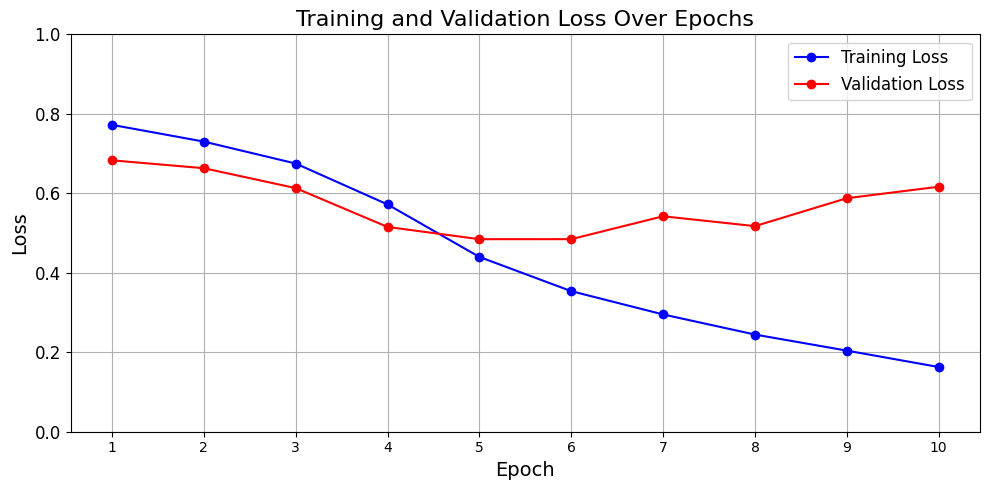

In [17]:
# Training history
history_model2b_df = pd.DataFrame(history_model2b.history)

# Reset the index to start with 1
history_model2b_df.index = range(1, len(history_model2b_df) + 1)

# Save DataFrame as CSV
file_path = '/content/drive/My Drive/DS266 Project/model2b_optimized.csv'
history_model2b_df.to_csv(file_path, index=False)

# Calling the improved plot function
plot_loss(history_model2b_df, ymin=0, ymax=1)

* Model 3: Local Attention
Highest Training Accuracy: 93.89% (Epoch 9)
Highest Validation Accuracy: 88.43% (Epoch 3)
Final Validation Accuracy: 86.90%
Observations: The validation loss started increasing significantly after the third epoch, indicating potential overfitting as the model learns the training data too well but performs worse on unseen validation data.
* Model 3: Local Attention Optimized
Highest Training Accuracy: 93.73% (Epoch 10)
Highest Validation Accuracy: 88.46% (Epoch 3)
Final Validation Accuracy: 87.54%
Observations: This model shows a more gradual increase in validation loss compared to Model 1, although it too shows signs of overfitting towards the later epochs as the validation loss starts to increase after reaching a minimum.
*Comparison
Stability: Model 2 shows a more stable learning curve with a less drastic increase in validation loss, suggesting better generalization compared to Model 1.
Performance: Both models achieve similar highest validation accuracies (around 88.4%), but Model 2 maintains a higher accuracy by the final epoch.
Overfitting: Both models exhibit signs of overfitting, but it's more pronounced in Model 1 with a very high spike in validation loss, whereas Model 2 increases more gradually.
*Conclusion
Model 2 performs slightly better in terms of maintaining a more stable validation loss and a slightly higher final validation accuracy. It suggests that Model 2 might be better at generalizing to new, unseen data compared to Model 1. However, both models would benefit from strategies to reduce overfitting, such as introducing regularization techniques, adjusting the dropout rate, or employing early stopping during training.

# Application

In [1]:
!pip install tweepy

In [2]:
 pip install --upgrade tweepy

In [3]:
 import tweepy

 consumer_key = 'QFS2GisCObt8G1E1nhimmibIW'
 consumer_secret = 'l3SK8KZ4B11eEbolrfdOIN3YaB2hHlTe6743KPUzmonW786JoP'
 access_token = '289567712-FDQBm8ORMqofA92uqnc3v74UfSvKATNTBcYrMMhx'
 access_token_secret = 'XNeEqdAu2IoxcEHHNLOBDrzqUNWMIeIY5egGQnValI2E1'

 # Authenticate to the Twitter API using the Client class
client = tweepy.Client(bearer_token="AAAAAAAAAAAAAAAAAAAAAIOotAEAAAAAI9nq96aD3nnFsCZKtMOdipcRRjM%3DvbSSLIcbgl5FElONH89N7yvE7nH7DI2gvBqMeIu8DgvUgXbzem")

# Define the tweet IDs of interest
tweet_ids = [1686930499388489728]

# Fetch the tweet information
tweets = client.get_tweets(ids=tweet_ids)
 # Authenticate to the Twitter API
#  auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
#  auth.set_access_token(access_token, access_token_secret)
#  api = tweepy.API(auth)

In [10]:
# Define the location from where you want to fetch tweets
latitude = 37.7749    # Example latitude (San Francisco)
longitude = -122.4194 # Example longitude (San Francisco)
radius = "10mi"       # Example radius in miles

query = f"#NASA lang:en geocode:{latitude},{longitude},{radius}"
# The rest of your code for fetching tweets using the Twitter API.

# This example retrieves recent tweets containing the '#python' hashtag
tweets = client.search_recent_tweets(query=query, tweet_fields=['context_annotations', 'created_at'], max_results=10)

for tweet in tweets.data:
    print(f"{tweet.id}: {tweet.text}\n")

tweet_fields = [
    'author_id', 'created_at', 'public_metrics'
]
user_fields = [
    'id', 'created_at', 'public_metrics', 'verified'
]

# Fetch tweets
tweets_response = client.search_recent_tweets(query=query, tweet_fields=tweet_fields, user_fields=user_fields, max_results=10)

# Extracting user IDs from tweets to fetch user details
user_ids = {tweet.author_id for tweet in tweets_response.data}

# Convert the set to a list
user_ids_list = list(user_ids)

# Now pass this string to the get_users call
users_response = client.get_users(ids=user_ids_list, user_fields=user_fields)

users_data = {user.id: user for user in users_response.data}

tweet_data = []

for tweet in tweets_response.data:
    user = users_data[tweet.author_id]
    metrics = tweet.public_metrics
    tweet_info = {
        'tweet_id': tweet.id,
        'user_id': user.id,
        'user_followers': user.public_metrics['followers_count'],
        'user_tweets': user.public_metrics['tweet_count'],
        'user_account_age': user.created_at,
        'user_verified': user.verified,
        'tweet_date': tweet.created_at,
        'retweet_count': metrics['retweet_count'],
        'reply_count': metrics['reply_count'],
        'like_count': metrics['like_count'],
        'quote_count': metrics['quote_count'],
        'hashtag_count': len(tweet.entities['hashtags']) if tweet.entities and 'hashtags' in tweet.entities else 0,
        'mention_count': len(tweet.entities['mentions']) if tweet.entities and 'mentions' in tweet.entities else 0,
        'url_count': len(tweet.entities['urls']) if tweet.entities and 'urls' in tweet.entities else 0,
        'media_type': tweet.entities['media'][0]['type'] if tweet.entities and 'media' in tweet.entities and tweet.entities['media'] else None,
    }
    tweet_data.append(tweet_info)

# Example to print the fetched data
for data in tweet_data:
    print(data)


BadRequest: 400 Bad Request
There were errors processing your request: Reference to invalid operator 'geocode'. Operator is not available in current product or product packaging. Please refer to complete available operator list at http://t.co/operators. (at position 15), Reference to invalid field 'geocode' (at position 15)

In [11]:
# Define the location from where you want to fetch tweets
latitude = 37.7749    # Example latitude (San Francisco)
longitude = -122.4194 # Example longitude (San Francisco)
radius = "10mi"       # Example radius in miles

query = f"#NASA lang:en geocode={latitude},{longitude},{radius}"
# The rest of your code for fetching tweets using the Twitter API.

# This example retrieves recent tweets containing the '#python' hashtag
tweets = client.search_recent_tweets(query=query, tweet_fields=['context_annotations', 'created_at'], max_results=10)

for tweet in tweets.data:
    print(f"{tweet.id}: {tweet.text}\n")

TypeError: 'NoneType' object is not iterable

In [12]:
query = f"#NASA lang:en geocode:{latitude},{longitude},{radius}"


In [17]:
# Since 'geocode' is not supported in Twitter API v2, we can't use it in the query.
query = f'#NASA lang:en place:place_id'

try:
    tweets = client.search_recent_tweets(query=query, tweet_fields=['context_annotations', 'created_at'], max_results=10)

    # After fetching tweets, you'd need to filter them by location manually.
    # This will only work if the tweets have location data attached.
    for tweet in tweets.data:
        if tweet.geo:  # If location data is present
            print(f"{tweet.id}: {tweet.text}\n")
        else:
            print("Tweet does not contain location data.")

except tweepy.BadRequest as e:
    print(f"BadRequest error: {e}")
except Exception as e:
    print(f"An error occurred: {e}")


BadRequest error: 400 Bad Request
There were errors processing your request: Reference to invalid operator 'place'. Operator is not available in current product or product packaging. Please refer to complete available operator list at http://t.co/operators. (at position 15)


In [18]:
import requests
import os
from urllib.parse import quote_plus

# Set up your Bearer Token in an environment variable for security
bearer_token = "AAAAAAAAAAAAAAAAAAAAAIOotAEAAAAAI9nq96aD3nnFsCZKtMOdipcRRjM%3DvbSSLIcbgl5FElONH89N7yvE7nH7DI2gvBqMeIu8DgvUgXbzem"

# Function to create headers with Bearer Token for authentication
def create_headers(bearer_token):
    headers = {"Authorization": f"Bearer {bearer_token}"}
    return headers

# Function to make a request to the "GET /2/places" endpoint
def get_place_id(headers, query):
    url = f"https://api.twitter.com/2/places?q={quote_plus(query)}"
    response = requests.get(url, headers=headers)

    if response.status_code != 200:
        raise Exception(f"Request returned an error: {response.status_code}, {response.text}")

    return response.json()

# Use the bearer token for authorization
headers = create_headers(bearer_token)

# Replace 'location_query' with your location of interest
location_query = 'Location Name Here'  # E.g., 'New York'

try:
    # Get place information for the specified location
    place_info = get_place_id(headers, location_query)

    # Print the response from the API
    print(place_info)

    # Parse through the response to find the place ID you need
    places = place_info.get('data', [])
    for place in places:
        # Assuming you need the place ID
        place_id = place.get('id')
        print(f"Place ID for {location_query}: {place_id}")

except Exception as e:
    print(e)

Request returned an error: 404, 


In [19]:
# Replace 'location_query' with your location of interest
location_query = 'Los Angeles'  # E.g., 'New York'

try:
    # Get place information for the specified location
    place_info = get_place_id(headers, location_query)

    # Print the response from the API
    print(place_info)

    # Parse through the response to find the place ID you need
    places = place_info.get('data', [])
    for place in places:
        # Assuming you need the place ID
        place_id = place.get('id')
        print(f"Place ID for {location_query}: {place_id}")

except Exception as e:
    print(e)

Request returned an error: 404, 


In [13]:
tweets = client.search_recent_tweets(query=query, tweet_fields=['context_annotations', 'created_at'], max_results=10)

if tweets.data is not None:
    for tweet in tweets.data:
        print(f"{tweet.id}: {tweet.text}\n")
else:
    print("No tweets found or there was an error with the request.")


BadRequest: 400 Bad Request
There were errors processing your request: Reference to invalid operator 'geocode'. Operator is not available in current product or product packaging. Please refer to complete available operator list at http://t.co/operators. (at position 15), Reference to invalid field 'geocode' (at position 15)

In [4]:
# Define the location from where you want to fetch tweets
latitude = 37.7749    # Example latitude (San Francisco)
longitude = -122.4194 # Example longitude (San Francisco)
radius = "10mi"       # Example radius in miles

query = f"#NASA lang:en geocode:{latitude},{longitude},{radius}"
# The rest of your code for fetching tweets using the Twitter API.


In [7]:
import tweepy
import pandas as pd

# First, you must apply for access and receive your consumer keys and access tokens from Twitter
consumer_key = 'QFS2GisCObt8G1E1nhimmibIW'
consumer_secret = 'l3SK8KZ4B11eEbolrfdOIN3YaB2hHlTe6743KPUzmonW786JoP'
access_token = '289567712-FDQBm8ORMqofA92uqnc3v74UfSvKATNTBcYrMMhx'
access_token_secret = 'XNeEqdAu2IoxcEHHNLOBDrzqUNWMIeIY5egGQnValI2E1'


# Authenticate to the Twitter API
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

# Authenticate to the Twitter API using the Client class
client = tweepy.Client(bearer_token="AAAAAAAAAAAAAAAAAAAAAIOotAEAAAAAI9nq96aD3nnFsCZKtMOdipcRRjM%3DvbSSLIcbgl5FElONH89N7yvE7nH7DI2gvBqMeIu8DgvUgXbzem")

# Define the tweet IDs of interest
tweet_ids = [1777465163777470865, 1777532385468502097]

# Fetch the tweet information
tweets = client.get_tweets(ids=tweet_ids)

# Create an empty DataFrame with columns for each feature you wish to include
columns = ['tweet_id', 'user_id', 'user_followers', 'user_tweets', 'user_account_age', 'user_verified',
           'tweet_date', 'retweet_count', 'reply_count', 'like_count', 'quote_count',
           'hashtag_count', 'mention_count', 'url_count', 'media_type']

features_df = pd.DataFrame(columns=columns)

# Populate the DataFrame with details from tweets
for tweet in tweets:
    tweet_data = {
        'tweet_id': tweet.id,
        'user_id': tweet.user.id,
        'user_followers': tweet.user.followers_count,
        'user_tweets': tweet.user.statuses_count,
        'user_account_age': tweet.user.created_at,
        'user_verified': tweet.user.verified,
        'tweet_date': tweet.created_at,
        'retweet_count': tweet.retweet_count,
        'reply_count': tweet._json['reply_count'] if 'reply_count' in tweet._json else None,  # Not all versions include this count
        'like_count': tweet.favorite_count,
        'quote_count': tweet._json['quote_count'] if 'quote_count' in tweet._json else None,  # Not all versions include this count
        'hashtag_count': len(tweet.entities['hashtags']),
        'mention_count': len(tweet.entities['user_mentions']),
        'url_count': len(tweet.entities['urls']),
        'media_type': tweet.entities['media'][0]['type'] if 'media' in tweet.entities else None,
    }
    features_df = features_df.append(tweet_data, ignore_index=True)

# Ensure tweet_date and user_account_age are in a proper datetime format
features_df['tweet_date'] = pd.to_datetime(features_df['tweet_date'])
features_df['user_account_age'] = pd.to_datetime(features_df['user_account_age'])

# Compute account age in days (for example)
features_df['user_account_age_days'] = (pd.Timestamp.now() - features_df['user_account_age']).dt.days

# You can then merge this DataFrame with your existing dataset on 'tweet_id'

AttributeError: 'list' object has no attribute 'id'

In [6]:
query

'#NASA lang:en geocode:37.7749,-122.4194,10mi'

In [5]:
# Preprocess the tweets as you did for your training data.
tweets_texts = [tweet.text for tweet in tweets_response.data]  # Assuming each tweet object has a .text attribute.
tweet_sequences = tokenizer.texts_to_sequences(tweets_texts)
tweet_sequences_padded = pad_sequences(tweet_sequences, maxlen=MAX_TOKENS, padding='post')


NameError: name 'tweets_response' is not defined